#Random Forest To Predict the Winner Part 1 - using newdf

Given the data that we gathered from Riot's database, we wanted to figure out which features would be important to look at to predict the winning team. **Random Forest** is a useful tool to figure out how important each features were, based on how many decision trees they are found in. 

Random Forests is powerful because it is unexcelled in accuracy among current algorithms, runs efficiently on large data bases, and is able to give the relative importance of each variable that we are testing. Also, it has the advantage of being less sensitive to collinearity problems. On the next part (as an Appendix of sorts), we'll show you the work that we (initially) conducted using OLS and Logistics, so you can take a look at why we favored Random Forest over those models. In the end, Random Forest best deals with colinearity issues. That being said, we do recognize that Random Forest does have issues with overfitting, and the limitations that follow from this overfitting.

We'll use Random Forest on two data sets
* A dataframe using cumulative statistics from the end of the game 
* A dataframe using statistics from specific timestamps within the game (10 min, 20 min, 30 min).


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

We've created a csv file using a package called 'Cassiopeia', which is used to query and parse through data we've obtained from Riot's database. We'll read in this csv file and create a **panda dataframe**. We'll print the head of the dataframe to see what we're working with.


In [2]:
dftouse = pd.read_csv('newdf.csv')
dftouse.head()

diffbaron  diffcc  diffcs  diffdmg  diffdrag  diffgold    diffkda  diffrange  diffspree  difftank  difftp fbaron fblood  fdrag finhib fturret    win
0          1     819     155    17067         3     17703  18.144444         -1          5         0       1   True  False   True   True   False   True
1          1    -685      24   -23447         0    -11396 -20.117208          1         -7         1      -1   True  False   True  False   False  False
2         -1     658      16    -5988         0    -11734 -21.416667          1         -3         1       2  False   True   True  False    True  False
3         -1    -339    -127    -9102        -2    -17661 -17.531349          1         -6         0       0  False  False  False  False   False  False
4          0     756     162    12505         0     11899  26.059524          0          3         3       0  False  False  False   True    True   True

In [8]:
cols = list(dftouse.columns)

In [9]:
print cols

['diffbaron', 'diffcc', 'diffcs', 'diffdmg', 'diffdrag', 'diffgold', 'diffkda', 'diffrange', 'diffspree', 'difftank', 'fbaron', 'fblood', 'fdrag', 'finhib', 'fturret', 'win']


<span style = "font-size: 1.5em;">Getting on with the classifier</span>

Now, let's get on with our random forest classifier.

First we want to create mask values so we can split the dataframe into training and testing sets. To do that we import `train_test_split`, and create mask values.

In [10]:
###Random forest classifier
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.75)

In [11]:
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [12]:
#seeing if it worked out correctly
mask.shape, mask.sum()

((20223,), 15167)

We define lcols to be the columns of the variables that we want to know about. We do this by creating a list of the our column names and then removing 'win' as that is the response variable.

In [13]:
#Now we will be using a Random Forest classifier to figure out which features are more 
#important in determining the probability of a team winning. First, we split the data set.

#columns with values to fit as the X values
lcols = list(dftouse.columns.values)
#removing the win (y) response variables from the list
lcols.remove('win')
print(lcols)

['diffbaron', 'diffcc', 'diffcs', 'diffdmg', 'diffdrag', 'diffgold', 'diffkda', 'diffrange', 'diffspree', 'difftank', 'fbaron', 'fblood', 'fdrag', 'finhib', 'fturret']


Don't forget to `import` the `RandomForestClassifier`!

In [14]:
from sklearn.ensemble import RandomForestClassifier

First, we'll create a `RandomForestClassifier` with the default parameters that we can use to optimize later.

In [15]:
clfForest = RandomForestClassifier()

We define two functions: `cv_optimize` and `do_classify`, derived from pset3.

`cv_optimize` takes in:
* clf as the original classifer (which in our case is clfForest) 
* the parameters to search over (we will be optimizing the n_estimator parameter)
* The X training matrix
* The y training vector

It returns the *best* parameter, according to the score.

`do_classify` uses `cv_optimize` and outputs the **X training matrix, y training vector, X test matrix, y test vector, the new optimized and fitted classifier, and the accuracy of the new model on the training and test sets**.

`do_classify` takes in:
* indf as the input dataframe (dftouse)
* featurenames as the variables we want to test (lcols)
* targetname as the variable we want predict (win)
* mask, the boolean vector indicator test set
* n_jobs, used for parallelization
* score_func, algorithm used to determine score

In [17]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix

def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split =None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

We want to optimize `n_estimators`, which is the number of trees in the forest. We wanted a large number of trees in the forest so we can better identify which features are more important; so we'll test to see up to 99 trees. Then, we'll run `do_classify`.

In [19]:
parameters = {"n_estimators": range(1, 100)}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
                                                       dftouse, lcols, 'win', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 89} 0.978294941387 [mean: 0.96036, std: 0.00697, params: {'n_estimators': 1}, mean: 0.96372, std: 0.00277, params: {'n_estimators': 2}, mean: 0.97101, std: 0.00261, params: {'n_estimators': 3}, mean: 0.97229, std: 0.00386, params: {'n_estimators': 4}, mean: 0.97532, std: 0.00194, params: {'n_estimators': 5}, mean: 0.97492, std: 0.00343, params: {'n_estimators': 6}, mean: 0.97550, std: 0.00251, params: {'n_estimators': 7}, mean: 0.97629, std: 0.00211, params: {'n_estimators': 8}, mean: 0.97610, std: 0.00202, params: {'n_estimators': 9}, mean: 0.97526, std: 0.00286, params: {'n_estimators': 10}, mean: 0.97759, std: 0.00335, params: {'n_estimators': 11}, mean: 0.97630, std: 0.00209, params: {'n_estimators': 12}, mean: 0.97589, std: 0.00260, params: {'n_estimators': 13}, mean: 0.97705, std: 0.00337, params: {'n_estimators': 14}, mean: 0.97766, std: 0.00267, params: {'n_estimators': 15}, mean: 0.97701, std: 0.00186, params: {'n_estimators': 16}, mean: 0.97737, std: 0.0

The best parameter value is 89, with a score of 0.978. Let's print the clfForest to see its features.

In [20]:
clfForest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=89, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Let's store the training and test sets in `reuse_split` so we can use them later with consistent sets.

In [21]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

<span style = "font-size: 1.34em"> Visualizing the results <span>

We'll first visualize the relative importance of each feature. The importances sum up to 1, which gives us an interesting insight into how important each feature was in predicting the winner. `feature_importances` returns the importances.

In [22]:
#We can plot the importances
importances = clfForest.feature_importances_

We'll sort the importances and column names so they match up.

In [23]:
imp_sort, lcols_sort = zip(*sorted(zip(importances, lcols)))

We'll use a horizontal bar chart to compare the importances. 

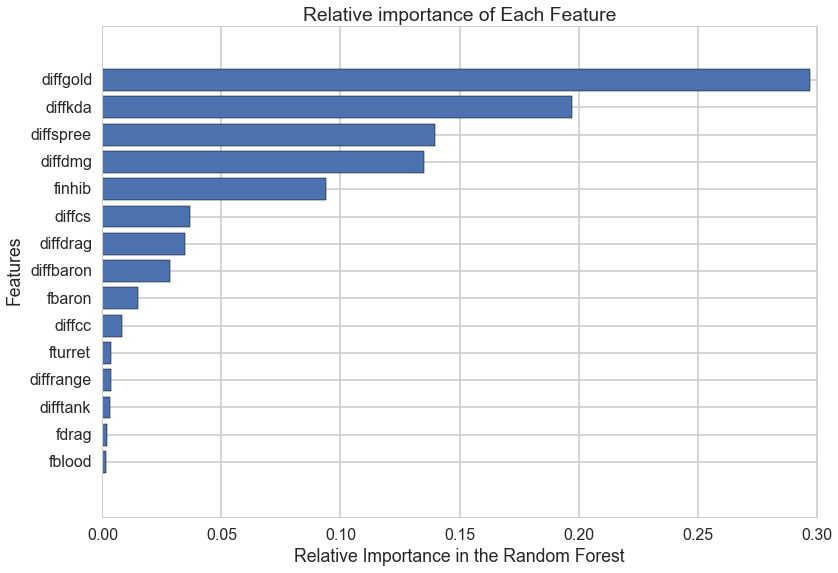

In [24]:
#plot importances
plt.barh(range(len(lcols_sort)),imp_sort,align='center')
plt.yticks(range(len(lcols_sort)),lcols_sort)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

We see that the results show us that the five most important variables in predicting the winner of the game are difference in gold earned, difference in kill-death-assist ratio, who got the first inhib, difference in damage dealt to champions, and difference in the number of killing sprees. Comparatively, we see that difference in the number of type of champions, such as "tank" and "ranged", were very weak variables, as well as who got first blood and who got first turret. 

Intuitively, this makes sense because the strongest variables are the ones that are most indicative of which team was "ahead," where as the weaker variables had more to do with characteristics of the team (which could be assessed before the game started) based on which champions were chosen. Accordingly, the predictive power of those post-game statistics are naturally stronger than the pre-game ones. 

Let's create some more visuals to see how these visuals interact with the wins. First, let's make a new dataframe with only the blue team wins, and a new dataframe with only red team wins.

In [25]:
bluewins = dftouse.query('win == True')
redwins = dftouse.query('win == False')

First, we plotted a histogram of the gold difference (in thousands) of all games. Positive values indicate that blue team had more gold amassed.

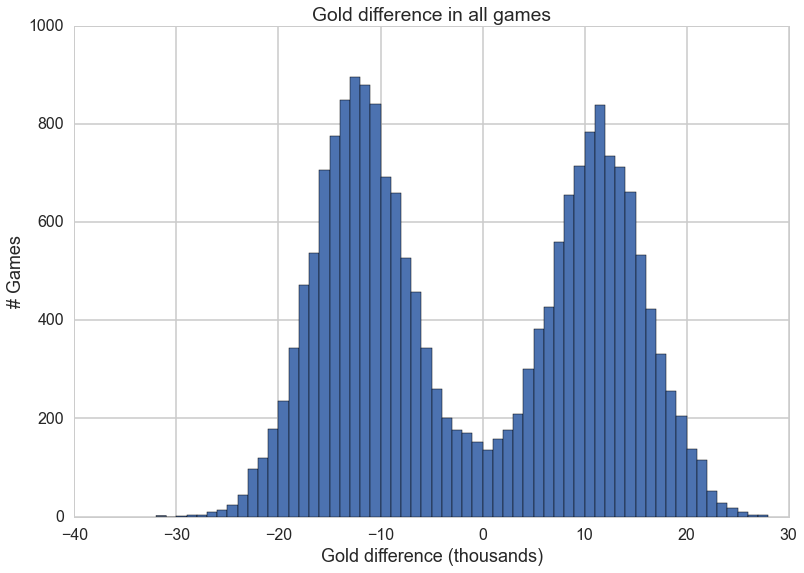

In [26]:
#all games
plt.hist(np.array(dftouse['diffgold'])/1000, bins = 60)
plt.ylabel('# Games', fontsize = 18)
plt.ylim((0,1000))
plt.xlabel('Gold difference (thousands)', fontsize = 18)
plt.title('Gold difference in all games')

We see that the resulting histogram shows 2 almost normally distributed curves, centered around about 12,000 and -12,000. This is probably because of how important gold difference is in predicting the winner of the game. We then plot the blue team wins and red team wins side by side to see if this is really the case. Once again, positive values indicate that the blue team had more gold.

/Users/leosjk/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


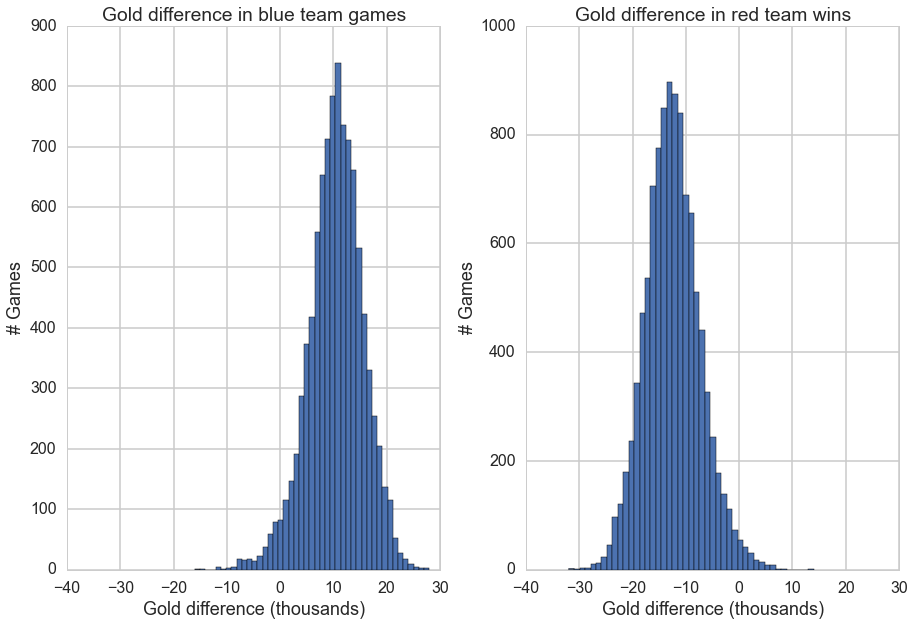

In [27]:
#Plotting side by side
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharex = True, tight_layout = True)
#blue team win
ax1.hist(np.array(bluewins['diffgold'])/1000, bins = 45)
ax1.set_ylabel('# Games', fontsize = 18)
ax1.set_xlabel('Gold difference (thousands)', fontsize = 18)
ax1.set_title('Gold difference in blue team games')
#red team wins
ax2.hist(np.array(redwins['diffgold'])/1000, bins = 45)
ax2.set_ylabel('# Games', fontsize = 18)
ax2.set_ylim((0,1000))
ax2.set_xlabel('Gold difference (thousands)', fontsize = 18)
ax2.set_title('Gold difference in red team wins')

We see our prediction is correct - almost all the games that the blue team won, the gold difference is positive, while almost all the games that the red team won, the gold difference is negative (meaning red team had more gold). This provides us a visual into how gold difference is a good predictor to see who won the round at the end of the game. Let's do a kernel-density plot to see how they overlap.

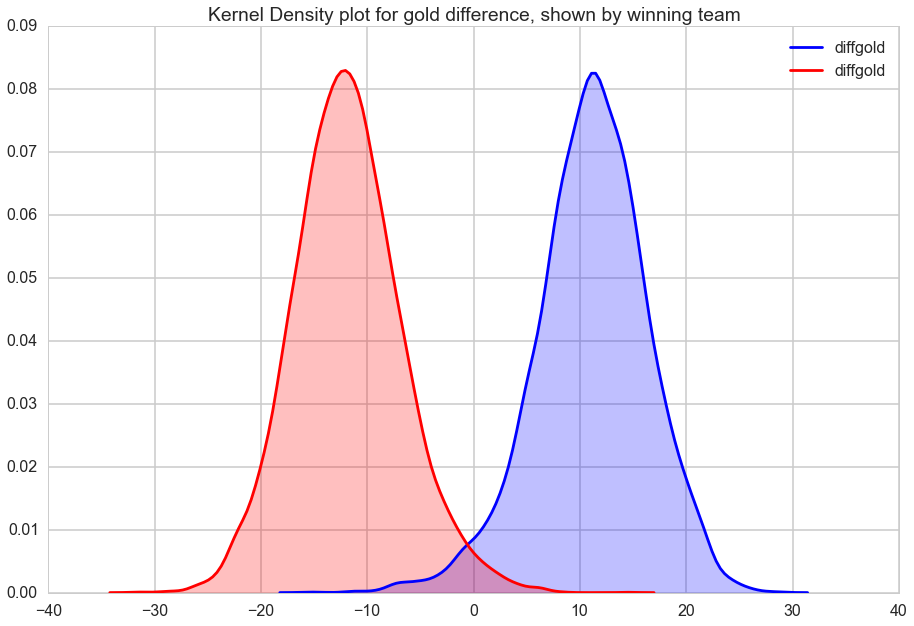

In [60]:
fig, ax1 = plt.subplots(ncols = 1, sharex = True, tight_layout = True)
sns.kdeplot(bluewins['diffgold']/1000, ax = ax1, legend = True, shade = True, color = 'b')
sns.kdeplot(redwins['diffgold']/1000, ax = ax1, legend = True, shade = True, color = 'r')
ax1.set_title("Kernel Density plot for gold difference, shown by winning team")

We try this with the difference in kill-death-assist ratios as well. First, we graph all games.

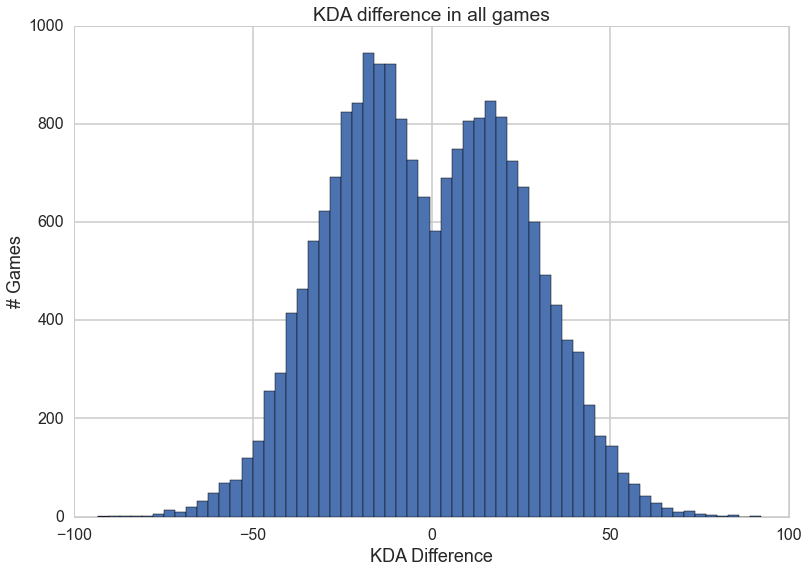

In [28]:
#all games
plt.hist(np.array(dftouse['diffkda']), bins = 60)
plt.ylabel('# Games', fontsize = 18)
plt.ylim((0,1000))
plt.xlabel('KDA Difference', fontsize = 18)
plt.title('KDA difference in all games')

The histogram above does not show the same amount of differentiation, per se, of the KDA differences between the blue and red teams. Nonetheless, the shape of the histogram, especially between -30 to 30, show that there might be some importance. Let's plot the blue team wins and red team wins side by side, using the KDA difference. Once again, positive values means the blue team has a higher KDA ratio.

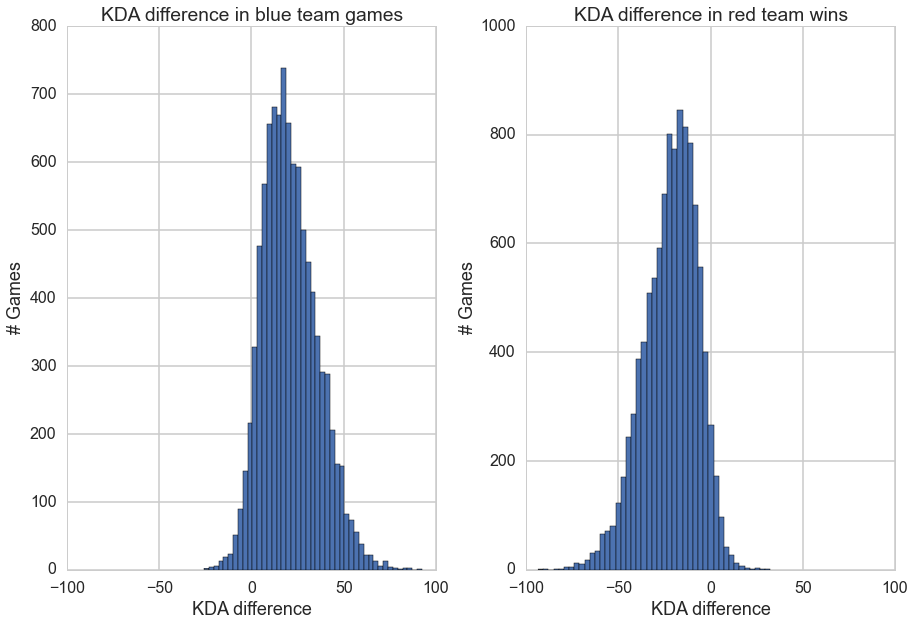

In [29]:
#Plotting side by side
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharex = True, tight_layout = True)
#blue team win
ax1.hist(np.array(bluewins['diffkda']), bins = 45)
ax1.set_ylabel('# Games', fontsize = 18)
ax1.set_xlabel('KDA difference', fontsize = 18)
ax1.set_title('KDA difference in blue team games')
#red team wins
ax2.hist(np.array(redwins['diffkda']), bins = 45)
ax2.set_ylabel('# Games', fontsize = 18)
ax2.set_ylim((0,1000))
ax2.set_xlabel('KDA difference', fontsize = 18)
ax2.set_title('KDA difference in red team wins')

We see that the two histograms show that KDA difference is important, but not as important as gold difference, as there is a bit of a skew to the right on blue team wins and a bit of a skew to the left on red team wins. We see that the two histograms are not starkly separated like the gold difference histograms, with many matches more towards the middle of the joint histogram. Let's look at the KDE plot to compare the two.

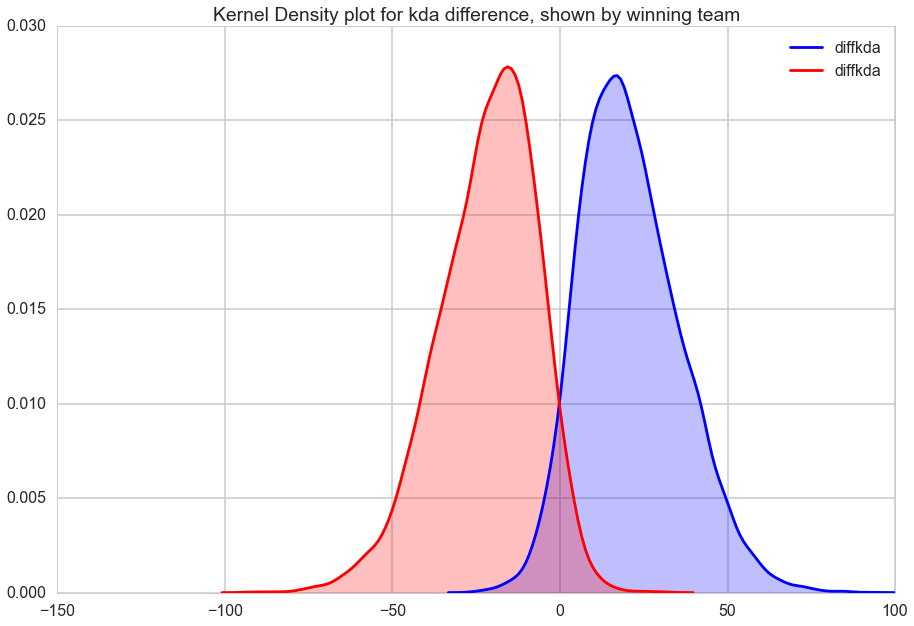

In [63]:
#KDE plot
fig, ax1 = plt.subplots(ncols = 1, sharex = True, tight_layout = True)
sns.kdeplot(bluewins['diffkda'], ax = ax1, legend = True, shade = True, color = 'b')
sns.kdeplot(redwins['diffkda'], ax = ax1, legend = True, shade = True, color = 'r')
ax1.set_title("Kernel Density plot for kda difference, shown by winning team")

The KDE plot shows that there overlap, with the "peaks" of the curves much closer to each other than the gold difference.

Next, we plot the top indicator variable, `finhib`, which returns `True` if blue team destroyed an inhibitor first, and `False` if red team destroyed an inhibitor first. Let's do a histogram that compares blue team wins versus red team wins, marked by who got the first inhibitor.

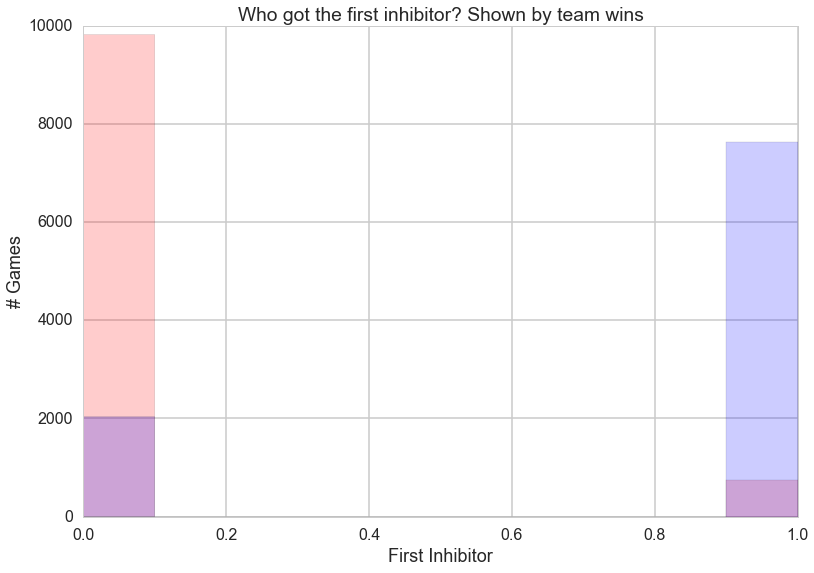

In [71]:
#all games, shown by team wins
plt.hist(np.array(redwins['finhib']), color = 'r', alpha = 0.2)
plt.hist(np.array(bluewins['finhib']), color = 'b', alpha = 0.2)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('First Inhibitor', fontsize = 18)
plt.title('Who got the first inhibitor? Shown by team wins')

We see that while there are quite a few games where the other team got the first inhibitor, our data shows that the majority of the wins are correlated with who got the first inhibitor.

Finally, let's look at two variables, "first blood" indicator and difference in duration of crowd control spells, that were shown to be "not important" by the random forest.

We'll use the kernel density plot for the `diffcc` variable:

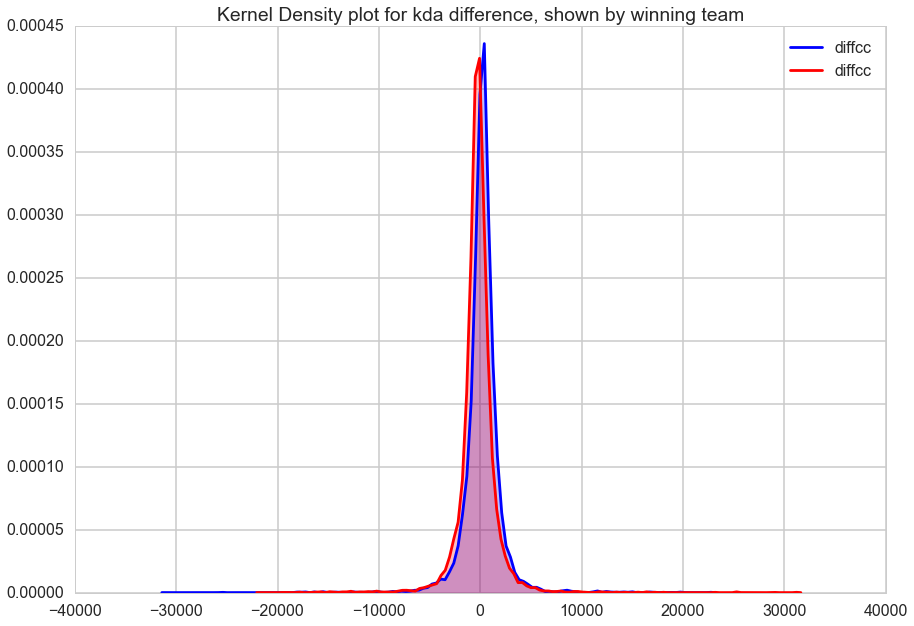

In [67]:
#KDE plot
fig, ax1 = plt.subplots(ncols = 1, sharex = True, tight_layout = True)
sns.kdeplot(bluewins['diffcc'], ax = ax1, legend = True, shade = True, color = 'b')
sns.kdeplot(redwins['diffcc'], ax = ax1, legend = True, shade = True, color = 'r')
ax1.set_title("Kernel Density plot for kda difference, shown by winning team")

We see that there is much overlap, indicating that this variable would not be helpful in predicting the winner. Next, let's look at "first blood".

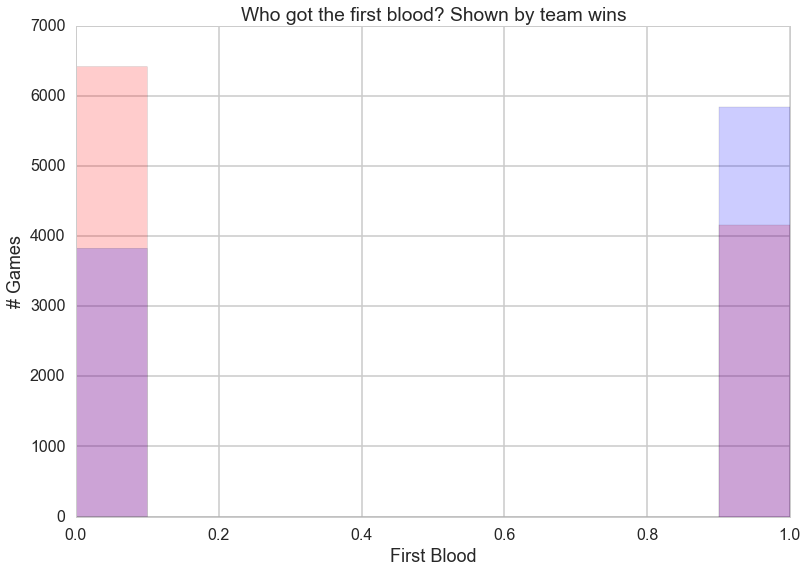

In [70]:
#all games, shown by team wins
plt.hist(np.array(redwins['fblood']), color = 'r', alpha = 0.2)
plt.hist(np.array(bluewins['fblood']), color = 'b', alpha = 0.2)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('First Blood', fontsize = 18)
plt.title('Who got the first blood? Shown by team wins')

We see that there are many games where the red team won without getting first blood, and there are many games where the blue team lost even after first blood. First blood isn't a good indicator.

Let's put all the visuals together, using either histogram or kernel density plots.

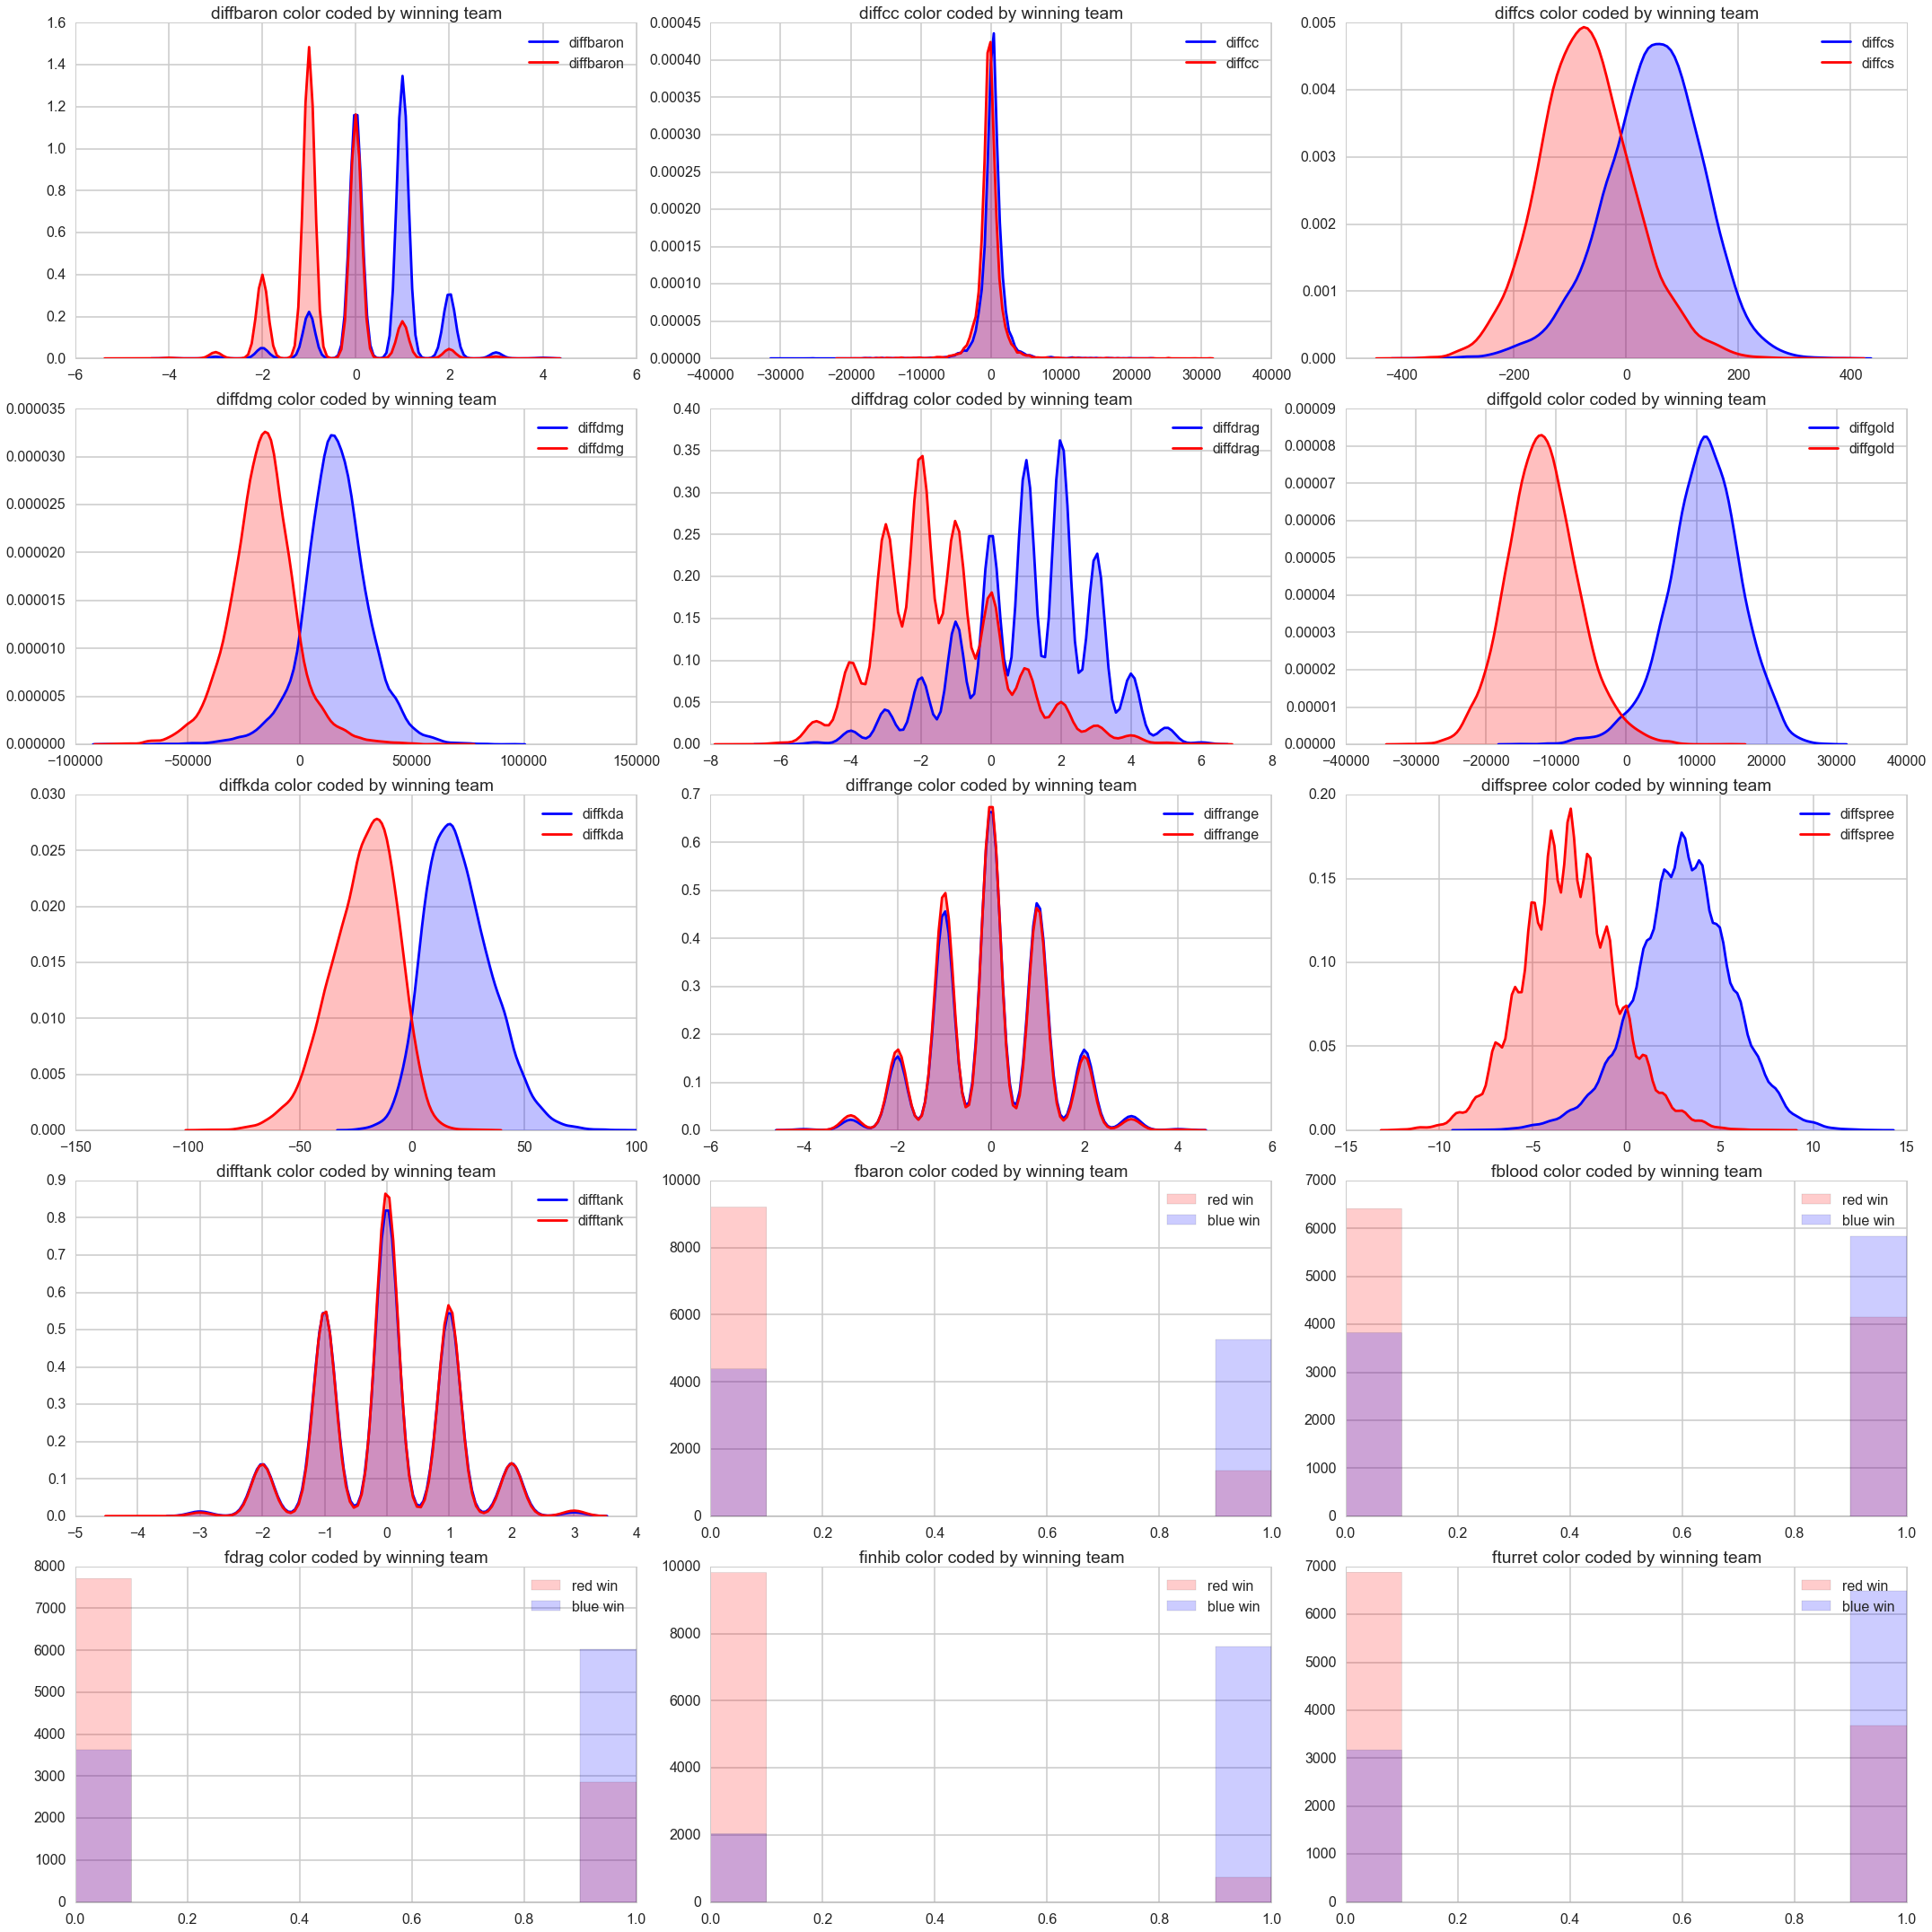

In [771]:
fig, axes = plt.subplots(5,3, figsize = (30,30), tight_layout = True)
for ax, col in zip(axes.ravel(), lcols):
    if "diff" in col:
        sns.kdeplot(bluewins[col], ax = ax, legend = True, shade = True, color = 'b')
        sns.kdeplot(redwins[col], ax = ax, legend = True, shade = True, color = 'r')
    else:
        ax.hist(np.array(redwins[col]), color = 'r', alpha = 0.2, label = "red win")
        ax.hist(np.array(bluewins[col]), color = 'b', alpha = 0.2, label = "blue win")
        ax.legend()
    ax.set_title(col + ' color coded by winning team')

<span style = "font-size: 1.2em"> Using a standardized data set </span>

We then standardized the dataset, to account for variability.

In [31]:
stddf = dftouse.copy()
stddf.head()

diffbaron  diffcc  diffcs  diffdmg  diffdrag  diffgold    diffkda  diffrange  diffspree  difftank fbaron fblood  fdrag finhib fturret    win
0          1     819     155    17067         3     17703  18.144444         -1          5         0   True  False   True   True   False   True
1          1    -685      24   -23447         0    -11396 -20.117208          1         -7         1   True  False   True  False   False  False
2         -1     658      16    -5988         0    -11734 -21.416667          1         -3         1  False   True   True  False    True  False
3         -1    -339    -127    -9102        -2    -17661 -17.531349          1         -6         0  False  False  False  False   False  False
4          0     756     162    12505         0     11899  26.059524          0          3         3  False  False  False   True    True   True

We'll create a list of variables to standardize.

In [32]:
#Standardizeable variables
stdz = list(dftouse.columns)
stdz.remove('win')
stdz.remove('fblood') 
stdz.remove('finhib')
stdz.remove('fdrag')
stdz.remove('fbaron')
stdz.remove('fturret')
print(stdz)

['diffbaron', 'diffcc', 'diffcs', 'diffdmg', 'diffdrag', 'diffgold', 'diffkda', 'diffrange', 'diffspree', 'difftank']


We'll split the train and test set, using the same mask values we obtained earlier, giving us the same sets, just with standardized values.

In [34]:
#adding mask column
stddf['Mask'] = mask
#trainset to fit and standardize
trainset = stddf.query('Mask == True')
testset = stddf.query('Mask == False')
#test set train set
trainset = trainset[stdz]
testset = testset[stdz]

In [35]:
#standardizing our data
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
preprocessing.StandardScaler().fit(trainset)
fitdf = preprocessing.StandardScaler().fit_transform(stddf[stdz])
newdf = pd.DataFrame(fitdf)
newdf.columns = trainset.columns

In [36]:
#replace values
stddf[stdz] = newdf
stddf.head()

diffbaron    diffcc    diffcs   diffdmg  diffdrag  diffgold   diffkda  diffrange  diffspree  difftank fbaron fblood  fdrag finhib fturret    win   Mask
0   1.012372  0.427762  1.615697  0.818152  1.487001  1.482770  0.744954  -0.848866   1.306314 -0.005191   True  False   True   True   False   True  False
1   1.012372 -0.346850  0.360326 -1.028140  0.112277 -0.836434 -0.728606   0.857049  -1.736486  0.957995   True  False   True  False   False  False   True
2  -0.875690  0.344841  0.283662 -0.232503  0.112277 -0.863373 -0.778652   0.857049  -0.722219  0.957995  False   True   True  False    True  False   True
3  -0.875690 -0.168648 -1.086705 -0.374414 -0.804205 -1.335757 -0.629018   0.857049  -1.482920 -0.005191  False  False  False  False   False  False   True
4   0.068341  0.395315  1.682778  0.610254  0.112277  1.020188  1.049785   0.004091   0.799181  2.884368  False  False  False   True    True   True   True

Let's split this new dataset.

In [37]:
Xmatrix = stddf[lcols].values
yvals = stddf['win'].values

In [38]:
##split to train and test
X_train = Xmatrix[mask]
X_test = Xmatrix[~mask]
y_train = yvals[mask]
y_test = yvals[~mask]

We'll fit the new set with the RandomForestClassifier from earlier.

In [40]:
#We can graph importances.
#First we fit
fitForest = clfForest.fit(X_train, y_train)

In [41]:
fitForest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=89, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Let's plot the importances.

In [43]:
#We can plot the importances
importances2 = fitForest.feature_importances_

In [45]:
imp_sort2, lcols_sort2 = zip(*sorted(zip(importances2, lcols)))

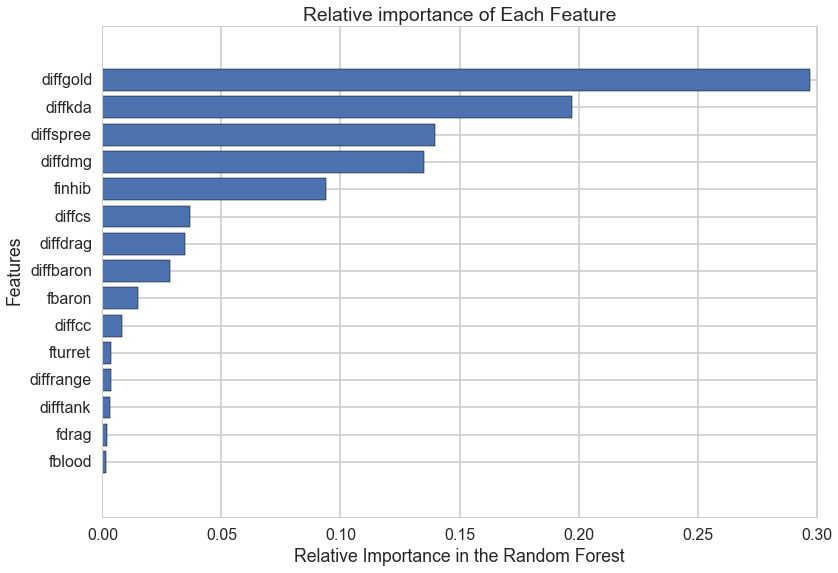

In [46]:
#plot importances
plt.barh(range(len(lcols_sort)),imp_sort,align='center')
plt.yticks(range(len(lcols_sort)),lcols_sort)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

As expected, we see that the variables that our earlier classifier found to be most important are still classified to be important. Let's graph the standardized gold difference values to visualize this quickly. First, histogram of all games:

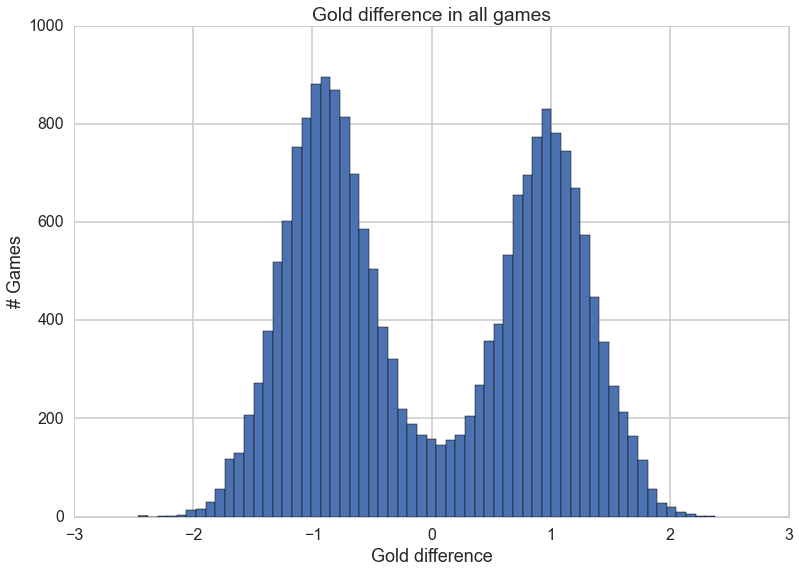

In [50]:
#all games
plt.hist(np.array(stddf['diffgold']), bins = 60)
plt.ylabel('# Games', fontsize = 18)
plt.ylim((0,1000))
plt.xlabel('Gold difference', fontsize = 18)
plt.title('Gold difference in all games')

Side-by-side histograms of gold differences by blue team wins and red team wins:

In [51]:
bluewins2 = stddf.query('win == True')
redwins2 = stddf.query('win == False')

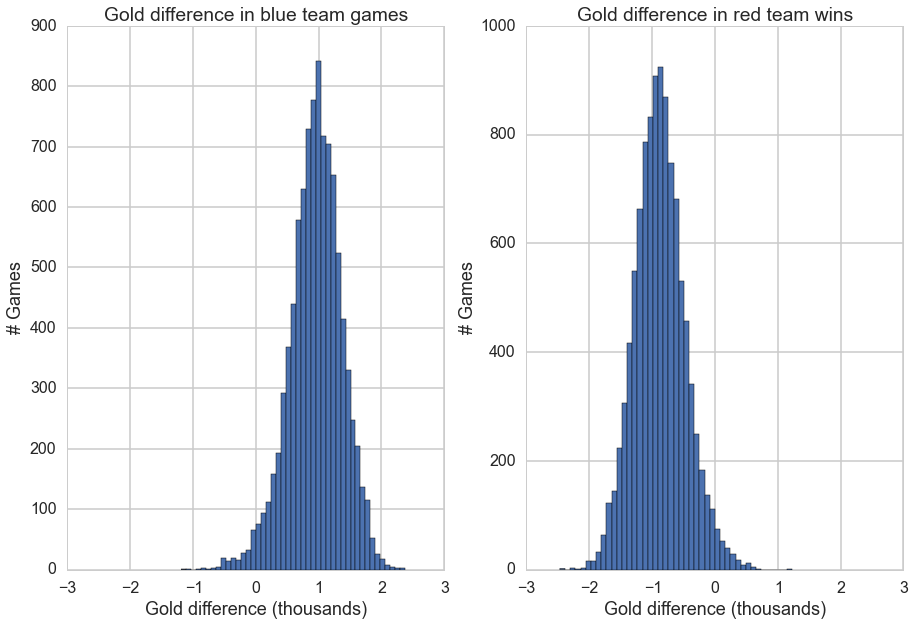

In [52]:
#Plotting side by side
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharex = True, tight_layout = True)
#blue team win
ax1.hist(np.array(bluewins2['diffgold']), bins = 45)
ax1.set_ylabel('# Games', fontsize = 18)
ax1.set_xlabel('Gold difference (thousands)', fontsize = 18)
ax1.set_title('Gold difference in blue team games')
#red team wins
ax2.hist(np.array(redwins2['diffgold']), bins = 45)
ax2.set_ylabel('# Games', fontsize = 18)
ax2.set_ylim((0,1000))
ax2.set_xlabel('Gold difference (thousands)', fontsize = 18)
ax2.set_title('Gold difference in red team wins')

And finally, the KDE plot:

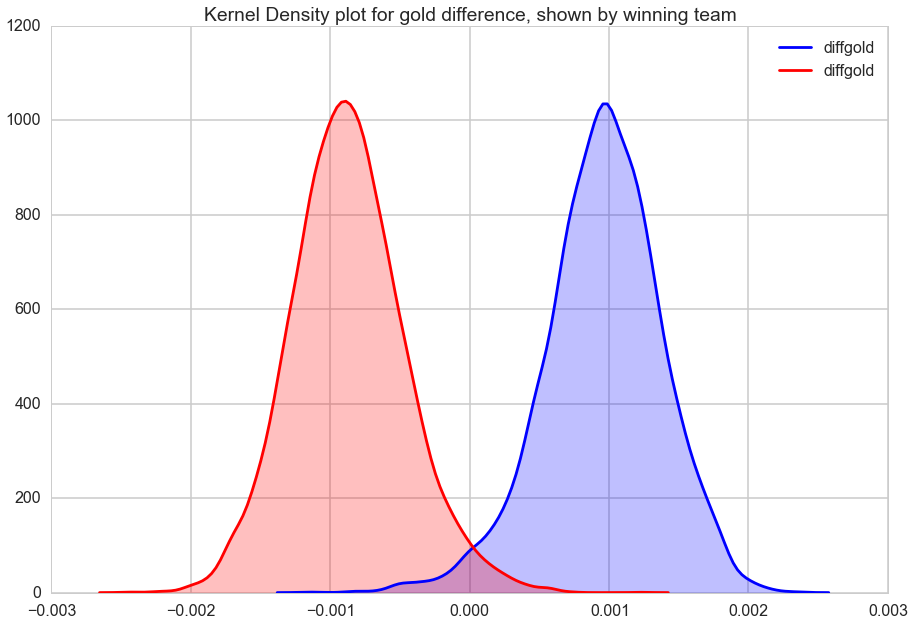

In [64]:
fig, ax1 = plt.subplots(ncols = 1, sharex = True, tight_layout = True)
sns.kdeplot(bluewins2['diffgold']/1000, ax = ax1, legend = True, shade = True, color = 'b')
sns.kdeplot(redwins2['diffgold']/1000, ax = ax1, legend = True, shade = True, color = 'r')
ax1.set_title("Kernel Density plot for gold difference, shown by winning team")

Unsurprisingly, we see that the visuals return the same story with slightly different values (as we have standardized them).

<span style="font-size: 1.3em">Initial Conclusion, and Moving Forward to the Next Step</span>

The RandomForestClassifier gave us the relative importance of each feature we tested for, and we've identified variables that showed to be very important in predicting the winner. We see that the top five variables (difference in gold, difference in kill-death-assist ratio, difference in killing spree, difference in damage dealt to champions, and who got the first inhibitor) seem to be far more important than things like who got first blood or what the difference in creep score is. This makes sense. For example, the KDA ratio shows how many champion kills the teams obtained. Gold is correlated to win conditions (inhibitors and turrets), as well as champion kills and creep scores. More gold allows for more powerups, which makes the team with more gold more powerful, and more likely to win.

Next, we see that our model on the training set has an accuracy of 100%, while on the test test it shows an accuracy of 98%. However, this accuracy is *too high*. This is because the features we look at to be important (beyond the indicator variables of things like "first inhibitor") are values from the **end of the round**, which makes it almost a redundant prediction, as the team with *more kills and more gold* is almost certainly the team that will win.

In order to improve our model, we've decided to next look at important features, such as gold difference, at certain timestamps in the game to predict the end results. That is the next step we took.

#Random Forest To Predict the Winner Part 2 - using finaldf

We now use a new dataframe, made from finaldf.csv, with new data from intervals of 10 mins of each game. The main difference between newdf and finaldf is how we measure our data. In newdf, all of the statistics were gathered when the game was already finished. This is why our predictive power for that model was so strong; as explained just above, predictions are too easy when you can easily find out who is the stronger, richer team. 

Accordingly, the next step we took was to not only find out what variables affect wins, but <b> when </b> these variables are important and if said importance changes throughout the course of the game. As we described in Part 3 of the Process Book, some of the variables had been added or removed in this 10-20-30 split model. For instance, we added ward placement statistics to see the power of early vision control, if any, on winning games. On the other hand, we removed variables such as first tower or first inhib and instead added variables to indicate the difference in the number of towers or inhibitors destroyed by each team at certain time points.

Let's load up the dataframe.

In [630]:
df = pd.read_csv('finaldf.csv')
df.astype(float)
df.head()

diffbaron10  diffbaron20  diffbaron30  diffcs10   diffcs20  diffcs30  diffdrag10  diffdrag20  diffdrag30  diffgpm10    diffgpm20    diffgpm30  diffinhib10  diffinhib20  diffinhib30  diffkill10  diffkill20  diffkill30  diffturret10  diffturret20  diffturret30  diffwardk10  diffwardk20  diffwardk30  diffwardp10  diffwardp20  diffwardp30  fb10l  fb20l  fb30l  gametimes     matchid    win
0            0            0            1       4.3   5.700000  3.800000           0           2           1      199.6   336.900000  1127.800000            0            0            2           2          -1           9             0             1             5            0            1            2           -4            2            1     -1     -1     -1       1873  1364966345   True
1            0            0            1       2.3   1.200000 -0.200000           1           1          -2      -75.5  -279.100000  -157.700000            0            0            0          -3          -5          -5            -1            -3             2            2           -2            2           -4          -14          -27     -1     -1     -1       2062  1365000117  False
2            0            0           -1       4.5  -4.500000  4.109589           0           1          -1      223.6  -475.000000 -1263.013699            0            0           -2           3          -4          -6             1            -3            -4            0            2            1            3           -8           -1      1      1      1       1638  1365001477  False
3            0            0           -1      -2.9  -9.100000 -0.737705           0          -1          -1     -274.6  -765.800000  -892.254098            0            0           -2          -6         -10          -5             0            -3            -4            0            1           -1            0          -10            4     -1     -1     -1       1688  1365005581  False
4            0            0            0       2.4  11.838111  0.000000           0           0           0      126.0  1076.458685     0.000000            0            1            0           3          10           0             0             5             0            0           -1            0           -6          -11            0     -1     -1     -1       1193  1365190124   True

In [632]:
len(df.index)

18819

<b> Dividing the dataframes</b>: Next, we have to divide the dataframe up into 3 different groups, according to the time frame they belong in. All @10 variables are grouped together, all @20 variables are grouped together, and all @30 variables are grouped together. This way, we can run the Random Forest Classifier three times, once for each time frame, on each of the three groups to see how relative importance changes at each time frame. The only variable that will be included in all three groups is "win," the dependent variable.

In [633]:
#We want to divide the dataframe into 3 dataframes
#First we'll get a list of all the column names
allcols = list(df.columns.values)
#Then we split the columns into columns from 10,20,30 min
col1 = []
col2 = []
col3 = []
for col in allcols:
    if "10" in col:
        col1.append(col)
    if "20" in col:
        col2.append(col)
    if "30" in col:
        col3.append(col)
#We'll append the win column, since that's the end result we want to predict
col1.append('win')
col2.append('win')
col3.append('win')

In [634]:
print col1
print col2
print col3

['diffbaron10', 'diffcs10', 'diffdrag10', 'diffgpm10', 'diffinhib10', 'diffkill10', 'diffturret10', 'diffwardk10', 'diffwardp10', 'fb10l', 'win']
['diffbaron20', 'diffcs20', 'diffdrag20', 'diffgpm20', 'diffinhib20', 'diffkill20', 'diffturret20', 'diffwardk20', 'diffwardp20', 'fb20l', 'win']
['diffbaron30', 'diffcs30', 'diffdrag30', 'diffgpm30', 'diffinhib30', 'diffkill30', 'diffturret30', 'diffwardk30', 'diffwardp30', 'fb30l', 'win']


<b> Cutting out games: </b> Next, we have to change the dataframes to match the time frame we want to work with. For instance, when we want to look at the @10 variables, we can use the entire dataframe since every single game has data from 0-10 minutes. However, when comparing importance of @20 variables, it wouldn't make much sense to include games that ended before the 10 minute mark, since those games would simply have 0 values for every single @20 column. And finally, for the @30 variable classifier, our dataframe should only contain games that lasted 20 minutes or longer, since games that ended before then would have no @30 variables. 

Thankfully, we included a length-of-game variable in our dataframe that we passed in, so we can create new dataframes to match each @time classifier.

In [635]:
#gametimes @ 20 min, games that are longer >600
hidf = df.loc[df['gametimes']>600]
#gametimes @ 30 min, games that are longer >1200
hidf2 = df.loc[df['gametimes']>1200]

In [636]:
#10 min values
df1 = df[col1]
#20 min values
df2 = hidf[col2]
#30 min values
df3 = hidf2[col3]

In [637]:
print len(df1.index)
print len(df2.index)
print len(df3.index)

18819
18800
17958


Thankfully, most of the data is still usable for @30. This is because it is very difficult for a game to end before 20 minutes; usually if that happens we can assume some extraneous circumstance occurred. Most of the time, games that end before 20 minutes means that one person on a team didn't connect to the game, making the game a 4v5 (and therefore a very one-sided game that ended quickly).

In [638]:
df1.head()

diffbaron10  diffcs10  diffdrag10  diffgpm10  diffinhib10  diffkill10  diffturret10  diffwardk10  diffwardp10  fb10l    win
0            0       4.3           0      199.6            0           2             0            0           -4     -1   True
1            0       2.3           1      -75.5            0          -3            -1            2           -4     -1  False
2            0       4.5           0      223.6            0           3             1            0            3      1  False
3            0      -2.9           0     -274.6            0          -6             0            0            0     -1  False
4            0       2.4           0      126.0            0           3             0            0           -6     -1   True

In [639]:
df2.head()

diffbaron20   diffcs20  diffdrag20    diffgpm20  diffinhib20  diffkill20  diffturret20  diffwardk20  diffwardp20  fb20l    win
0            0   5.700000           2   336.900000            0          -1             1            1            2     -1   True
1            0   1.200000           1  -279.100000            0          -5            -3           -2          -14     -1  False
2            0  -4.500000           1  -475.000000            0          -4            -3            2           -8      1  False
3            0  -9.100000          -1  -765.800000            0         -10            -3            1          -10     -1  False
4            0  11.838111           0  1076.458685            1          10             5           -1          -11     -1   True

In [640]:
df3.head()

diffbaron30  diffcs30  diffdrag30    diffgpm30  diffinhib30  diffkill30  diffturret30  diffwardk30  diffwardp30  fb30l    win
0            1  3.800000           1  1127.800000            2           9             5            2            1     -1   True
1            1 -0.200000          -2  -157.700000            0          -5             2            2          -27     -1  False
2           -1  4.109589          -1 -1263.013699           -2          -6            -4            1           -1      1  False
3           -1 -0.737705          -1  -892.254098           -2          -5            -4           -1            4     -1  False
5           -1 -1.443299           0  -920.927835           -1          -8            -5            4          -17     -1  False

Since we have changed the dimensions of the dataframes, we have to create a new mask to match the new shape:

In [641]:
itrain2, itest2 = train_test_split(xrange(df.shape[0]), train_size=0.75)

In [642]:
mask=np.ones(df.shape[0], dtype='int')
mask[itrain2]=1
mask[itest2]=0
mask = (mask==1)

In [643]:
#seeing if it worked out correctly
mask.shape, mask.sum()

((18819,), 14114)

We're now ready to run our Random Forest Classifier for each time frame:

<h3> 10 min dataframe</h3>

This process of Random Forest Classifier is now identical to the method that we used above; the only thing that changed is that the data we are looking at is not post-game data but data from the @10 minute mark.

In [644]:
#new Random forest classifier for 10 min
newForest1 = RandomForestClassifier()

In [645]:
#10 min variables to test
lcols1 = list(df1.columns.values)
#win is the response we want to test for
lcols1.remove('win')
lcols1

['diffbaron10',
 'diffcs10',
 'diffdrag10',
 'diffgpm10',
 'diffinhib10',
 'diffkill10',
 'diffturret10',
 'diffwardk10',
 'diffwardp10',
 'fb10l']

In [646]:
#We want a lot of trees 
parameters = {"n_estimators": range(1, 100)}
##We use the same mask values from the previous part since 1) the matches are the same, just different data and
##2) we want the same training and test matchids when doing do_classify
newForest1, Xtrain1, ytrain1, Xtest1, ytest1 = do_classify(newForest1, parameters, 
                                                       df1, lcols1, 'win', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 81} 0.679578326547 [mean: 0.60505, std: 0.00933, params: {'n_estimators': 1}, mean: 0.51370, std: 0.01571, params: {'n_estimators': 2}, mean: 0.63032, std: 0.01084, params: {'n_estimators': 3}, mean: 0.58198, std: 0.00611, params: {'n_estimators': 4}, mean: 0.64220, std: 0.00586, params: {'n_estimators': 5}, mean: 0.61389, std: 0.00249, params: {'n_estimators': 6}, mean: 0.65228, std: 0.01101, params: {'n_estimators': 7}, mean: 0.63083, std: 0.00680, params: {'n_estimators': 8}, mean: 0.65384, std: 0.00479, params: {'n_estimators': 9}, mean: 0.63634, std: 0.00686, params: {'n_estimators': 10}, mean: 0.66629, std: 0.00538, params: {'n_estimators': 11}, mean: 0.64362, std: 0.00412, params: {'n_estimators': 12}, mean: 0.65814, std: 0.00655, params: {'n_estimators': 13}, mean: 0.64554, std: 0.00999, params: {'n_estimators': 14}, mean: 0.66590, std: 0.00467, params: {'n_estimators': 15}, mean: 0.65707, std: 0.00391, params: {'n_estimators': 16}, mean: 0.66373, std: 0.0

A 69% accuracy in predictions at 10 minutes! Not bad, considering that most games go well over 20 minutes. 

Now let's look at relative importance:

In [647]:
#Optimized is 81 trees
newForest1

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=81, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [648]:
imp1 = newForest1.feature_importances_

In [649]:
imp1_sort, lcols1_sort = zip(*sorted(zip(imp1, lcols1)))

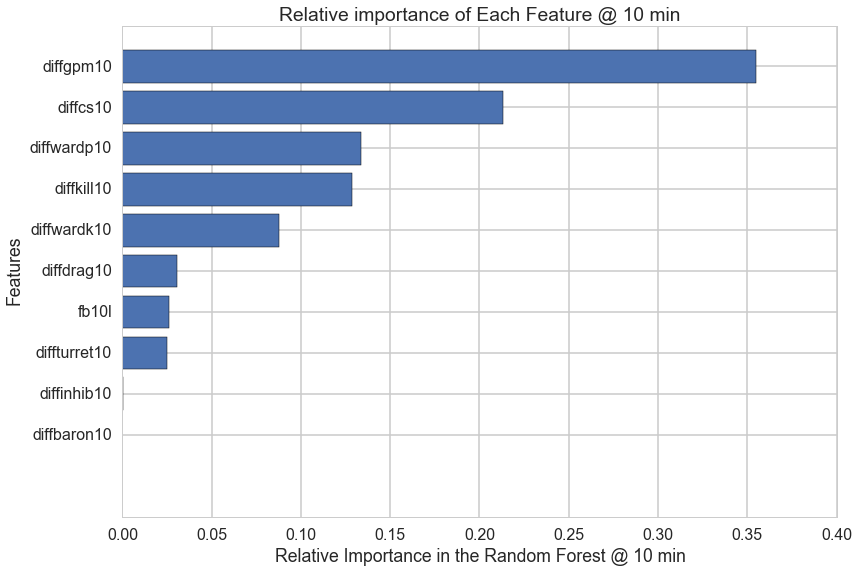

In [650]:
plt.barh(range(len(lcols1_sort)),imp1_sort,align='center')
plt.yticks(range(len(lcols1_sort)),lcols1_sort)
plt.xlabel('Relative Importance in the Random Forest @ 10 min')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature @ 10 min')
plt.show()

<b> Initial Observations: </b> Like we observed in newdf, gold remains king. Having a higher gold lead is the most influential in terms of predicting a winner. One surprising metric that had high relative importance was ward data; the difference in amount of wards placed and wards killed were both higher than differences in dragon kills, first blood, or turrets destroyed. One observation to make here is that relative importance of gold increased compared to our results in newdf. This is due to a few reasons. First, more variables were included in the newdf random forest classifier, which can only decrease the relative importance of gold. Further, however, gold <i> per minute </i> may simply be a more consistent metric that may be a better predictor of wins, 

Two possible explanations exist for this; first, increased amount of vision control is a causal factor to having strategic dominance over an opponent. Understanding where the enemy is helps plan out the team's next move, and not having vision in an area leaves a team susceptible to ganks (flanks from enemies) or unfavorable fighting positions. Second, teams that ward more frequently and have better vision control are generally better players in terms of understanding the game. Accordingly vision dominance could be a proxy for prowess in game knowledge, which is definitely a strong indicator of victory. 

Another observation to make is that creep score (CS) difference at 10 minutes is the second most important predictor of victories after gpm. This is particularly surprising because CS difference at 10 minutes can only get so high; normally, differences in CS aren't highly noticable until later stages in the game simply due to the fact that not many creeps die. Again, two possible explanations here. First, it could simply be the case that the other variables that were measured are so insignificant that creep score was the best metric out of the variables @10. A second explanation is that (similar to wards placed) CS is a particularly powerful indicator of who has dominance as a player over their opponent; CS'ing better means better mechanics and better decision making, which in turn lead to higher likelihood of winning. 

In [652]:
#spliting into blue and red wins to help us visualize
bluewins1 = df1.query('win == True')
redwins1 = df1.query('win == False')

**Gold Difference at 10 min**

Will this be as bi-modal as our initial dataframe?

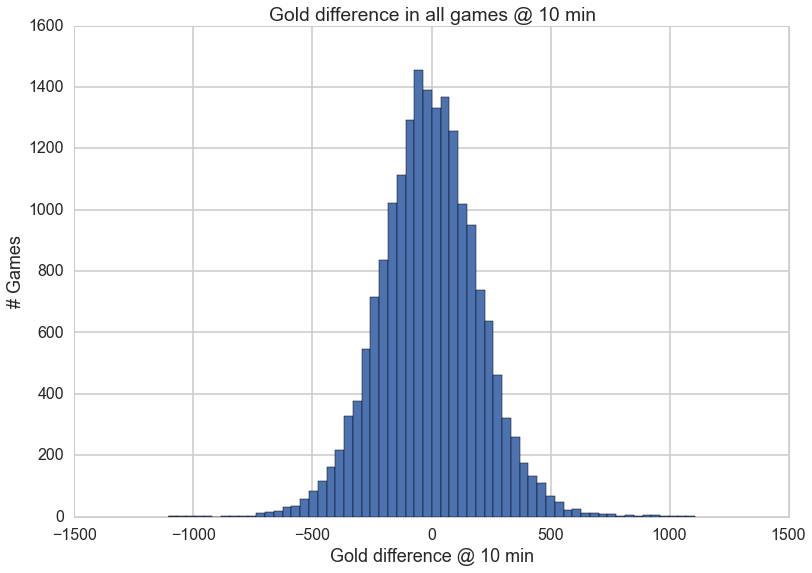

In [653]:
#all games
plt.hist(np.array(df1['diffgpm10']), bins = 60)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Gold difference @ 10 min', fontsize = 18)
plt.title('Gold difference in all games @ 10 min')

Gold difference seems to be pretty normally distributed, without telling us much why it's so important, so let's split it by winning teams to see why our classifier found it to be so important.

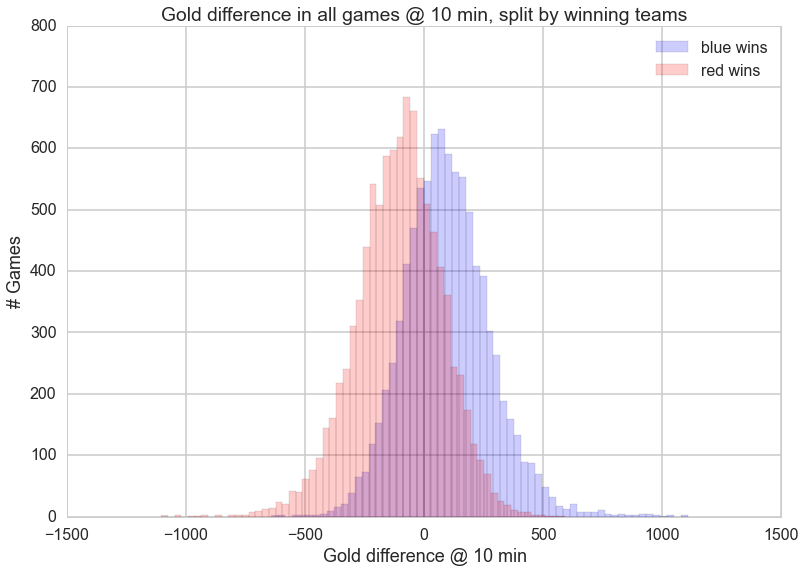

In [654]:
#all games, split by winning team
plt.hist(np.array(bluewins1['diffgpm10']), bins = 60, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins1['diffgpm10']), bins = 60, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.ylim((0,800))
plt.xlabel('Gold difference @ 10 min', fontsize = 18)
plt.title('Gold difference in all games @ 10 min, split by winning teams')
plt.legend()

While pretty close to 0, there still exists a peak away from 0 on either side in gold per minute, with means around -200 (for red side) and 200 (blue side). 

**Diff in cs @ 10 min**

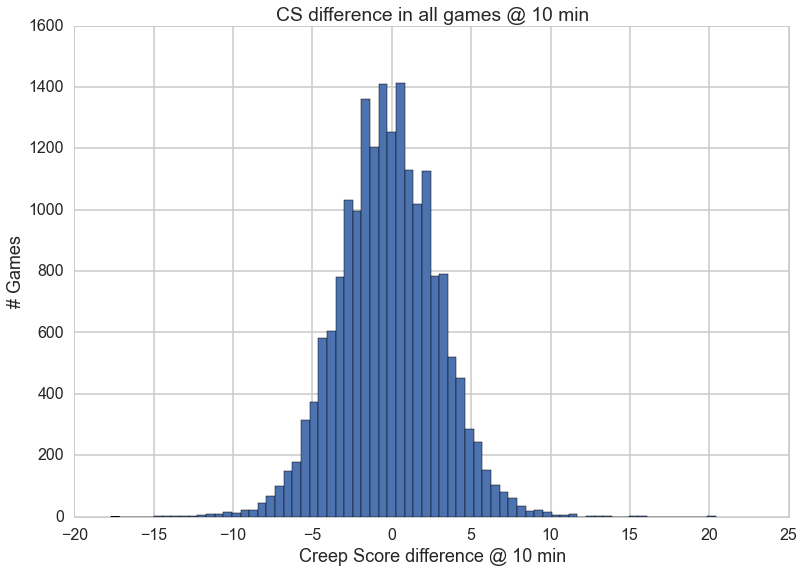

In [655]:
#all games
plt.hist(np.array(df1['diffcs10']), bins = 70)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Creep Score difference @ 10 min', fontsize = 18)
plt.title('CS difference in all games @ 10 min')

Again this doesn't really show us much, so let's look at it split into winning teams.

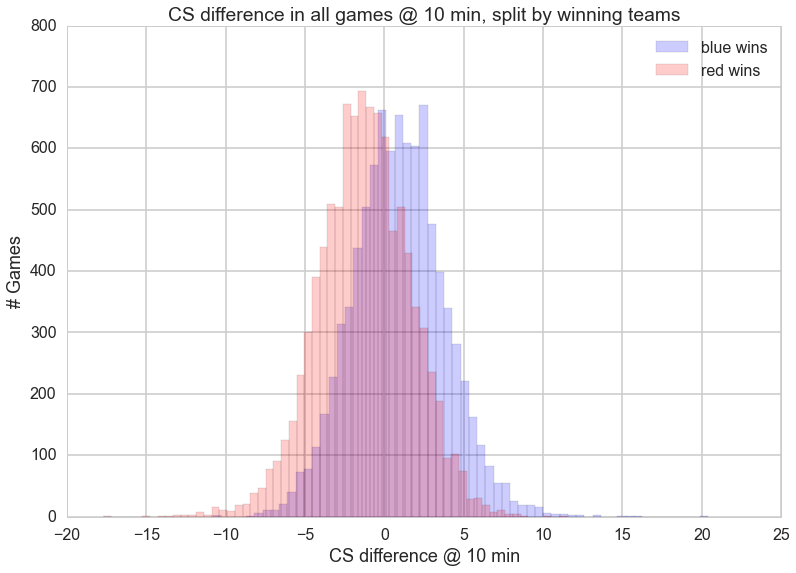

In [656]:
#all games, split by winning team
plt.hist(np.array(bluewins1['diffcs10']), bins = 60, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins1['diffcs10']), bins = 60, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.ylim((0,800))
plt.xlabel('CS difference @ 10 min', fontsize = 18)
plt.title('CS difference in all games @ 10 min, split by winning teams')
plt.legend()

Once again, we can see why this statistic was less strong of a predictor, since the split CS by wins is still quite close to a normal distribution centered around 0. That being said, however, we can still see some shift of the distribution away from 0. 

<b> Wards Placed @ 10 and kill difference</b> are even weaker, with only faint showing of shifting away from 0.

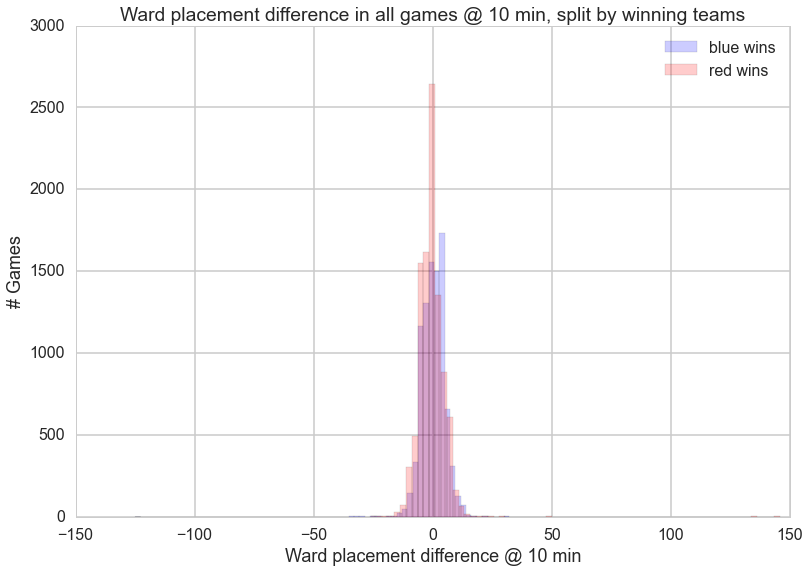

In [657]:
#all games, split by winning team
plt.hist(np.array(bluewins1['diffwardp10']), bins = 70, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins1['diffwardp10']), bins = 70, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Ward placement difference @ 10 min', fontsize = 18)
plt.title('Ward placement difference in all games @ 10 min, split by winning teams')
plt.legend()

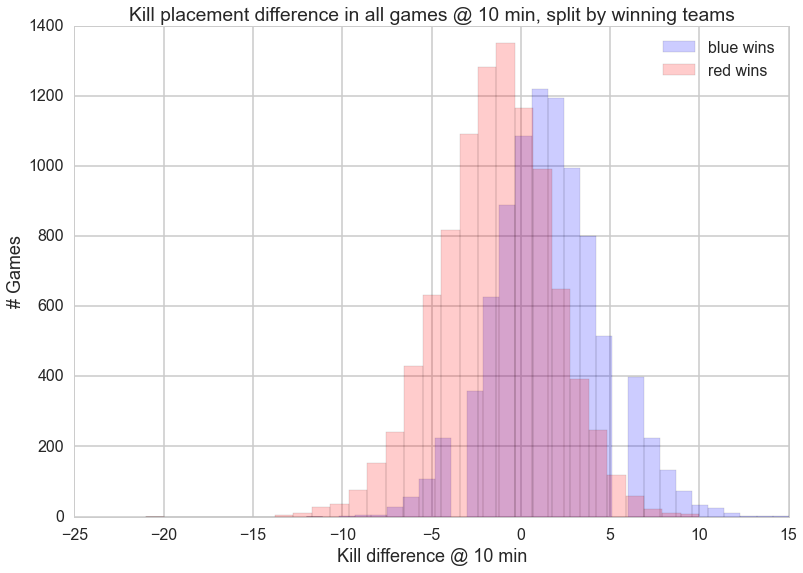

In [658]:
#all games, split by winning team
plt.hist(np.array(bluewins1['diffkill10']), bins = 30, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins1['diffkill10']), bins = 30, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Kill difference @ 10 min', fontsize = 18)
plt.title('Kill placement difference in all games @ 10 min, split by winning teams')
plt.legend()

Let's now look at features that were not deemed to be important, so difference in turrets and first bloods. Note that we are not including graphs for first baron or inhib; this is becasue it all of those column values are 0. Baron cannot be obatined before the 20 minute mark, and it is very difficult to get an inhib before the 10 minute mark (unless one team completely gives up and lets the enemy just push towards the nexus). 

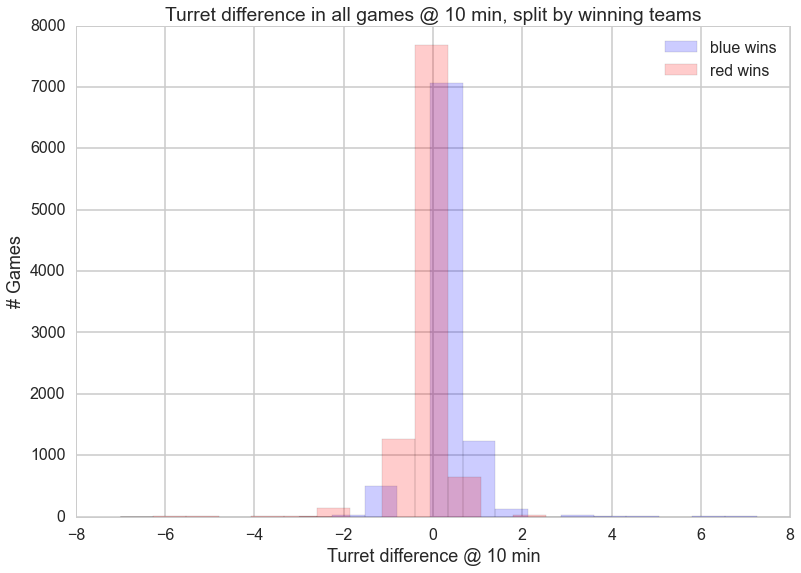

In [659]:
#all games, split by winning team
plt.hist(np.array(bluewins1['diffturret10']), bins = 15, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins1['diffturret10']), bins = 15, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Turret difference @ 10 min', fontsize = 18)
plt.title('Turret difference in all games @ 10 min, split by winning teams')
plt.legend()

Turret differences really don't tell much about the winning side; note that a majority of the time the turret difference is simply 0 because the game is too early for turrets to start falling.

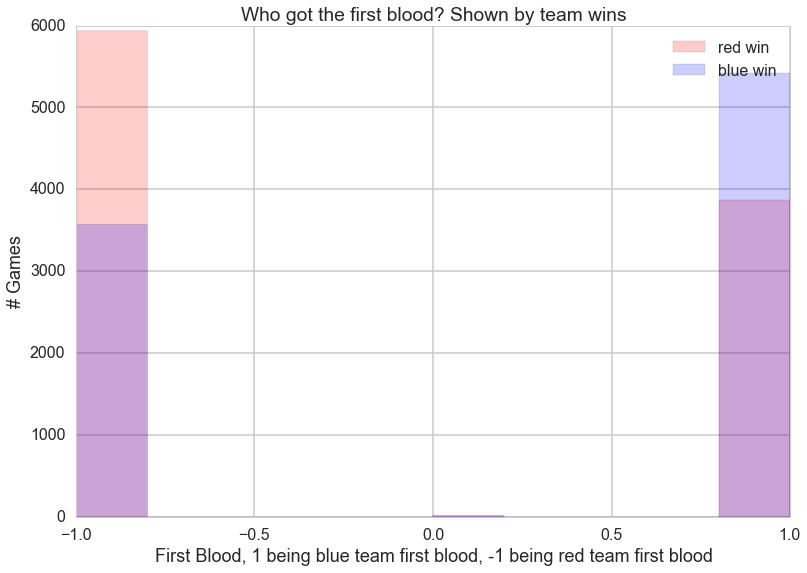

In [660]:
#all games, shown by team wins
plt.hist(np.array(redwins1['fb10l']), color = 'r', alpha = 0.2, label = "red win")
plt.hist(np.array(bluewins1['fb10l']), color = 'b', alpha = 0.2, label = "blue win")
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('First Blood, 1 being blue team first blood, -1 being red team first blood', fontsize = 18)
plt.title('Who got the first blood? Shown by team wins')
plt.legend()

First Blood is also not very helpful in telling who wins. The "Snowball Effect" of one kill leading to another leading to another is not as strong as the public may perceive it to be...

Here's are the plots for all the variables @10, color coded by winning team:

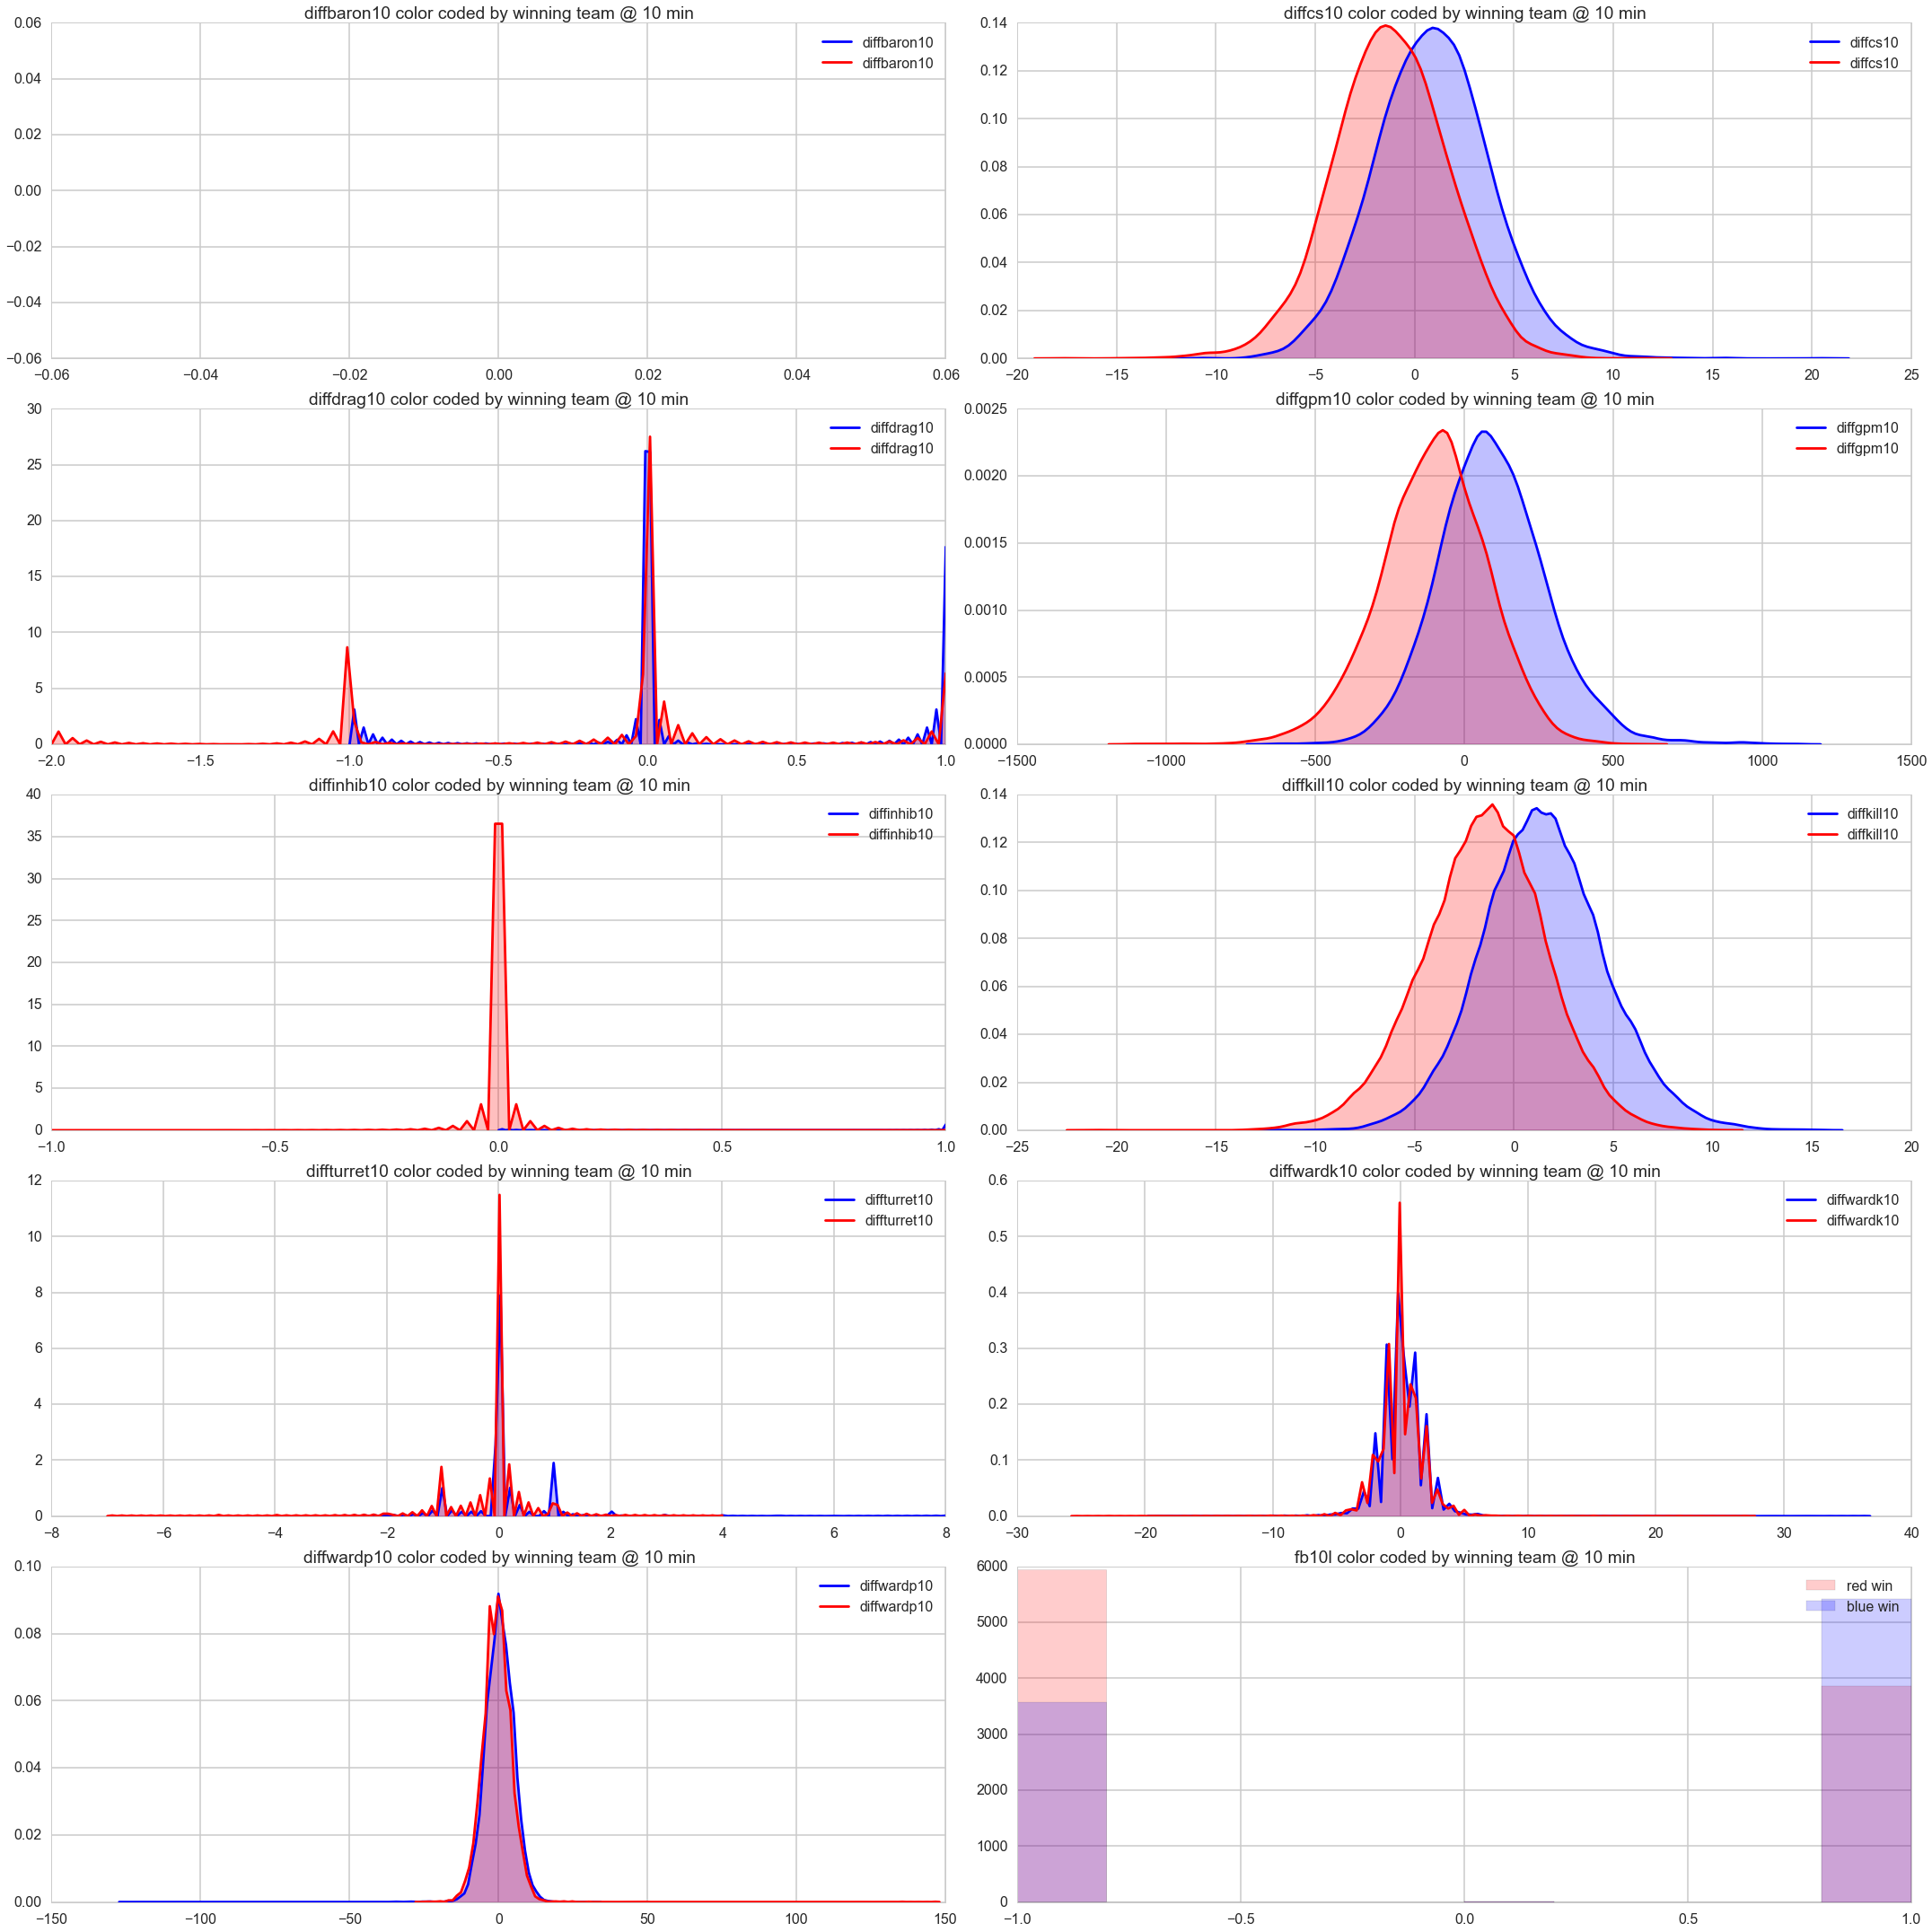

In [757]:
fig, axes = plt.subplots(5,2, figsize = (30,30), tight_layout = True)
for ax, col in zip(axes.ravel(), lcols1):
    if "diff" in col:
        sns.kdeplot(bluewins1[col], ax = ax, legend = True, shade = True, color = 'b')
        sns.kdeplot(redwins1[col], ax = ax, legend = True, shade = True, color = 'r')
    else:
        ax.hist(np.array(redwins1[col]), color = 'r', alpha = 0.2, label = "red win")
        ax.hist(np.array(bluewins1[col]), color = 'b', alpha = 0.2, label = "blue win")
        ax.legend()
    ax.set_title(col + ' color coded by winning team @ 10 min')

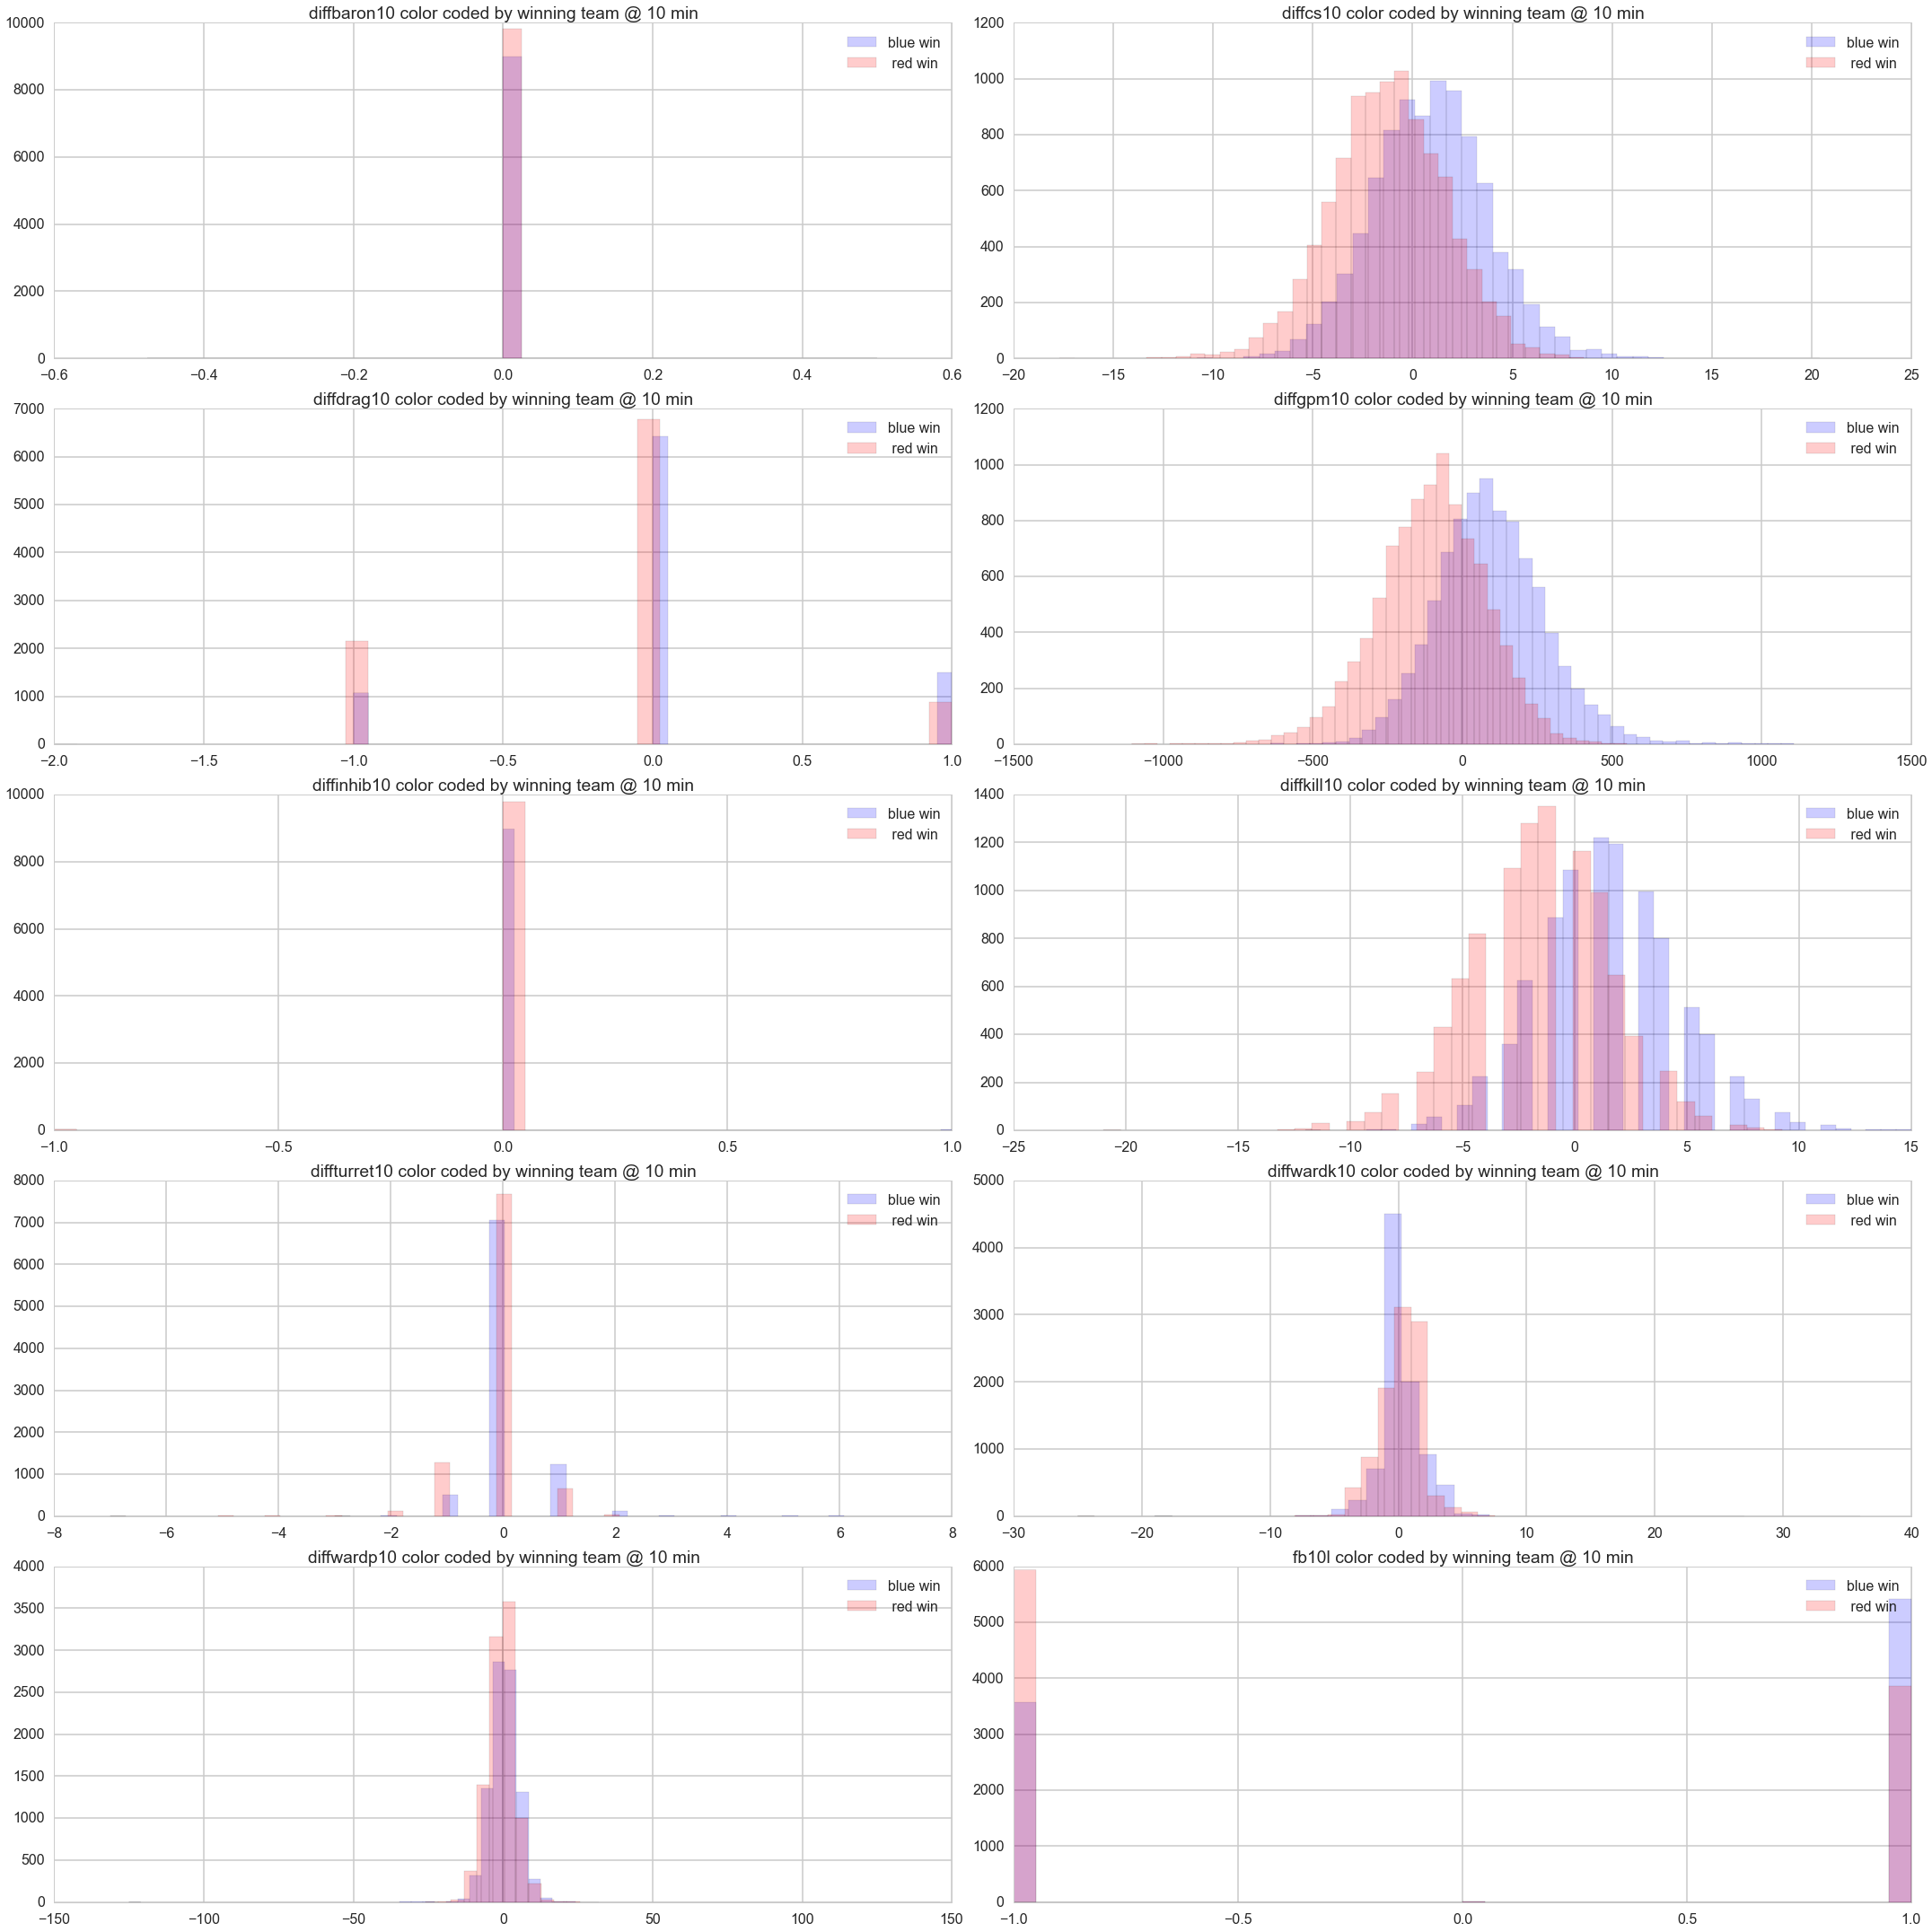

In [764]:
fig, axes = plt.subplots(5,2, figsize = (30,30), tight_layout = True)
for ax, col in zip(axes.ravel(), lcols1):
    ax.hist(np.array(bluewins1[col]), bins = 40, color = 'b', alpha = 0.2, label = "blue win")
    ax.hist(np.array(redwins1[col]), bins = 40,  color = 'r', alpha = 0.2, label = " red win")
    ax.legend()
    ax.set_title(col + ' color coded by winning team @ 10 min')

<h3> Overal analysis of @10 Data: </h3>As expected, the @10 data is much weaker in terms of prediction power compared to the post-game data we used in newdf. However, we still maintain a high accuracy due to the strength of some particular variables such as gold per minute, cs per minute, or vision control dominance. Now, let's move on to the 20 minute data:

<h3> 20 minute dataframe </h3>

Same process of 10 minute dataframe, with 20 minute data:

In [661]:
#new Random forest classifier for 20 min
newForest2 = RandomForestClassifier()

In [662]:
#20 min variables to test
lcols2 = list(df2.columns.values)
#win is the response we want to test for
lcols2.remove('win')
lcols2

['diffbaron20',
 'diffcs20',
 'diffdrag20',
 'diffgpm20',
 'diffinhib20',
 'diffkill20',
 'diffturret20',
 'diffwardk20',
 'diffwardp20',
 'fb20l']

In [663]:
itrain3, itest3 = train_test_split(xrange(df2.shape[0]), train_size=0.75)

mask=np.ones(df2.shape[0], dtype='int')
mask[itrain3]=1
mask[itest3]=0
mask = (mask==1)
mask=np.ones(df2.shape[0], dtype='int')
mask[itrain3]=1
mask[itest3]=0
mask = (mask==1)

In [664]:
#We want a lot of trees 
parameters = {"n_estimators": range(1, 100)}
##We use the same mask values from the previous part since 1) the matches are the same, just different data and
##2) we want the same training and test matchids when doing do_classify
newForest2, Xtrain2, ytrain2, Xtest2, ytest2 = do_classify(newForest2, parameters, 
                                                       df2, lcols2, 'win', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 69} 0.802797434121 [mean: 0.73009, std: 0.00700, params: {'n_estimators': 1}, mean: 0.70075, std: 0.00890, params: {'n_estimators': 2}, mean: 0.76681, std: 0.00581, params: {'n_estimators': 3}, mean: 0.74922, std: 0.00497, params: {'n_estimators': 4}, mean: 0.77551, std: 0.00619, params: {'n_estimators': 5}, mean: 0.76515, std: 0.00600, params: {'n_estimators': 6}, mean: 0.77875, std: 0.00309, params: {'n_estimators': 7}, mean: 0.77498, std: 0.01002, params: {'n_estimators': 8}, mean: 0.78529, std: 0.00430, params: {'n_estimators': 9}, mean: 0.78141, std: 0.00605, params: {'n_estimators': 10}, mean: 0.78466, std: 0.00627, params: {'n_estimators': 11}, mean: 0.78134, std: 0.00895, params: {'n_estimators': 12}, mean: 0.78617, std: 0.00770, params: {'n_estimators': 13}, mean: 0.78741, std: 0.01160, params: {'n_estimators': 14}, mean: 0.79417, std: 0.00284, params: {'n_estimators': 15}, mean: 0.78775, std: 0.00664, params: {'n_estimators': 16}, mean: 0.79605, std: 0.0

81% is over a 10 percent improvement! We're getting closer and closer to the newdf level of accuracy, and we only have data from the 20 minute mark and before.

In [670]:
#Optimized is 69 trees
newForest2

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=69, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [666]:
#get importances at 20 min
imp2 = newForest2.feature_importances_

In [667]:
imp2_sort, lcols2_sort = zip(*sorted(zip(imp2, lcols2)))

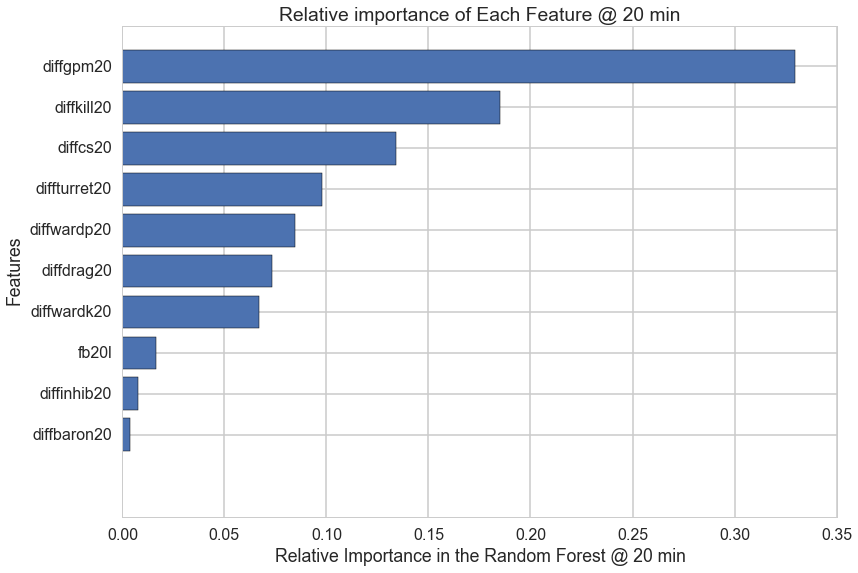

In [668]:
plt.barh(range(len(lcols2_sort)),imp2_sort,align='center')
plt.yticks(range(len(lcols2_sort)),lcols2_sort)
plt.xlabel('Relative Importance in the Random Forest @ 20 min')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature @ 20 min')
plt.show()

Unsurprisingly, gold is still the most domninant predictive factor. Unlike the 10 minute data, however, the next most important statistic is difference in number of kills. A few reasons why this may be the case: for one, the sheer number of kills in the game at that point is much higher than the number of kills at the 10 minute mark. The 10 minute mark of the game is still what is considered the "Early Game" where most of the champions are passively farming, and not many champion vs. champion fights occur. On the other hand, the 20 minute mark is considered the "Mid Game," where teams start to group up and fight as a team against the other team. This would mean that the simply due to the fact that the number of kills are increased and that kills can be one-sided (as in, one team takes down all members of the other team without losing a single member), the importance of kills in determining winners can be increased as well.
A second possible explanation is that kills in the mid game are more likely to lead to other factors that "Snowball" the game into one side's favor. For isntance, a teamfight that is won by one side most likely means that the winning team can get some sort of objective, be it dragon, turret, or even inhibitors and barons depending on where the fight occurred. The reason this is true is because a won teamfight or members down means that there is less resistance to the winning team when they take down these objectives. The enemy can't stop a team from killing dragon if the enemies themselves are already dead and unable to interfere. Even in the case that not all members of a certain team died (let's say only one member died), this could still lead to objectives being taken because engaging in a 4v5 fight could lead to even more harm for the team who is trying to contest the objective with a man down. 

Other notable observations include the fact that CS is still important, and that turrets are more important now due to the fact that more turrets are falling and turrets around the 20 minute mark could be the only thing stopping teams from taking down inhibitors. Finally, dragons have become more important due to the fact that fifth dragon is more of a salient concern at 20 minutes. To explain, each dragon killed by an enemy team gives them certain bonuses to their attributes (think more strength, more speed, etc.). However, by far the most important dragon kill is the 5th dragon kill, which gives the team a massive boost in stats and also an additional buff that increases their damage to all enemies dealt. However, dragons only spawn every 6 minutes, so 5th dragon doesn't become too big of a concern to worry about until later on in the mid/late game. Since the 20 minute mark is approaching that phase, dragons can become more salient in determining who will win.

Similar to the 10 minute statistics, we'll look at the individual factors now:

In [671]:
#spliting into blue and red wins to help us visualize
bluewins2 = df2.query('win == True')
redwins2 = df2.query('win == False')

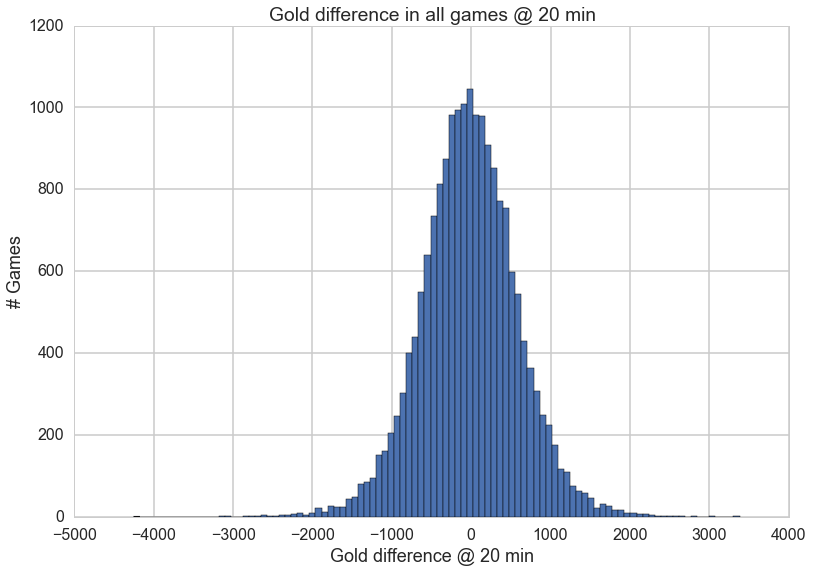

In [672]:
#all games
plt.hist(np.array(df2['diffgpm20']), bins = 100)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Gold difference @ 20 min', fontsize = 18)
plt.title('Gold difference in all games @ 20 min')

Interesting...

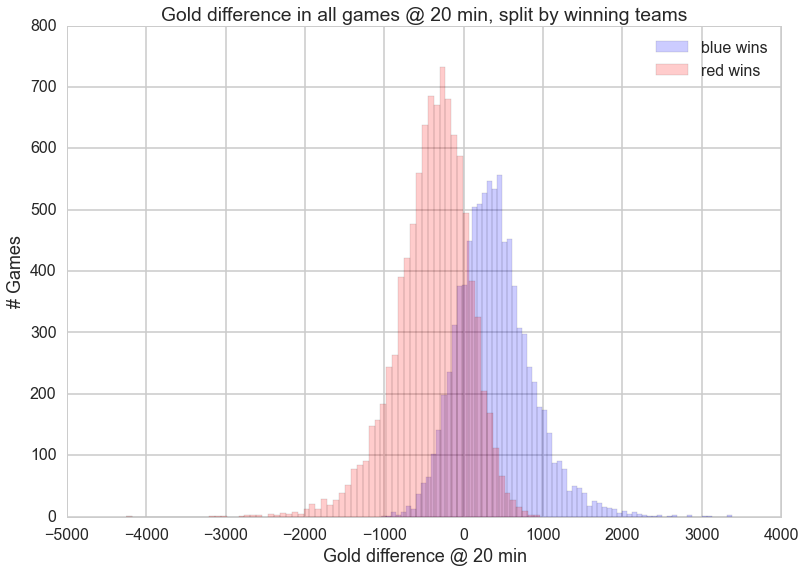

In [673]:
#all games, split by winning team
plt.hist(np.array(bluewins2['diffgpm20']), bins = 70, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins2['diffgpm20']), bins = 70, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.ylim((0,800))
plt.xlabel('Gold difference @ 20 min', fontsize = 18)
plt.title('Gold difference in all games @ 20 min, split by winning teams')
plt.legend()

We see the peaks becoming more defined for GPM.

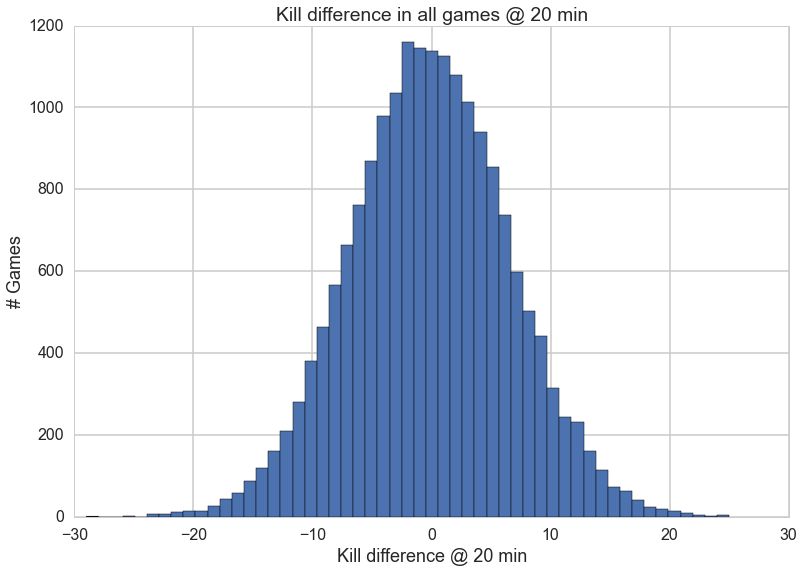

In [674]:
#all games
plt.hist(np.array(df2['diffkill20']), bins = 53)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Kill difference @ 20 min', fontsize = 18)
plt.title('Kill difference in all games @ 20 min')

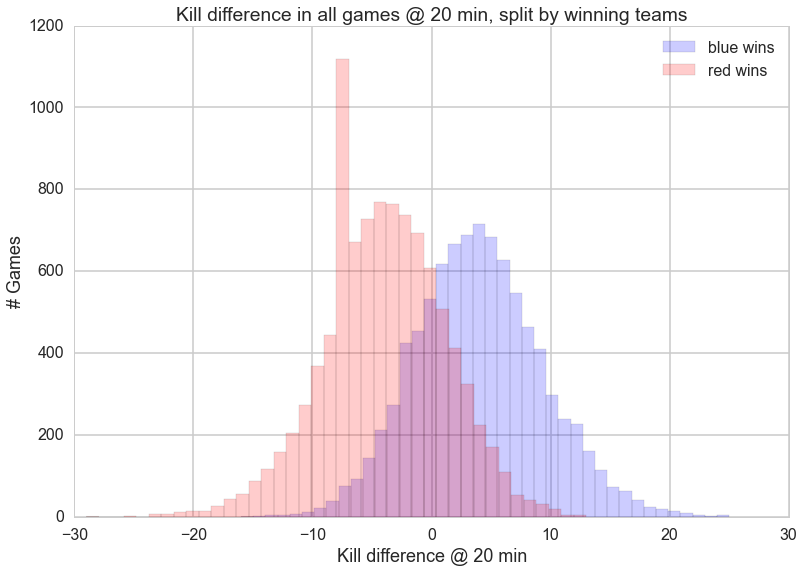

In [675]:
#all games, split by winning team
plt.hist(np.array(bluewins2['diffkill20']), bins = 40, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins2['diffkill20']), bins = 40, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Kill difference @ 20 min', fontsize = 18)
plt.title('Kill difference in all games @ 20 min, split by winning teams')
plt.legend()

Once again, bimodal peaks occurring. We aren't sure why there's a large spike in the red side kill difference at -8.

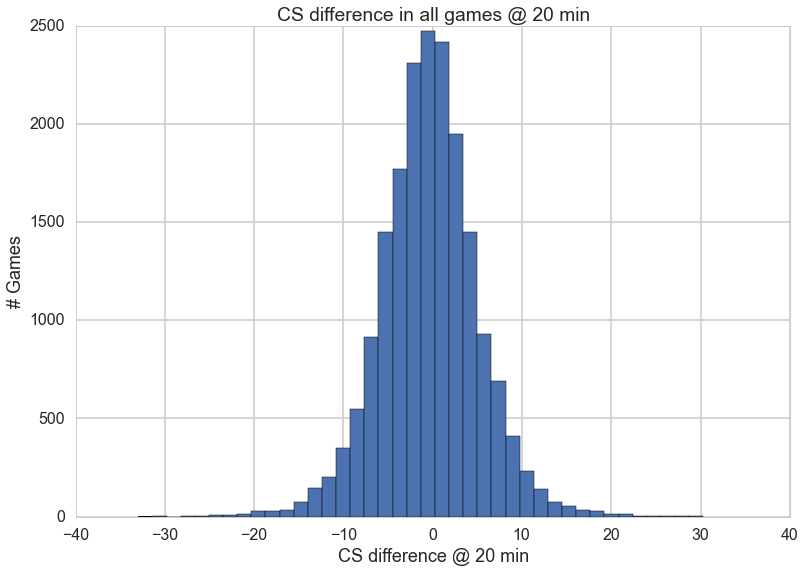

In [676]:
#all games
plt.hist(np.array(df2['diffcs20']), bins = 40)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('CS difference @ 20 min', fontsize = 18)
plt.title('CS difference in all games @ 20 min')

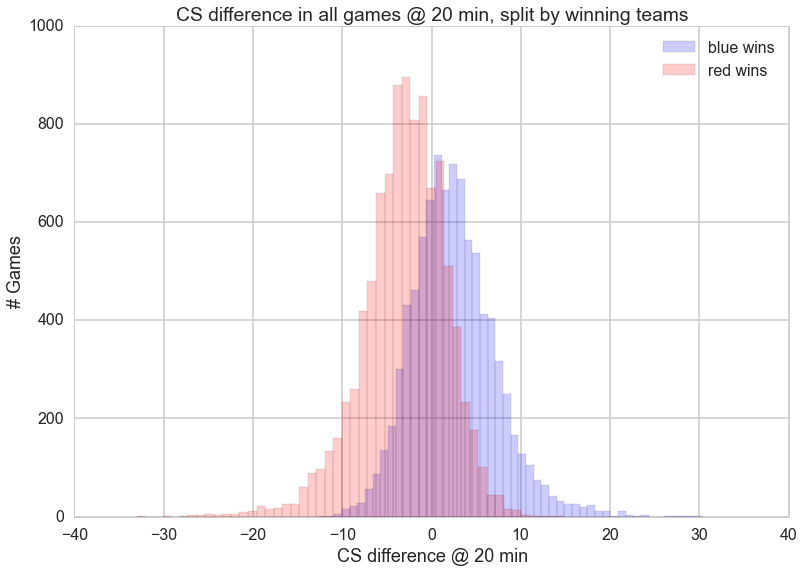

In [677]:
#all games, split by winning team
plt.hist(np.array(bluewins2['diffcs20']), bins = 50, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins2['diffcs20']), bins = 50, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.ylim((0,1000))
plt.xlabel('CS difference @ 20 min', fontsize = 18)
plt.title('CS difference in all games @ 20 min, split by winning teams')
plt.legend()

Notice how CS differences are much more pronounced at 20 minutes compared to the 10 minute mark, since teams that can CS well have more time to create a gap in the lead that they already had at 10 minutes.

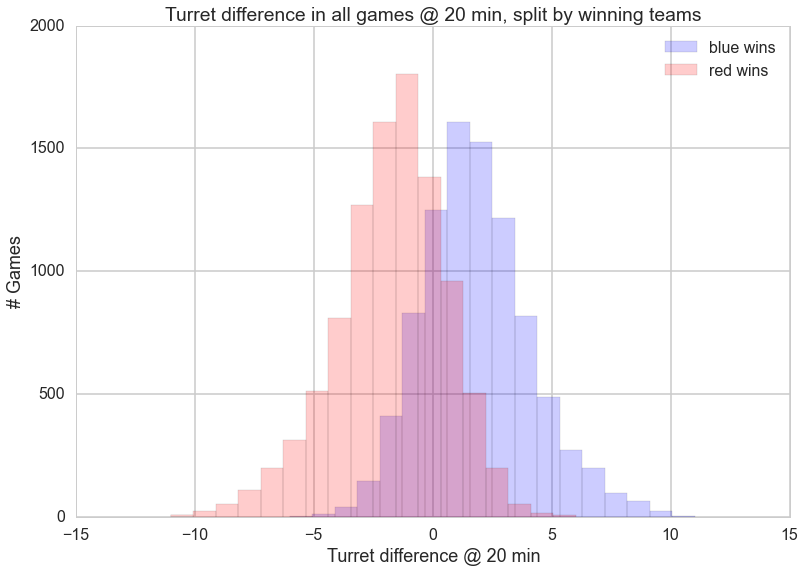

In [678]:
#all games, split by winning team
plt.hist(np.array(bluewins2['diffturret20']), bins = 18, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins2['diffturret20']), bins = 18, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Turret difference @ 20 min', fontsize = 18)
plt.title('Turret difference in all games @ 20 min, split by winning teams')
plt.legend()

From here on out we see less of a pronounced peak, as these variables are less influential for determining victories.

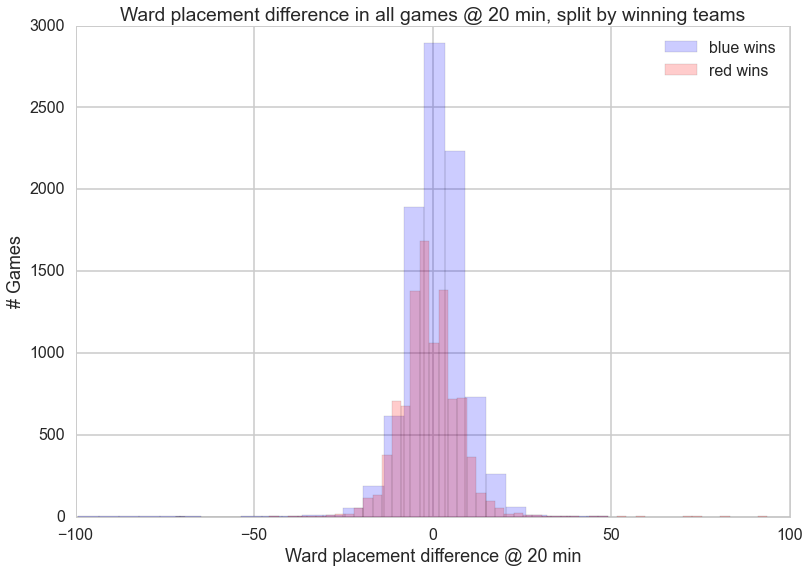

In [679]:
#all games, split by winning team
plt.hist(np.array(bluewins2['diffwardp20']), bins = 200, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins2['diffwardp20']), bins = 200, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlim((-100,100))
plt.xlabel('Ward placement difference @ 20 min', fontsize = 18)
plt.title('Ward placement difference in all games @ 20 min, split by winning teams')
plt.legend()

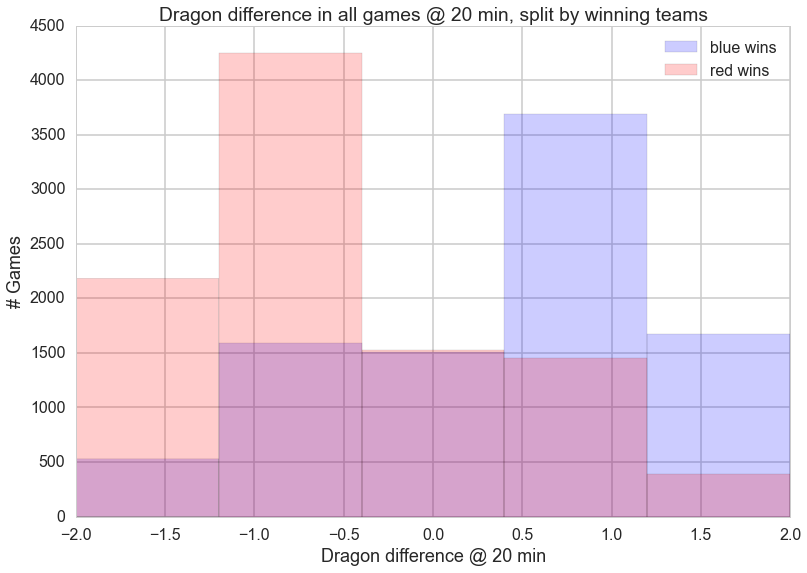

In [680]:
#all games, split by winning team
plt.hist(np.array(bluewins2['diffdrag20']), bins = 5, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins2['diffdrag20']), bins = 5, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Dragon difference @ 20 min', fontsize = 18)
plt.title('Dragon difference in all games @ 20 min, split by winning teams')
plt.legend()

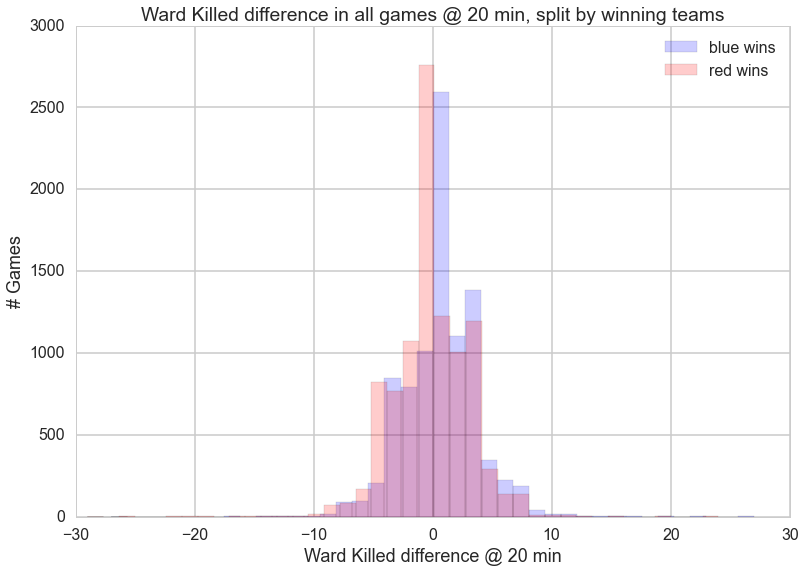

In [681]:
#all games, split by winning team
plt.hist(np.array(bluewins2['diffwardk20']), bins = 40, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins2['diffwardk20']), bins = 40, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Ward Killed difference @ 20 min', fontsize = 18)
plt.title('Ward Killed difference in all games @ 20 min, split by winning teams')
plt.legend()

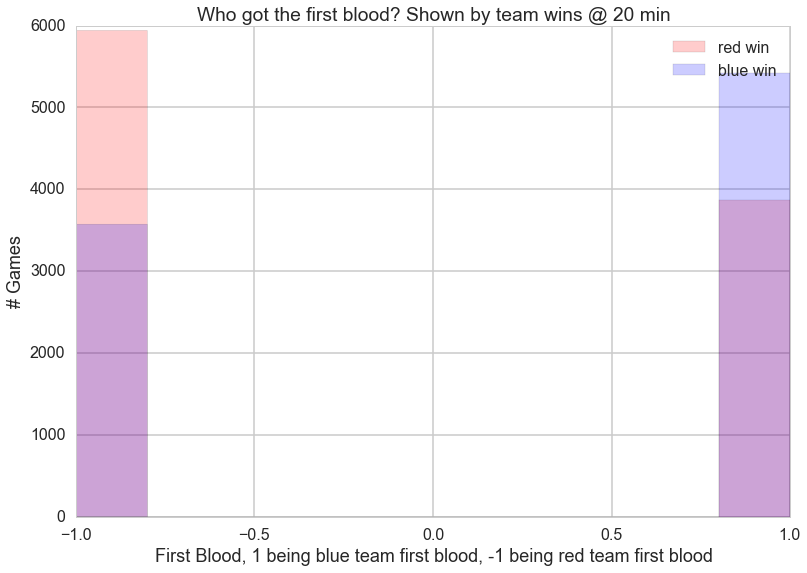

In [682]:
#all games, shown by team wins
plt.hist(np.array(redwins2['fb20l']), color = 'r', alpha = 0.2, label = "red win")
plt.hist(np.array(bluewins2['fb20l']), color = 'b', alpha = 0.2, label = "blue win")
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('First Blood, 1 being blue team first blood, -1 being red team first blood', fontsize = 18)
plt.title('Who got the first blood? Shown by team wins @ 20 min')
plt.legend()

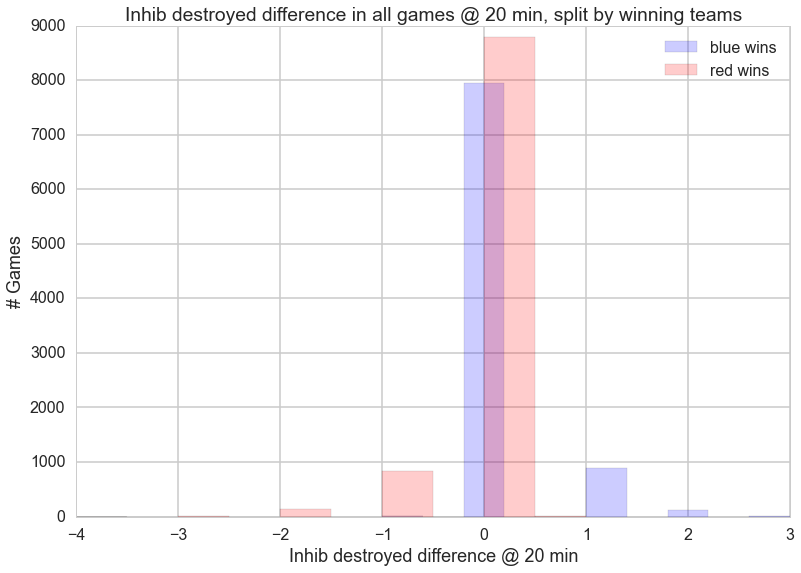

In [683]:
#all games, split by winning team
plt.hist(np.array(bluewins2['diffinhib20']), bins = 10, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins2['diffinhib20']), bins = 10, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Inhib destroyed difference @ 20 min', fontsize = 18)
plt.title('Inhib destroyed difference in all games @ 20 min, split by winning teams')
plt.legend()

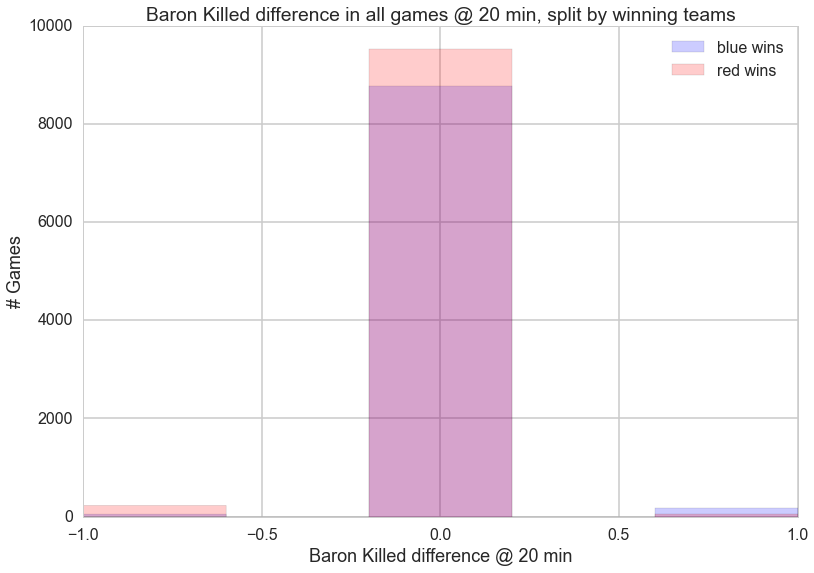

In [684]:
#all games, split by winning team
plt.hist(np.array(bluewins2['diffbaron20']), bins = 5, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins2['diffbaron20']), bins = 5, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Baron Killed difference @ 20 min', fontsize = 18)
plt.title('Baron Killed difference in all games @ 20 min, split by winning teams')
plt.legend()

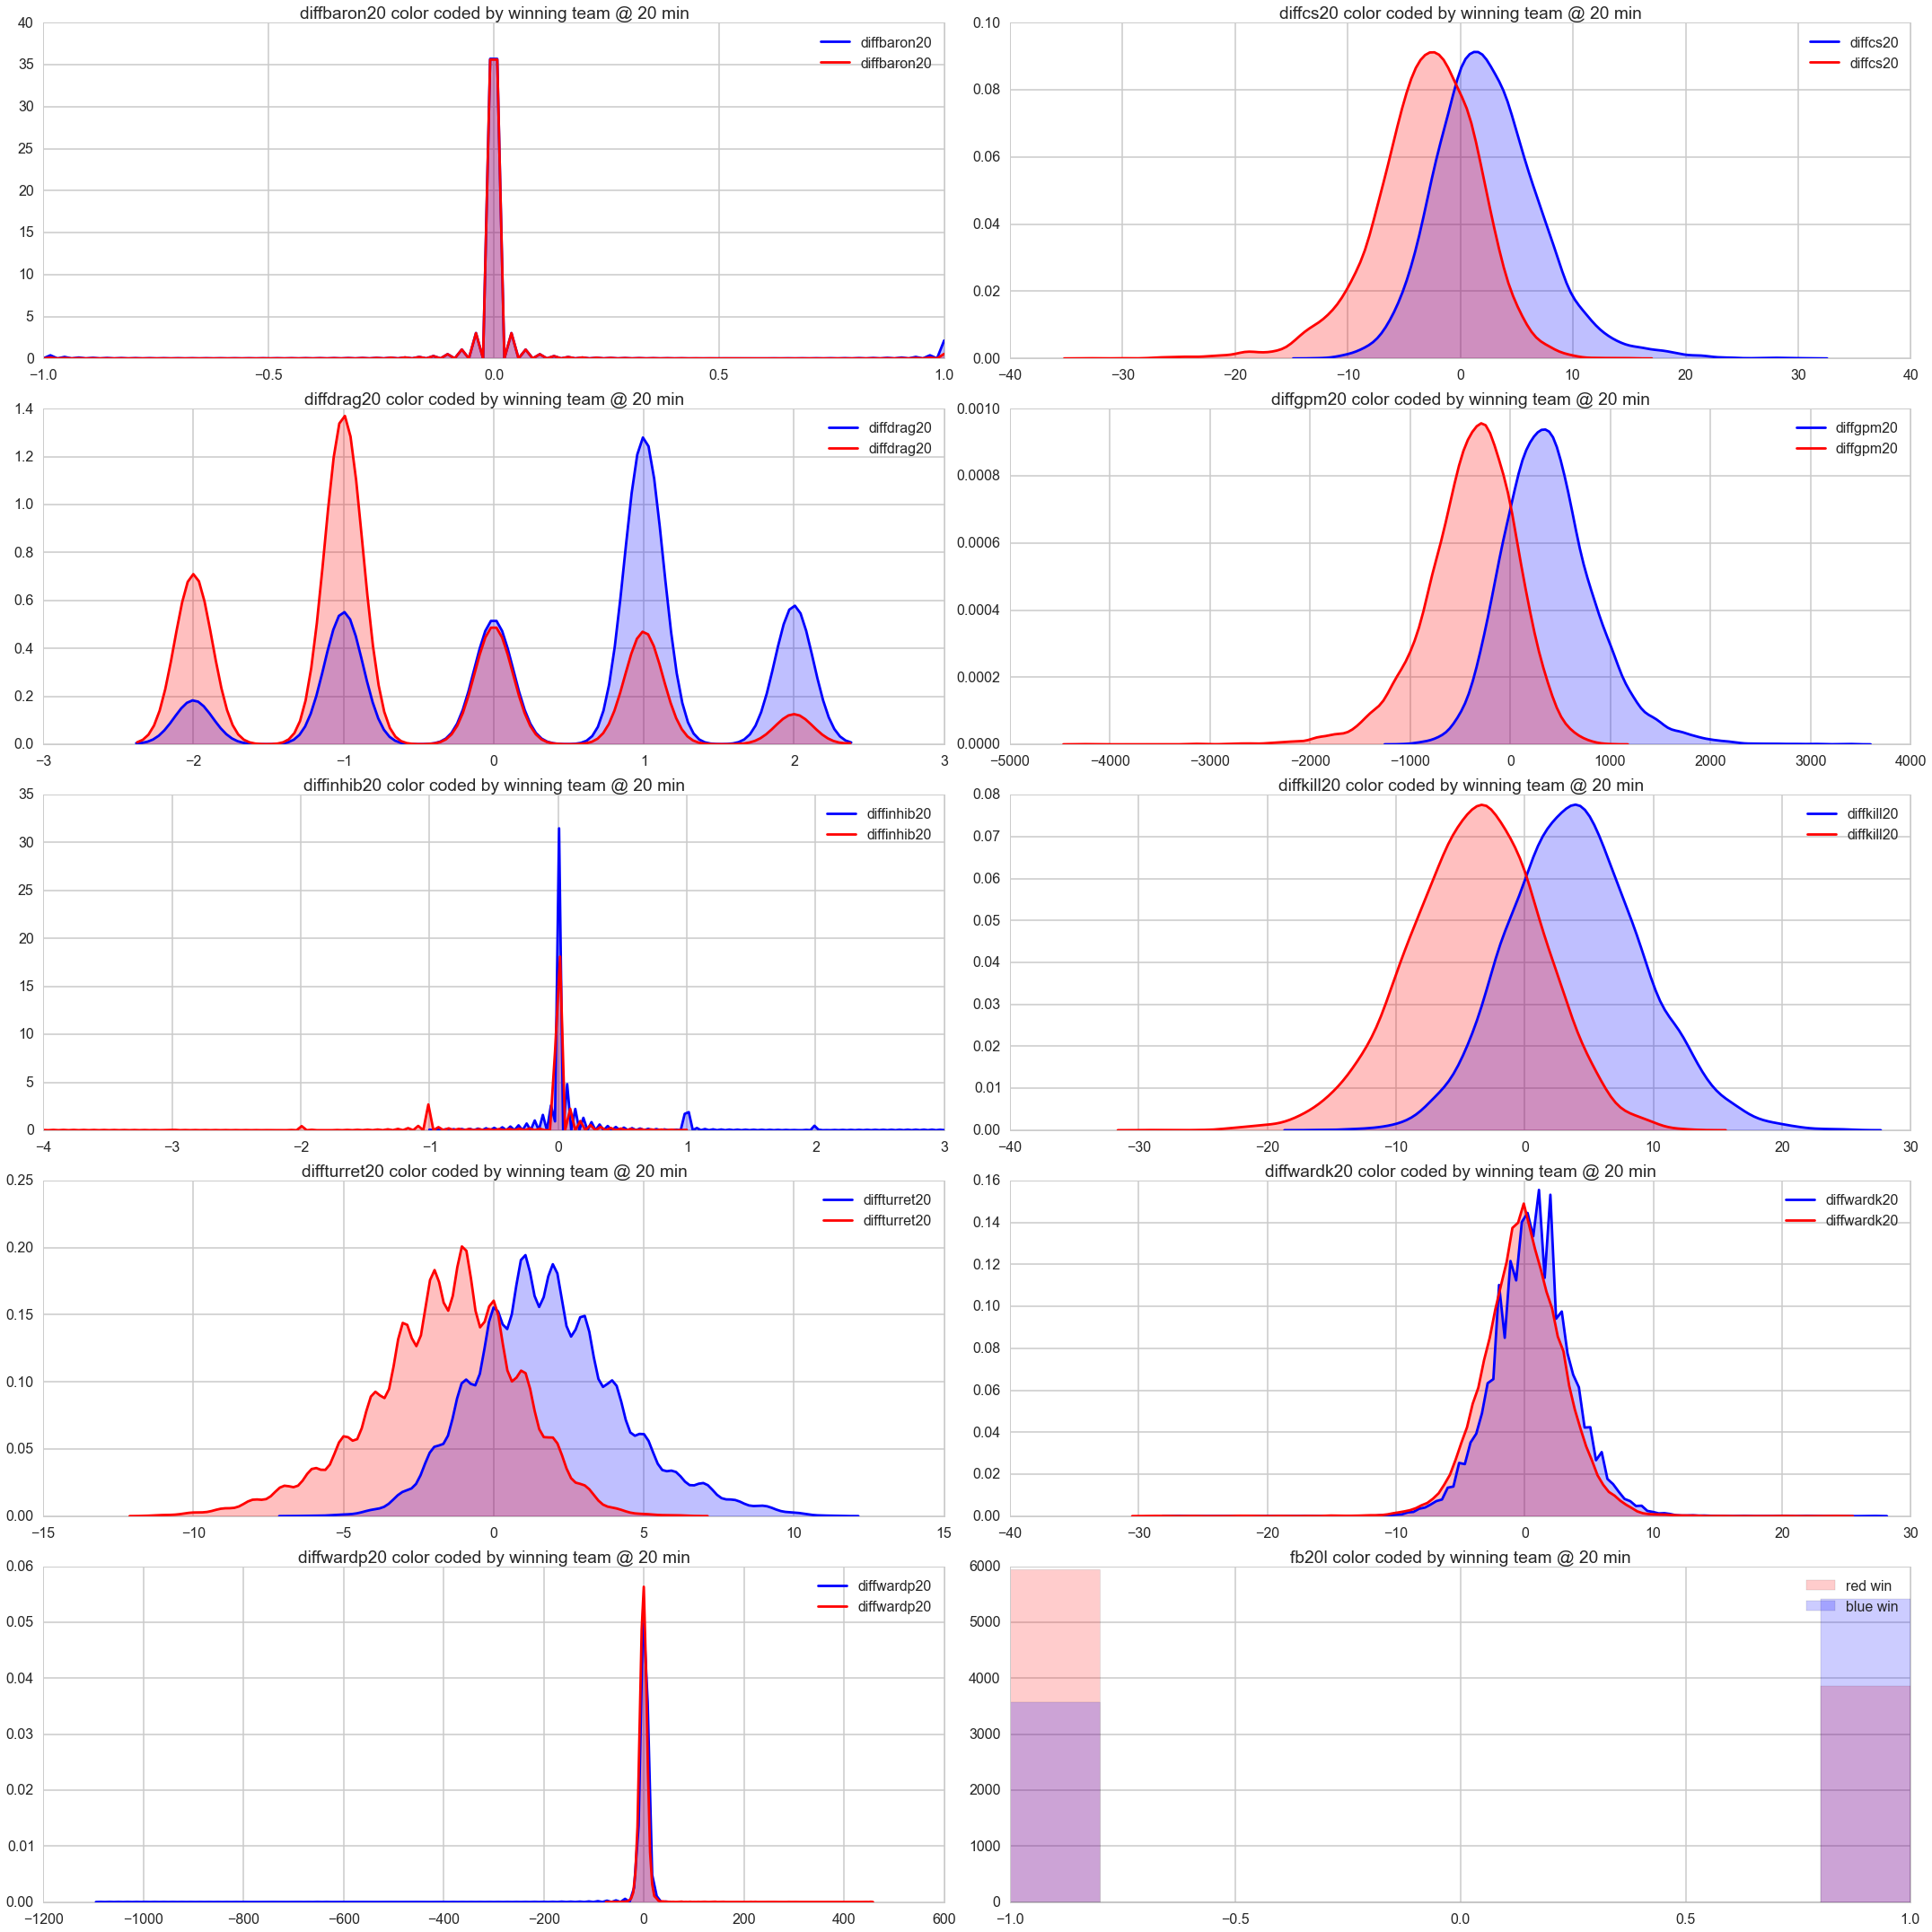

In [758]:
fig, axes = plt.subplots(5,2, figsize = (30,30), tight_layout = True)
for ax, col in zip(axes.ravel(), lcols2):
    if "diff" in col:
        sns.kdeplot(bluewins2[col], ax = ax, legend = True, shade = True, color = 'b')
        sns.kdeplot(redwins2[col], ax = ax, legend = True, shade = True, color = 'r')
    else:
        ax.hist(np.array(redwins2[col]), color = 'r', alpha = 0.2, label = "red win")
        ax.hist(np.array(bluewins2[col]), color = 'b', alpha = 0.2, label = "blue win")
        ax.legend()
    ax.set_title(col + ' color coded by winning team @ 20 min')

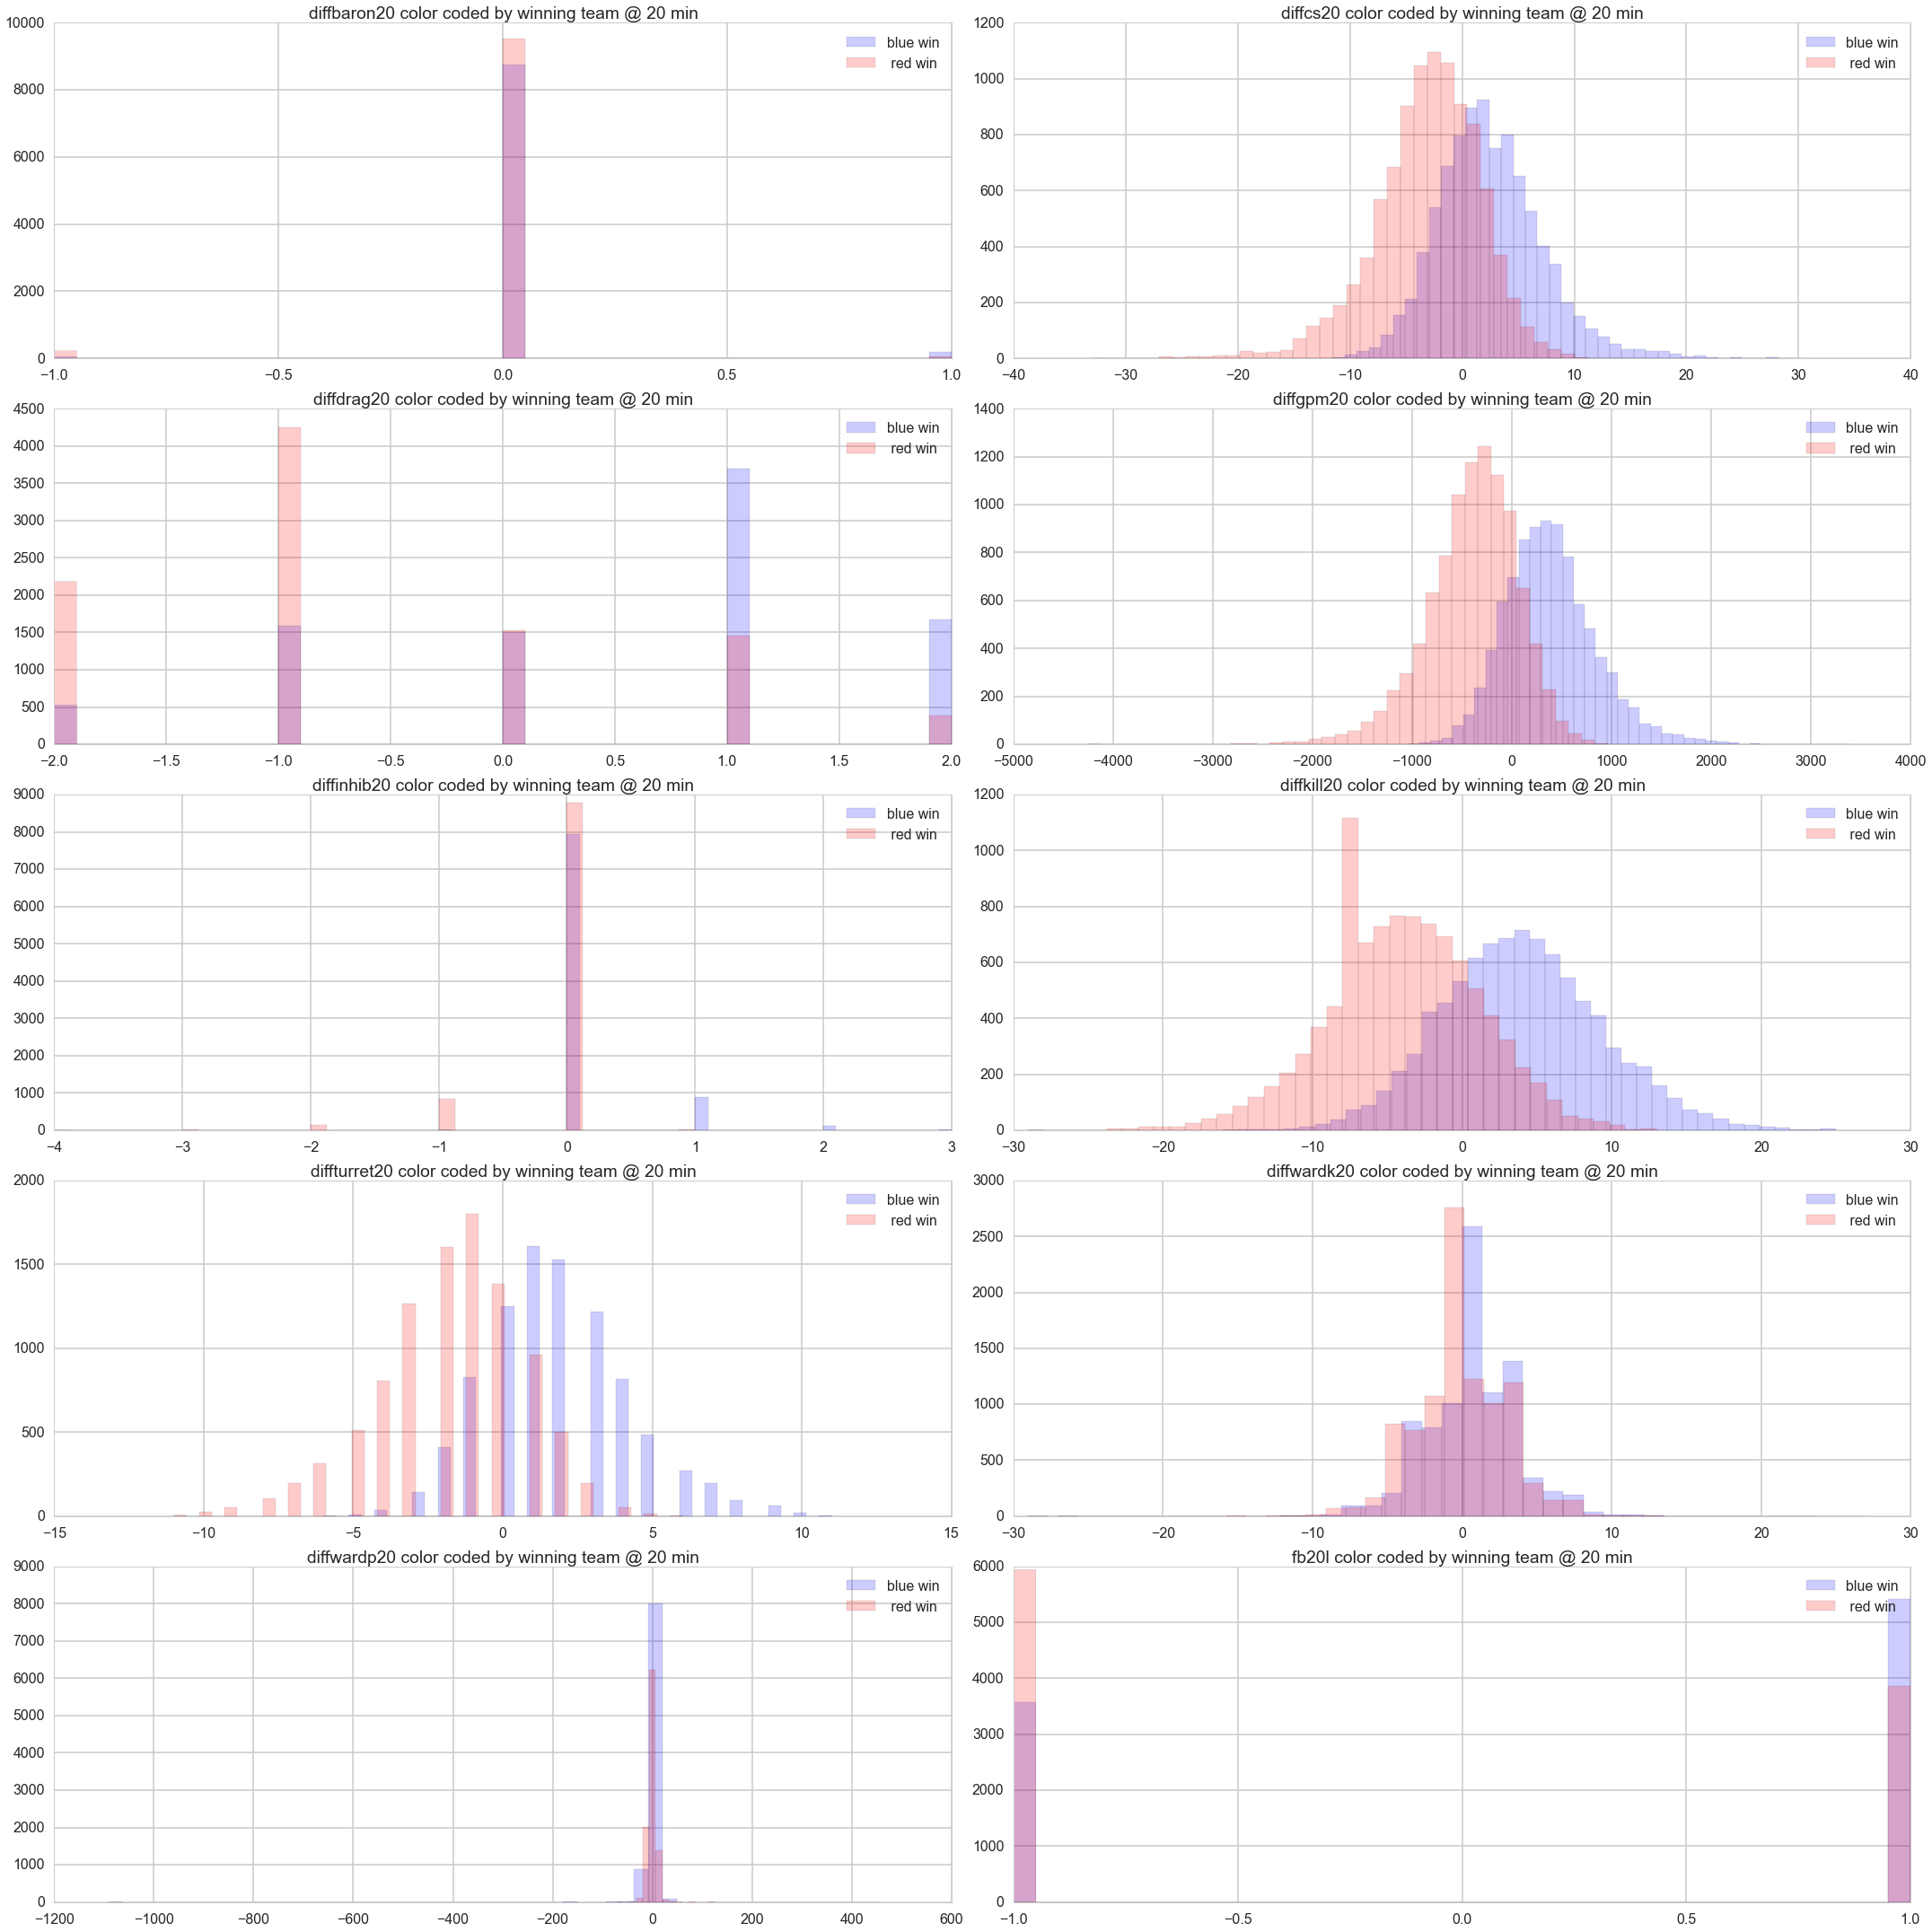

In [765]:
fig, axes = plt.subplots(5,2, figsize = (30,30), tight_layout = True)
for ax, col in zip(axes.ravel(), lcols2):
    ax.hist(np.array(bluewins2[col]), bins = 40, color = 'b', alpha = 0.2, label = "blue win")
    ax.hist(np.array(redwins2[col]), bins = 40,  color = 'r', alpha = 0.2, label = " red win")
    ax.legend()
    ax.set_title(col + ' color coded by winning team @ 20 min')

<h3> Overall analysis of @20 data: </h3>Compared to the @10 data, most of the factors were more pronounced in their horizontal shifts away from 0 depending on the winning team. Most noticably, the number of kills became a large factor in predicting wins compared to before (reason for this is explained above). Following the trend of @10 data, gold is still important, while CS, turrets, and dragons all have more say in who is going to win. 

<h3> 30 minute dataframe </h3>
Last but not least, we'll do the same process for the @30 data.

In [685]:
#new Random forest classifier for 30 min
newForest3 = RandomForestClassifier()

In [686]:
#30 min variables to test
lcols3 = list(df3.columns.values)
#win is the response we want to test for
lcols3.remove('win')
lcols3

['diffbaron30',
 'diffcs30',
 'diffdrag30',
 'diffgpm30',
 'diffinhib30',
 'diffkill30',
 'diffturret30',
 'diffwardk30',
 'diffwardp30',
 'fb30l']

In [687]:
itrain4, itest4 = train_test_split(xrange(df3.shape[0]), train_size=0.75)

mask=np.ones(df3.shape[0], dtype='int')
mask[itrain4]=1
mask[itest4]=0
mask = (mask==1)
mask=np.ones(df3.shape[0], dtype='int')
mask[itrain4]=1
mask[itest4]=0
mask = (mask==1)

In [688]:
#We want a lot of trees 
parameters = {"n_estimators": range(1, 100)}
##We use the same mask values from the previous part since 1) the matches are the same, just different data and
##2) we want the same training and test matchids when doing do_classify
newForest3, Xtrain3, ytrain3, Xtest3, ytest3 = do_classify(newForest3, parameters, 
                                                       df3, lcols3, 'win', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 91} 0.880938176042 [mean: 0.83021, std: 0.01381, params: {'n_estimators': 1}, mean: 0.81160, std: 0.01139, params: {'n_estimators': 2}, mean: 0.85141, std: 0.01059, params: {'n_estimators': 3}, mean: 0.84867, std: 0.01076, params: {'n_estimators': 4}, mean: 0.86392, std: 0.00693, params: {'n_estimators': 5}, mean: 0.85894, std: 0.00807, params: {'n_estimators': 6}, mean: 0.86838, std: 0.00496, params: {'n_estimators': 7}, mean: 0.86300, std: 0.00625, params: {'n_estimators': 8}, mean: 0.86883, std: 0.01010, params: {'n_estimators': 9}, mean: 0.86426, std: 0.00626, params: {'n_estimators': 10}, mean: 0.87007, std: 0.00796, params: {'n_estimators': 11}, mean: 0.87049, std: 0.01152, params: {'n_estimators': 12}, mean: 0.87054, std: 0.00992, params: {'n_estimators': 13}, mean: 0.87242, std: 0.00850, params: {'n_estimators': 14}, mean: 0.87240, std: 0.00898, params: {'n_estimators': 15}, mean: 0.86877, std: 0.00849, params: {'n_estimators': 16}, mean: 0.87381, std: 0.0

89% is yet another ~10% increase from the previous dataset. With a near 90 percent accuracy rating on predictions, we are very much nearing the near-perfect accuracy that random forest with post-game data had produced. 

In [695]:
#Optimized is 91 trees
newForest3

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=91, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [696]:
#get importances at 30 min
imp3 = newForest3.feature_importances_

In [697]:
imp3_sort, lcols3_sort = zip(*sorted(zip(imp3, lcols3)))

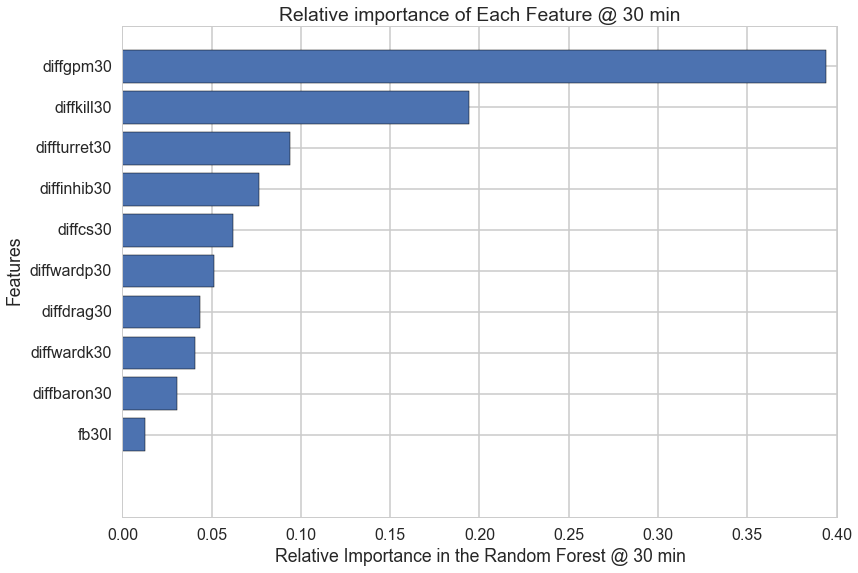

In [698]:
plt.barh(range(len(lcols3_sort)),imp3_sort,align='center')
plt.yticks(range(len(lcols3_sort)),lcols3_sort)
plt.xlabel('Relative Importance in the Random Forest @ 30 min')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature @ 30 min')
plt.show()

Unsurprisingly, gold becomes ever important. By the 30 miunte mark, however, some noticable trends start to occur. The importance of kills is still second, but towers and inhibitors now trump CS differences come late game.
Why is this the case? By the 30 minute mark, we have reached what is known as mid/late game. In this phase, teams are no longer focused on getting stronger by farming, but rather are focused on working as a team to 1) defeat the enemy team so that they can 2) take down buildings. Remember that the win-condition in League of Legends is taking down the Nexus, which is only possible if turrets and inhibitors falls first. Accordingly, the most important statistic when it comes to the mid/late game (after gold and kills) are the building counts. 

Observing individual variables split by which side won also shows a clear indication that all variables have become much more pronounced in peaks and significance compared to previous @10 and @20 data. The only variable whose predictive power is stronger at the @20 mark is CS. This is explained by the fact that CS is less important in the mid/late game where teamfights and objectives dominate the game. Farming up creeps won't help the team push towards victory; if someone is farming and that leads his/her team to fight a 4v5 and lose, the overall net result is a loss for that team.

In [699]:
#spliting into blue and red wins to help us visualize
bluewins3 = df3.query('win == True')
redwins3 = df3.query('win == False')

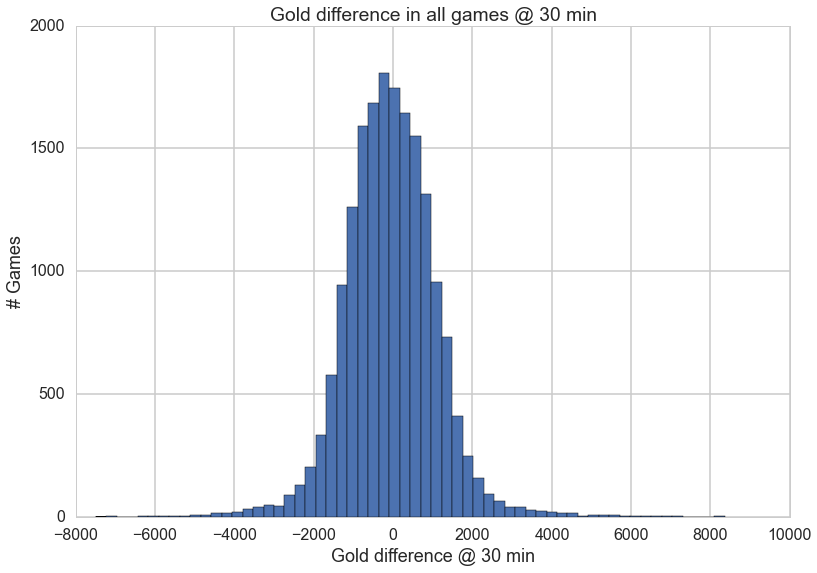

In [700]:
#all games
plt.hist(np.array(df3['diffgpm30']), bins = 60)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Gold difference @ 30 min', fontsize = 18)
plt.title('Gold difference in all games @ 30 min')

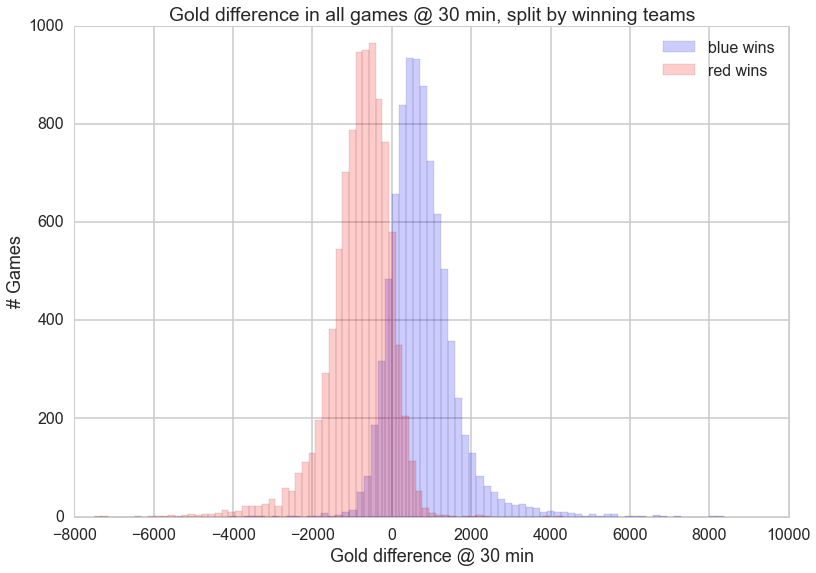

In [701]:
#all games, split by winning team
plt.hist(np.array(bluewins3['diffgpm30']), bins = 70, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins3['diffgpm30']), bins = 70, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Gold difference @ 30 min', fontsize = 18)
plt.title('Gold difference in all games @ 30 min, split by winning teams')
plt.legend()

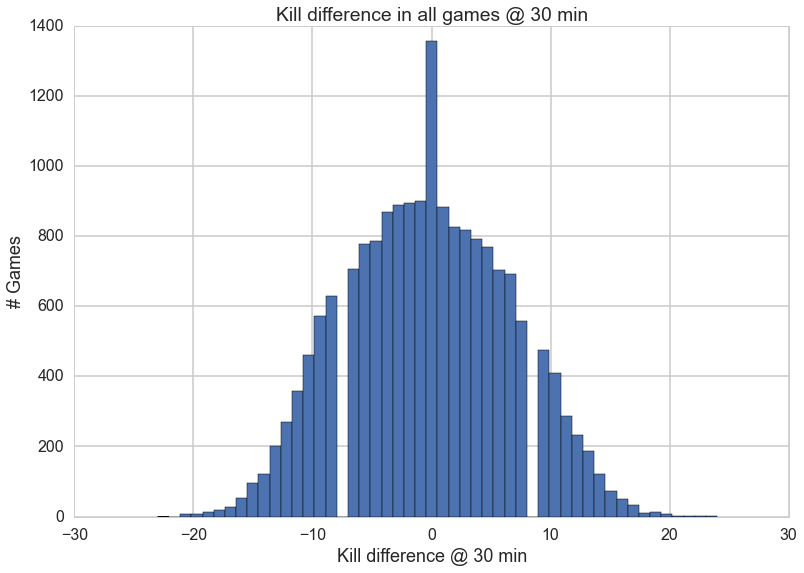

In [702]:
#all games
plt.hist(np.array(df3['diffkill30']), bins = 50)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Kill difference @ 30 min', fontsize = 18)
plt.title('Kill difference in all games @ 30 min')

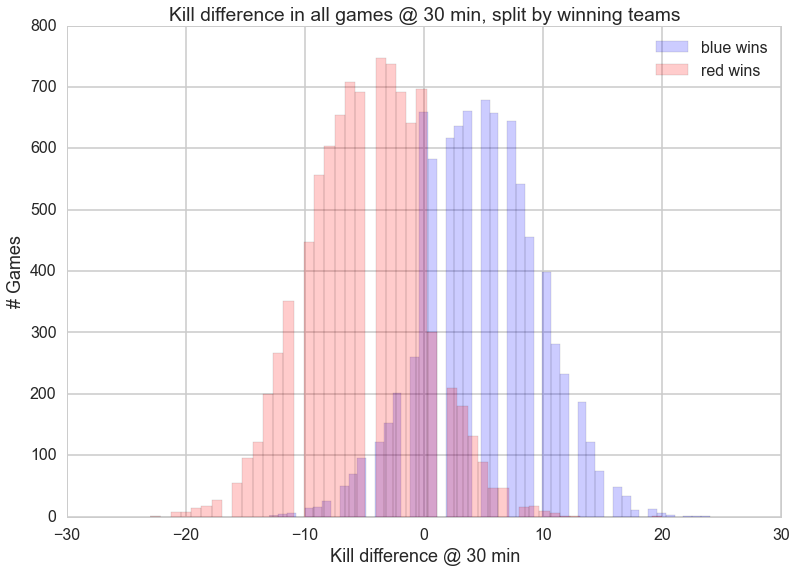

In [703]:
#all games, split by winning team
plt.hist(np.array(bluewins3['diffkill30']), bins = 50, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins3['diffkill30']), bins = 50, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Kill difference @ 30 min', fontsize = 18)
plt.title('Kill difference in all games @ 30 min, split by winning teams')
plt.legend()

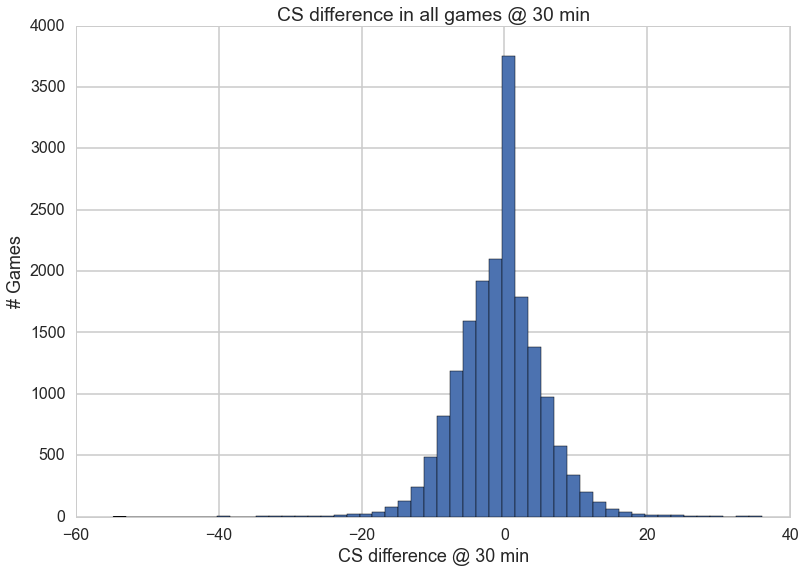

In [704]:
#all games
plt.hist(np.array(df3['diffcs30']), bins = 50)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('CS difference @ 30 min', fontsize = 18)
plt.title('CS difference in all games @ 30 min')

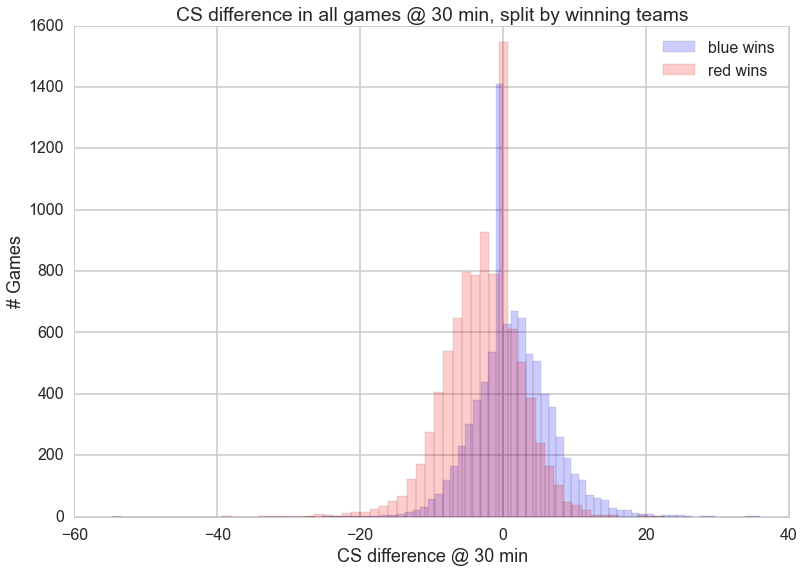

In [705]:
#all games, split by winning team
plt.hist(np.array(bluewins3['diffcs30']), bins = 60, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins3['diffcs30']), bins = 60, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('CS difference @ 30 min', fontsize = 18)
plt.title('CS difference in all games @ 30 min, split by winning teams')
plt.legend()

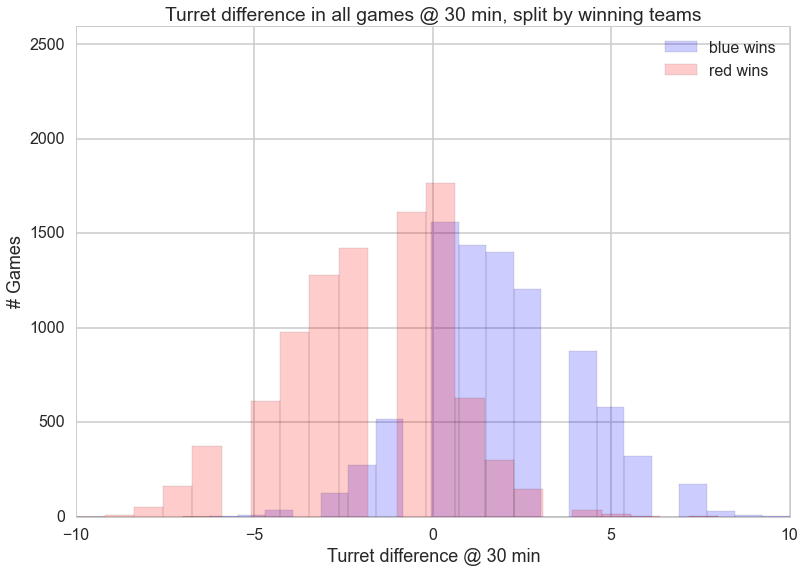

In [706]:
#all games, split by winning team
plt.hist(np.array(bluewins3['diffturret30']), bins = 22, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins3['diffturret30']), bins = 22, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.ylim((0,2600))
plt.xlabel('Turret difference @ 30 min', fontsize = 18)
plt.title('Turret difference in all games @ 30 min, split by winning teams')
plt.legend()

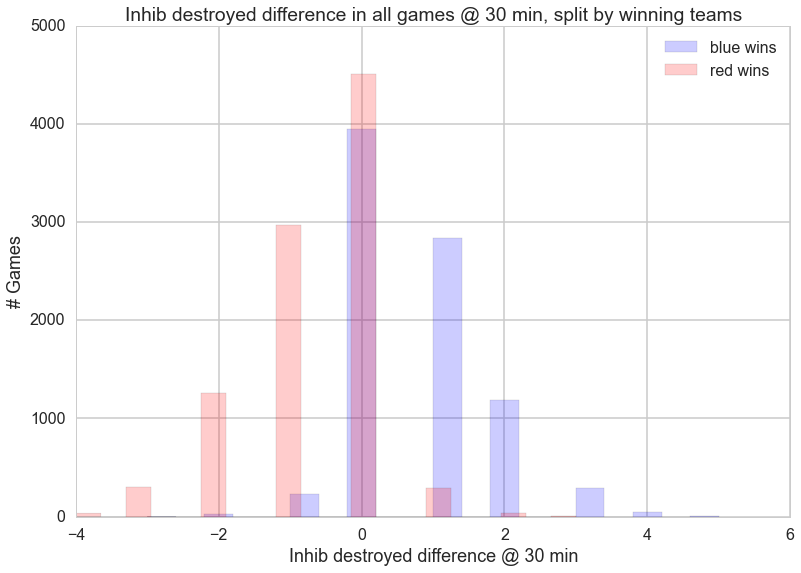

In [707]:
#all games, split by winning team
plt.hist(np.array(bluewins3['diffinhib30']), bins = 20, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins3['diffinhib30']), bins = 20, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Inhib destroyed difference @ 30 min', fontsize = 18)
plt.title('Inhib destroyed difference in all games @ 30 min, split by winning teams')
plt.legend()

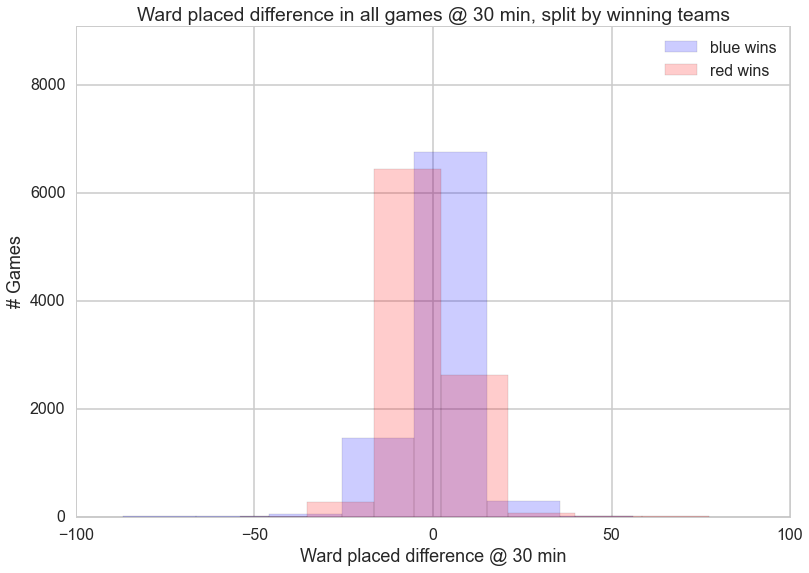

In [708]:
#all games, split by winning team
plt.hist(np.array(bluewins3['diffwardp30']), bins = 50, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins3['diffwardp30']), bins = 30, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlim((-100,100))
plt.ylim((0,9100))
plt.xlabel('Ward placed difference @ 30 min', fontsize = 18)
plt.title('Ward placed difference in all games @ 30 min, split by winning teams')
plt.legend()

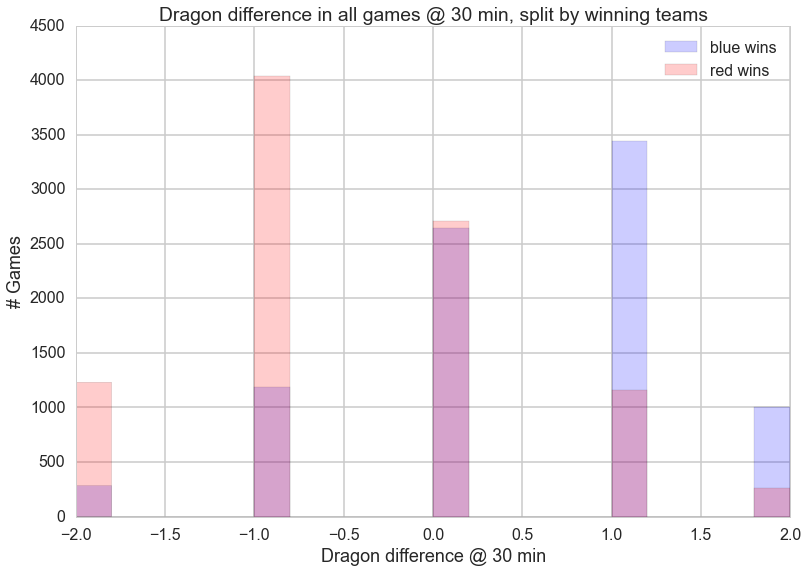

In [709]:
#all games, split by winning team
plt.hist(np.array(bluewins3['diffdrag30']), bins = 20, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins3['diffdrag30']), bins = 20, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Dragon difference @ 30 min', fontsize = 18)
plt.title('Dragon difference in all games @ 30 min, split by winning teams')
plt.legend()

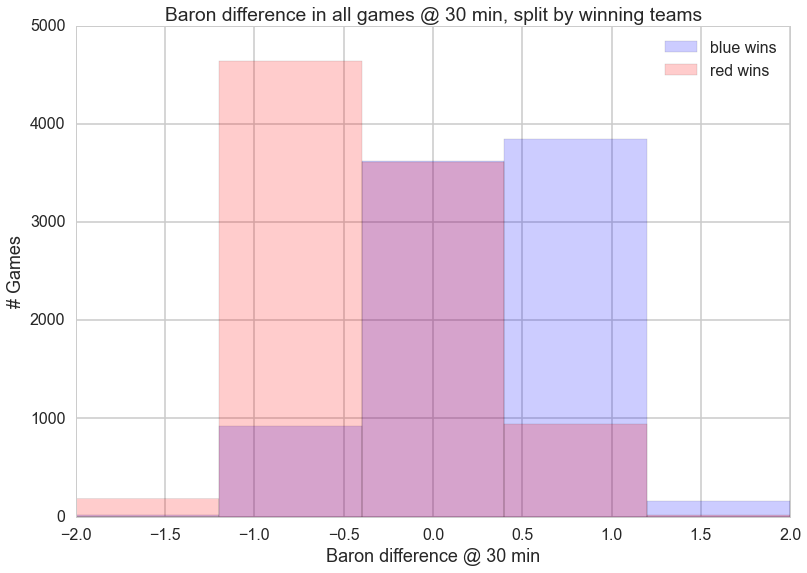

In [710]:
#all games, split by winning team
plt.hist(np.array(bluewins3['diffbaron30']), bins = 5, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins3['diffbaron30']), bins = 5, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Baron difference @ 30 min', fontsize = 18)
plt.title('Baron difference in all games @ 30 min, split by winning teams')
plt.legend()

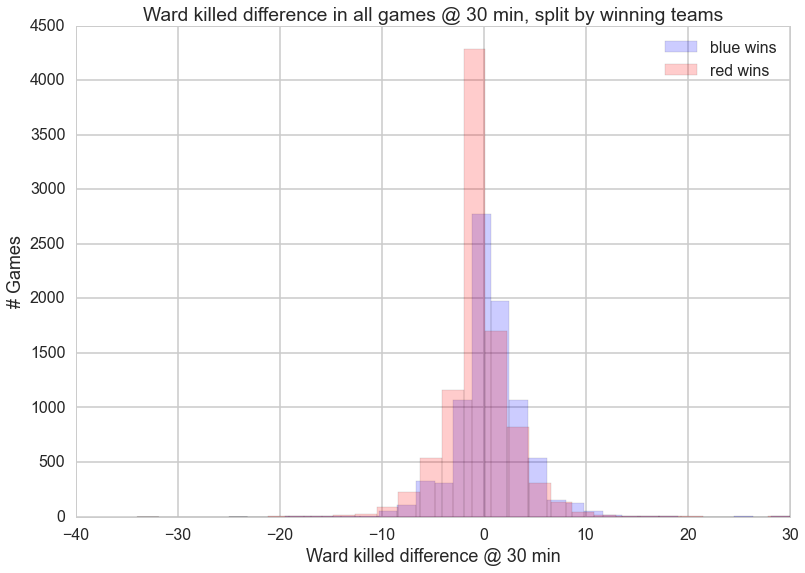

In [711]:
#all games, split by winning team
plt.hist(np.array(bluewins3['diffwardk30']), bins = 30, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins3['diffwardk30']), bins = 30, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Ward killed difference @ 30 min', fontsize = 18)
plt.title('Ward killed difference in all games @ 30 min, split by winning teams')
plt.legend()

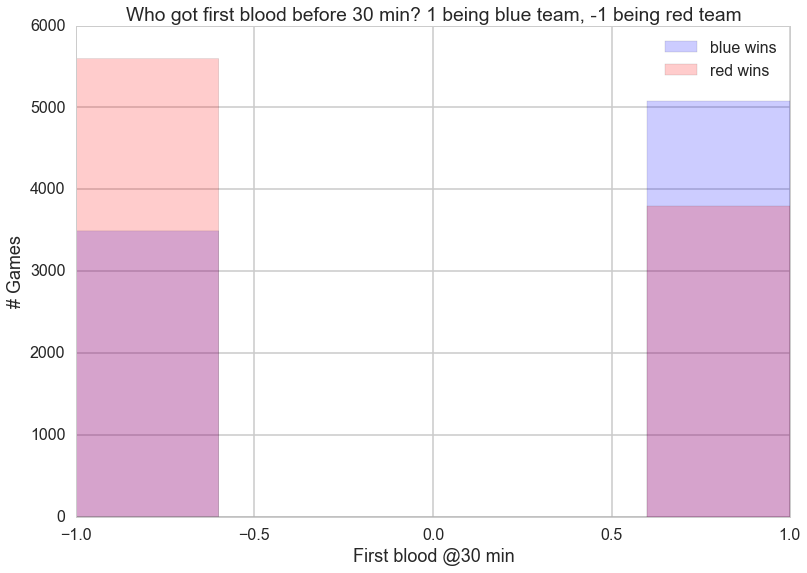

In [712]:
#all games, split by winning team
plt.hist(np.array(bluewins3['fb30l']), bins = 5, color = 'b', alpha = 0.2, label = "blue wins") 
plt.hist(np.array(redwins3['fb30l']), bins = 5, color = 'r', alpha = 0.2, label = "red wins") 
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('First blood @30 min', fontsize = 18)
plt.title('Who got first blood before 30 min? 1 being blue team, -1 being red team')
plt.legend()

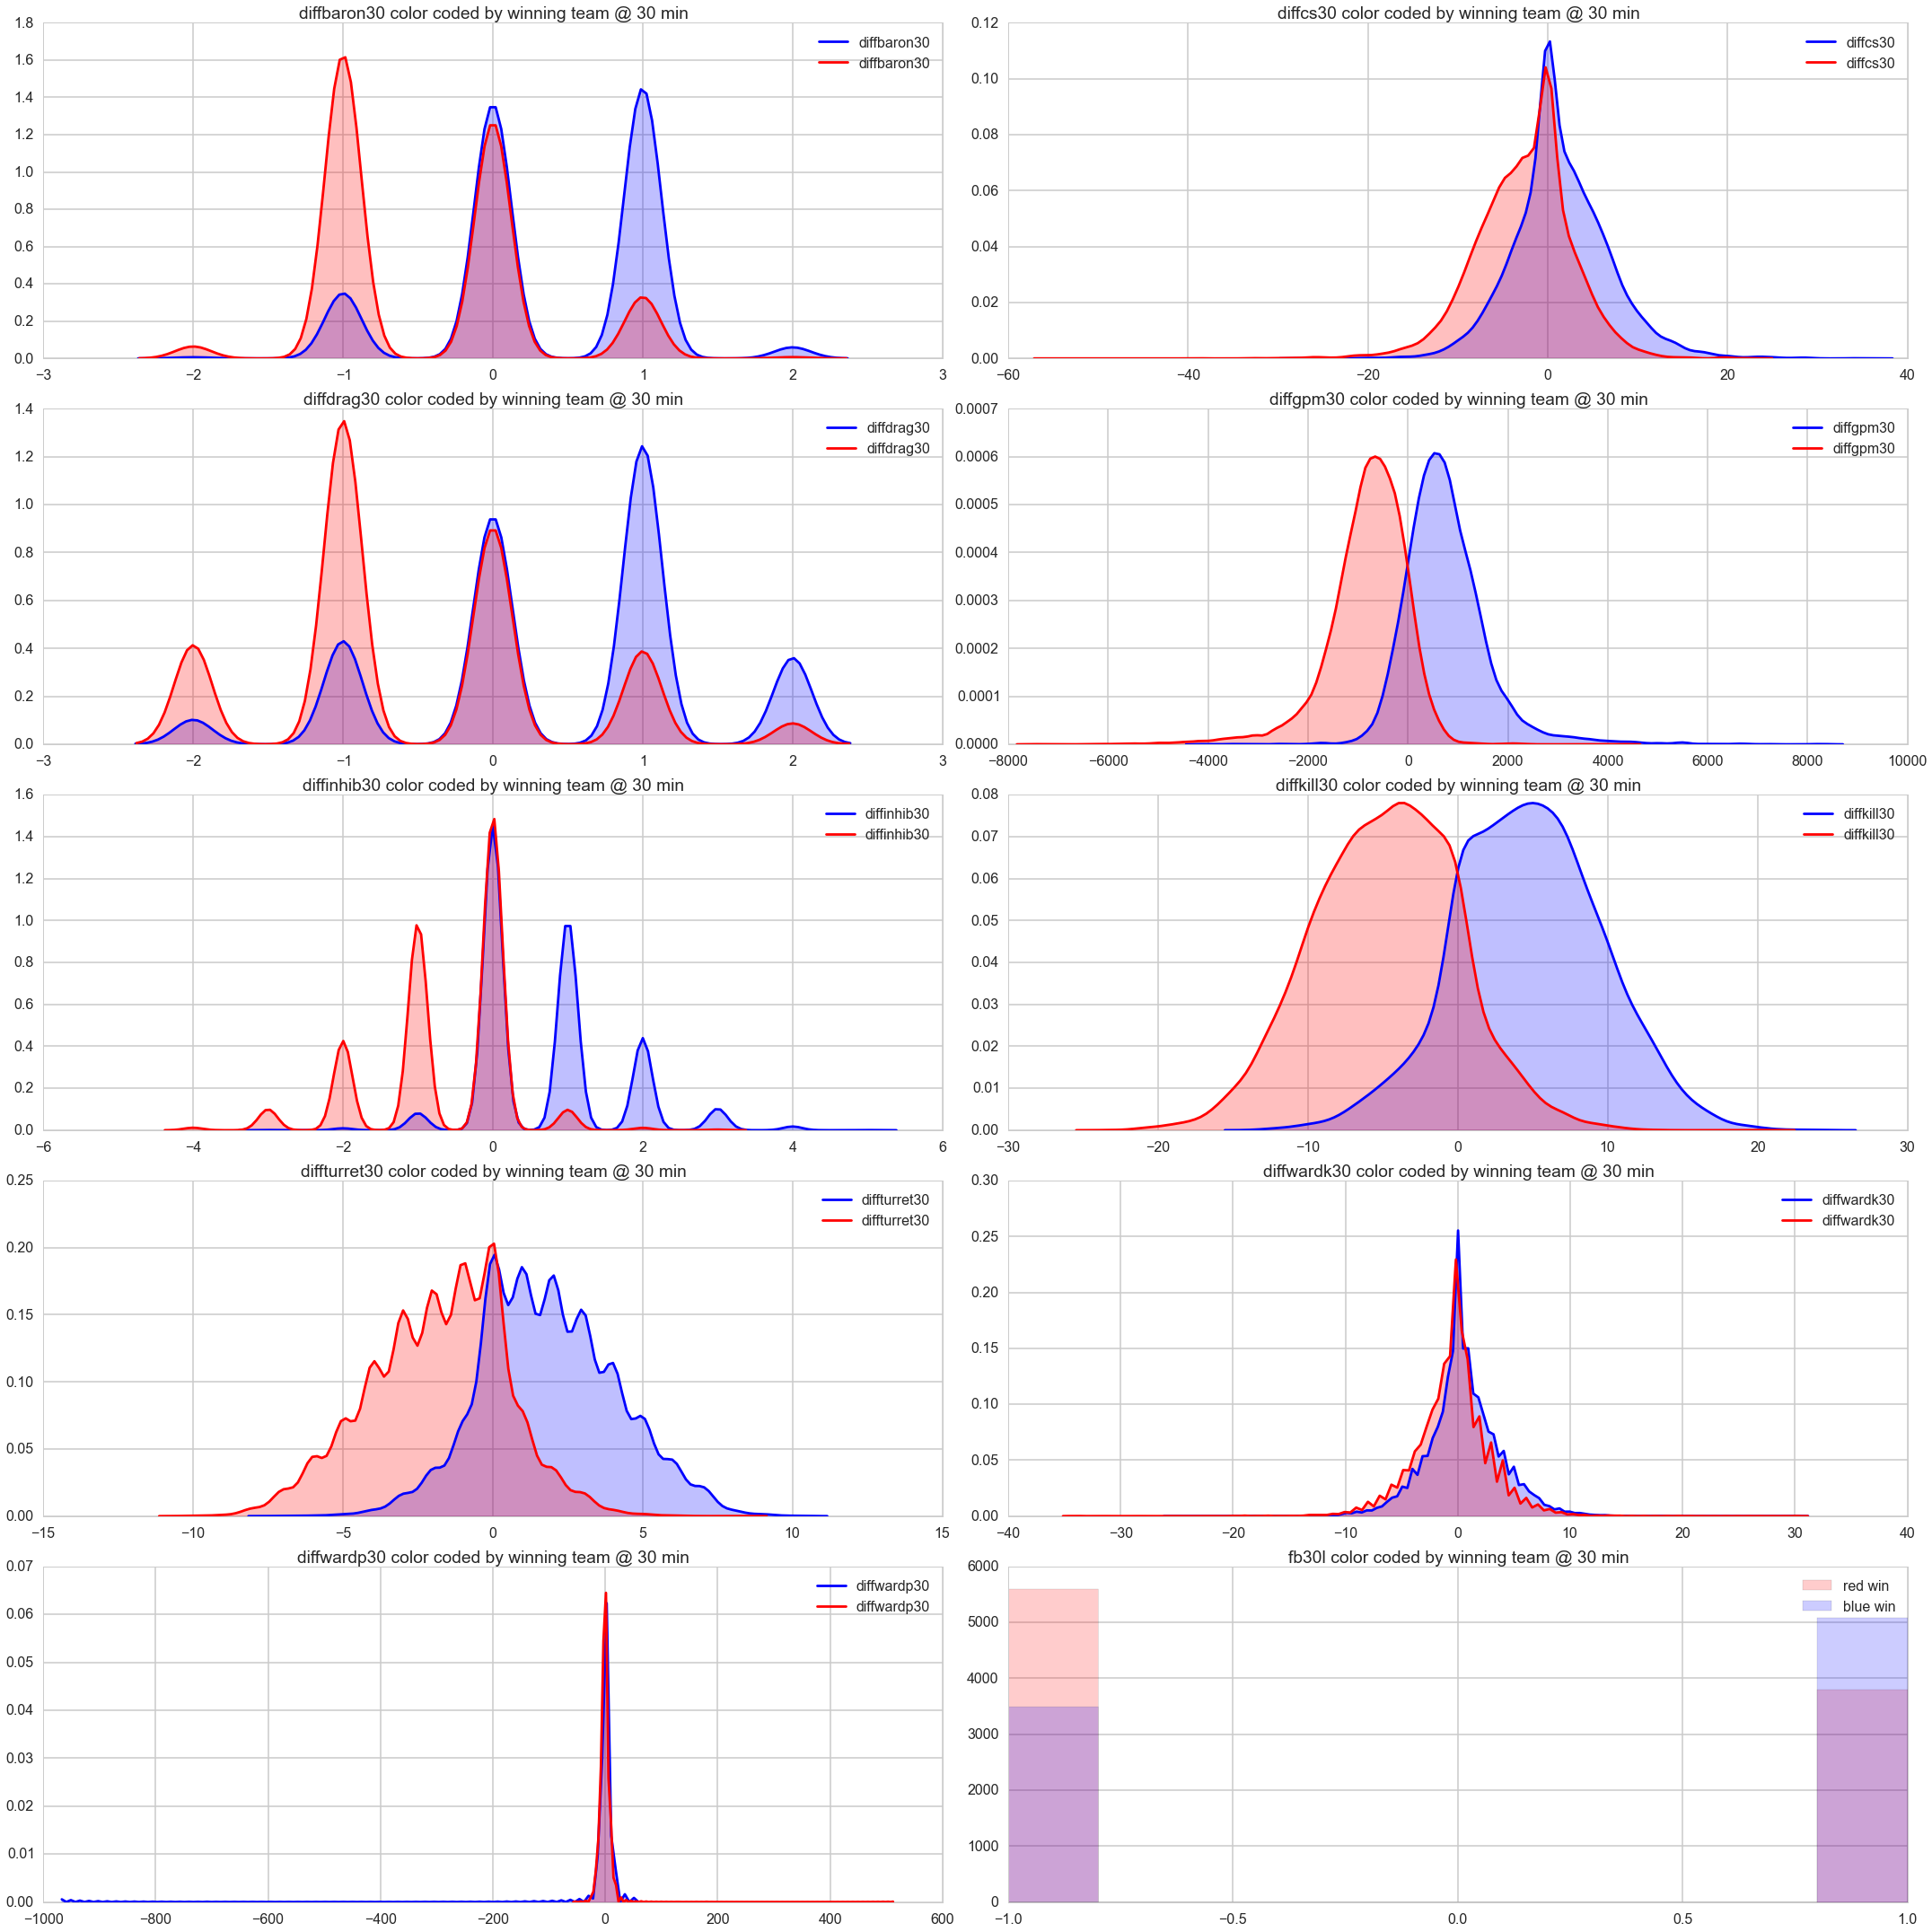

In [766]:
fig, axes = plt.subplots(5,2, figsize = (30,30), tight_layout = True)
for ax, col in zip(axes.ravel(), lcols3):
    if "diff" in col:
        sns.kdeplot(bluewins3[col], ax = ax, legend = True, shade = True, color = 'b')
        sns.kdeplot(redwins3[col], ax = ax, legend = True, shade = True, color = 'r')
    else:
        ax.hist(np.array(redwins3[col]), color = 'r', alpha = 0.2, label = "red win")
        ax.hist(np.array(bluewins3[col]), color = 'b', alpha = 0.2, label = "blue win")
        ax.legend()
    ax.set_title(col + ' color coded by winning team @ 30 min')

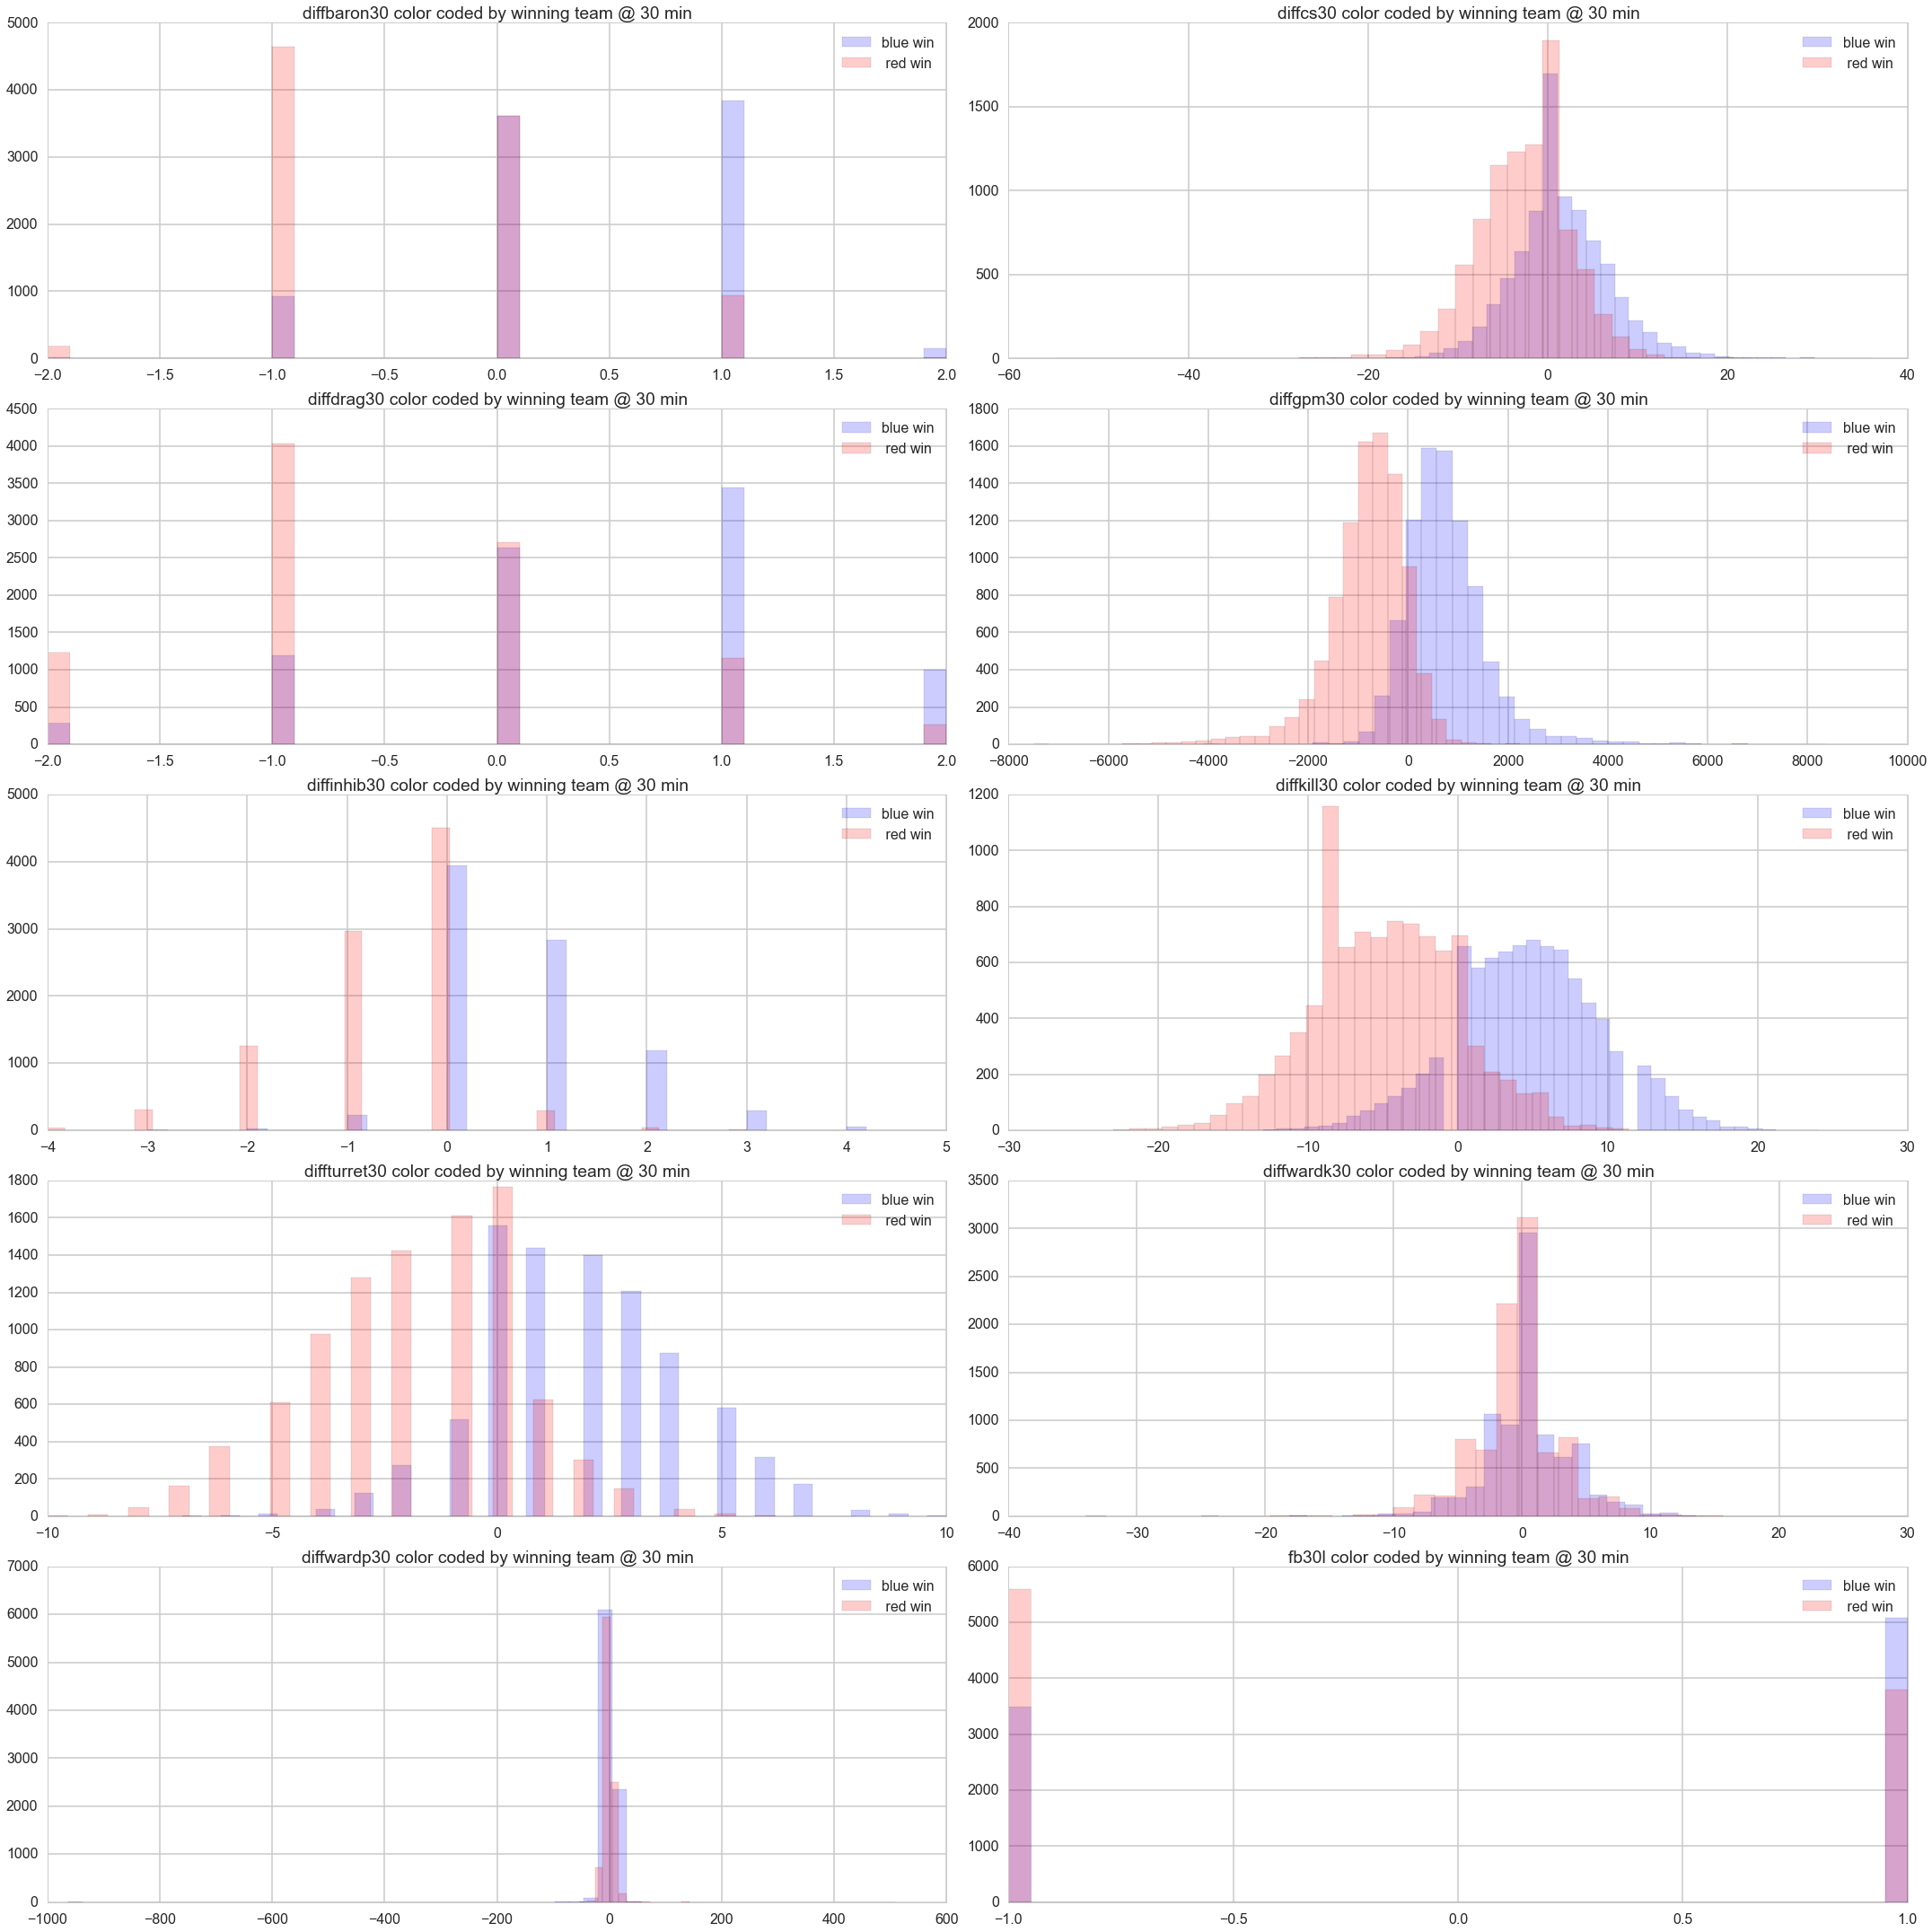

In [767]:
fig, axes = plt.subplots(5,2, figsize = (30,30), tight_layout = True)
for ax, col in zip(axes.ravel(), lcols3):
    ax.hist(np.array(bluewins3[col]), bins = 40, color = 'b', alpha = 0.2, label = "blue win")
    ax.hist(np.array(redwins3[col]), bins = 40,  color = 'r', alpha = 0.2, label = " red win")
    ax.legend()
    ax.set_title(col + ' color coded by winning team @ 30 min')

<h3> Overall Analysis of the @30 Data: </h3> Unsurprisingly, gold and kills are still the two most important factors in predicting wins. After those two factors, however, it becomes abundantly clear the objectives are the main focal point of the game. Winning teams are more able to push down inhibitors and turrets to eventually take down the Nexus, which makes those two variables much more significant than before. On the other hand, CS is no longer as important of a variable since CS was really only a means to get stronger so that in the mid/late game, players would be able to win fights (i.e get kills) and take down objectives (i.e towers and inhibitors). 

<h3> Overall Forest </h3>
Finally, let's try a Random Forest on the entire data set (of all time markers).

In [713]:
allcols = list(df.columns.values)

In [714]:
allcols.remove('win')
allcols.remove('matchid')

In [715]:
allcols

['diffbaron10',
 'diffbaron20',
 'diffbaron30',
 'diffcs10',
 'diffcs20',
 'diffcs30',
 'diffdrag10',
 'diffdrag20',
 'diffdrag30',
 'diffgpm10',
 'diffgpm20',
 'diffgpm30',
 'diffinhib10',
 'diffinhib20',
 'diffinhib30',
 'diffkill10',
 'diffkill20',
 'diffkill30',
 'diffturret10',
 'diffturret20',
 'diffturret30',
 'diffwardk10',
 'diffwardk20',
 'diffwardk30',
 'diffwardp10',
 'diffwardp20',
 'diffwardp30',
 'fb10l',
 'fb20l',
 'fb30l',
 'gametimes']

In [716]:
wholeForest = RandomForestClassifier()

In [717]:
#We want a lot of trees 
parameters = {"n_estimators": range(1, 100)}
##We use the same mask values from the previous part since 1) the matches are the same, just different data and
##2) we want the same training and test matchids when doing do_classify
wholeForest, Xtrainx, ytrainx, Xtestx, ytestx = do_classify(wholeForest, parameters, 
                                                       df, allcols, 'win', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:20: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 18819 but corresponding boolean dimension is 17958


BEST {'n_estimators': 87} 0.906410622709 [mean: 0.85984, std: 0.00962, params: {'n_estimators': 1}, mean: 0.85272, std: 0.01178, params: {'n_estimators': 2}, mean: 0.88715, std: 0.00601, params: {'n_estimators': 3}, mean: 0.87814, std: 0.01582, params: {'n_estimators': 4}, mean: 0.89217, std: 0.01069, params: {'n_estimators': 5}, mean: 0.88548, std: 0.00852, params: {'n_estimators': 6}, mean: 0.89245, std: 0.00731, params: {'n_estimators': 7}, mean: 0.89190, std: 0.00945, params: {'n_estimators': 8}, mean: 0.89554, std: 0.00824, params: {'n_estimators': 9}, mean: 0.89652, std: 0.00791, params: {'n_estimators': 10}, mean: 0.89655, std: 0.00753, params: {'n_estimators': 11}, mean: 0.89619, std: 0.00812, params: {'n_estimators': 12}, mean: 0.90084, std: 0.00682, params: {'n_estimators': 13}, mean: 0.89791, std: 0.00713, params: {'n_estimators': 14}, mean: 0.90122, std: 0.00623, params: {'n_estimators': 15}, mean: 0.90018, std: 0.00726, params: {'n_estimators': 16}, mean: 0.89992, std: 0.0

In [718]:
#Optimized is 87 trees
wholeForest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=87, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [719]:
#get importances
allimp = wholeForest.feature_importances_

In [720]:
allimp_sort, allcols_sort = zip(*sorted(zip(allimp, allcols)))

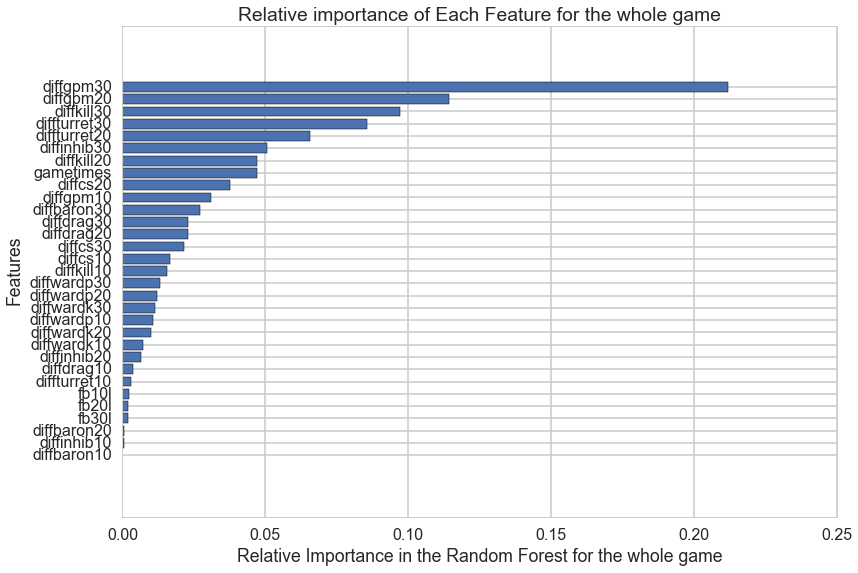

In [721]:
plt.barh(range(len(allcols_sort)),allimp_sort,align='center')
plt.yticks(range(len(allcols_sort)),allcols_sort)
plt.xlabel('Relative Importance in the Random Forest for the whole game')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature for the whole game')
plt.show()

This graph shows us overall trends for importance and how relative importance within its own time group remains fairly consistent. Most noticably, first blood seems to be a consistently poor metric in determining who wins. 

To make things more clearer, let's plot how relative importance changes over time:

In [722]:
#creating a list of columns to set as x ticks
newcol = list(df1.columns.values)

In [723]:
#removing win because that's not an independent variable
newcol.remove('win')

In [724]:
newcol

['diffbaron10',
 'diffcs10',
 'diffdrag10',
 'diffgpm10',
 'diffinhib10',
 'diffkill10',
 'diffturret10',
 'diffwardk10',
 'diffwardp10',
 'fb10l']

In [725]:
#now we take out the 10 in the column names so it's just "diffkill", "diffcs", etc.
xtickcols = []
for col in newcol:
    ncol = col.replace("10", "")
    xtickcols.append(ncol) 

In [726]:
xtickcols

['diffbaron',
 'diffcs',
 'diffdrag',
 'diffgpm',
 'diffinhib',
 'diffkill',
 'diffturret',
 'diffwardk',
 'diffwardp',
 'fbl']

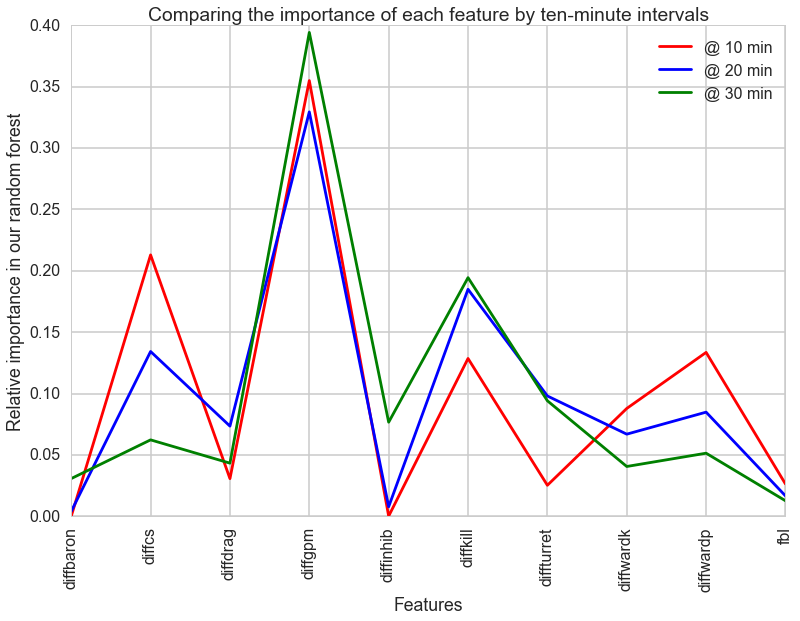

In [727]:
#Plotting the importances, color-coded by the ten-minute intervals
plt.plot(imp1, color = 'r', label = '@ 10 min')
plt.plot(imp2, color = 'b', label = '@ 20 min')
plt.plot(imp3, color = 'g', label = '@ 30 min')
plt.xticks(np.arange(len(xtickcols)))
#change each value to string just in case
x_tick_labels = [str(col) for col in xtickcols]
#set the x ticks to be the features
plt.gca().set_xticklabels(x_tick_labels, rotation = 90)
plt.ylabel("Relative importance in our random forest")
plt.xlabel("Features")
plt.title("Comparing the importance of each feature by ten-minute intervals")
plt.legend()

Notice how (excluding GPM) @10 minutes, CS and ward placed are important factors, whereas @30 miuntes, importance shifts towards kills. One other observation is that GPM importance actually falls in the 20 minute marker. This could be due to the fact that the mid game is more filled with objective-based games and teamfights, which are not necessarily directly correlated with gold. Even though getting more CS earns more gold, taking an objective like dragon or a turret (or even an inhibitor) could be huge in terms of power swings for a team.

<h2> What we learned: Insights and Limitations </h2>

Overall, the data that we analyzed taught us a few important points. First, we know that on average, we are able to predict with 69% accuracy which team will win given data about the 10 minute mark, 80% accuracy at the 20 minute mark, and 89% accuracy at the 30 minute mark. Games are readily determined in the early-mid game phase. Obviously, this doesn't mean that a team that's losing hard should simply "give up;" aside from the fact that comeback victories are always possible, there's also the fact that the reason why the team that is currently losing is going to lose is not simply due to the fact that they are losing, but because they are the <i> worse team</i>. After all, a team that is losing had to do something wrong or be worse in order to end up in that losing situation to begin with.

Consider this analogy; if we say that a certain basketball team A has a 10 point lead on team B with 7 minutes remaining in the game, this information tell us that team A is more likekly to win due to the fact that both 1) A is in the lead but also 2) A played better to end up in the lead. If, for example, team A and B were both high school teams and at 7 minutes remaining in the game a professional NBA team were to substitute in for team B, this would totally mess up the predictions since the predictive power of the team that <b> was </b>better is no longer salient. 

In other words, yes; League games are highly predictable even in the early stages of the game by looking at a few statistics, but not just becuase the lead will win the game for the team. 

Now, in Part 1 of the Process Book we stated that one of the main goals of this project was to gain strategic insight of what the Harvard League team can do to improve its likelihood of winning versus other collegiate teams. The analysis that we conducted with the time-split data provides some key decision-making advice for the team. Here are some key insights we learned:

1) For one, <b> early vision control is much more important </b>than is commonly thought; as explained in the @10 analysis, having dominant vision over the enemy team opens up opportunities for the team to thrive. This conclusion is supported by the data of relative importance of vision in the early game. 

2) Second, <b>mid-game teamfights are the path to victories</b>. Around the @20 marker, kills become a much more important factor than before; presumably due to the importance of teamfights in determining not only which team gets gold but also which team gets objectives. Accordingly, when faced with a decision of fighting a losing fight for a certain objective or more CS, the team should decide to go for the stronger teamfight. 
This point is even more important outside of game as well. When choosing the team composition, the team should have in mind the fact that mid-game teamfights will be important. In doing so, they can choose champions that support these mid-game "spikes." Some champions are strongest in the early stages of the game, while some champions only become formidable after several minutes of gameplay. The Harvard League team should choose a composition that balances early game control but prioritizes mid-game fighting power.

3) Perhaps most importantly,<b> late-game objectives win games</b>. We learned through the @30 data that, compared to previous time markers, getting turrets and inhibitors are the main determining factors of victory after gpm and kills. This statistic may seem unimportant considering that (as explained in part 2) kills lead to towers/inhibitors. However, the reason this point is so crucial is because the team may be facing a situation where they <i> can't </i>win a teamfight. If a team is sufficiently behind in resources or has a losing team composition, it could be the case that team simply cannot pick a fight in which they will come out victorious. If this is the case, our model tells us that going for objectives like turrets or inhibitors is the best strategy. In other words, when falling behind, in a gold defecit, or simply facing a stronger teamfighting comp, the Harvard League team should focus on split-pushing (avoiding the enenmy team while pushing for objectives) in order to gain more map control and eventually push for the win. 

These insights do have significantl limitations that must be addressed. First, the data we gathered was from solo queue data, which is when 5 players who have not coordinated or practiced get into a match and play. The dynamics of team play may change in a situation where 5 coordinated players (like the Harvard League team) go against 5 other coordinated players. Unfortunately, there isn't enough data on coordinated, high-ranked teams for us to come up with meaningful conclusions using the methods that we used in the project. That being said, however, there is good reason to believe that many of the factors that are mentioned in the project as important are still consistently salient in the case of coordinated ranked teams.

Overall, this project was a great way for us to learn about what factors were indicators of victory overall for League of Legends matches. But more importantly, however, this project provided great information on how these indicators change over time, and what that change in relative importance mean for a competitive team looking to create an optimal strategy of prioritization in their games. Finally, we learned about the high predictive powers of the Random Forest model when given data about League matches, even if the data provided was only from the first 10 minutes of a potentially hour-long game. 


#Appendix: Logistic Regression

The following section is a step-by-step process of how we conducted logistic regression on both dataframes (non-time interval and time interval one). That being said, we did not use this as our main method of analysis to interpret because of the significant problem of colinearity in the data. That being said, we included as an Appendix to our main work just to show how we conducted a method different from Random Forest. 

In [377]:
from sklearn.linear_model import LogisticRegression

In [451]:
logdf = pd.read_csv('newdf.csv')
logdf.head()

diffbaron  diffcc  diffcs  diffdmg  diffdrag  diffgold    diffkda  diffrange  diffspree  difftank fbaron fblood  fdrag finhib fturret    win
0          1     819     155    17067         3     17703  18.144444         -1          5         0   True  False   True   True   False   True
1          1    -685      24   -23447         0    -11396 -20.117208          1         -7         1   True  False   True  False   False  False
2         -1     658      16    -5988         0    -11734 -21.416667          1         -3         1  False   True   True  False    True  False
3         -1    -339    -127    -9102        -2    -17661 -17.531349          1         -6         0  False  False  False  False   False  False
4          0     756     162    12505         0     11899  26.059524          0          3         3  False  False  False   True    True   True

In [455]:
columns = list(logdf.columns.values)

In [456]:
columns.remove('win')
columns

['diffbaron',
 'diffcc',
 'diffcs',
 'diffdmg',
 'diffdrag',
 'diffgold',
 'diffkda',
 'diffrange',
 'diffspree',
 'difftank',
 'fbaron',
 'fblood',
 'fdrag',
 'finhib',
 'fturret']

In [463]:
lasso = LogisticRegression(penalty = 'l1')
clflasso, Xtrainl, ytrainl, Xtestl, ytestl = do_classify(lasso, {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},logdf,columns, 'win',1, mask = mask)

using mask
BEST {'C': 0.1} 0.9804504326 [mean: 0.97959, std: 0.00142, params: {'C': 0.001}, mean: 0.97953, std: 0.00151, params: {'C': 0.01}, mean: 0.98045, std: 0.00156, params: {'C': 0.1}, mean: 0.98032, std: 0.00183, params: {'C': 1.0}, mean: 0.98012, std: 0.00183, params: {'C': 10.0}, mean: 0.98025, std: 0.00183, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.98
Accuracy on test data:     0.98
[[2645   61]
 [  49 2293]]
########################################################


/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:20: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 20223 but corresponding boolean dimension is 20189


In [465]:
#Getting the coefficients of each features
coef = list(clflasso.coef_[0])

In [466]:
print coef

[-0.31179134961664479, 3.1408817400953613e-05, -0.0061375218101635664, 9.0594567857217073e-06, -0.054479718950485312, 0.00063087265426519312, 0.021331261476895919, -0.0075058125295135829, -0.050675311277689102, 0.04316528819036753, -0.24504195030805145, -0.31603293762093371, 0.038738055556550792, 1.0821539383551289, 0.0]


In [467]:
coef_sort, logcols_sort = zip(*sorted(zip(coef, columns)))

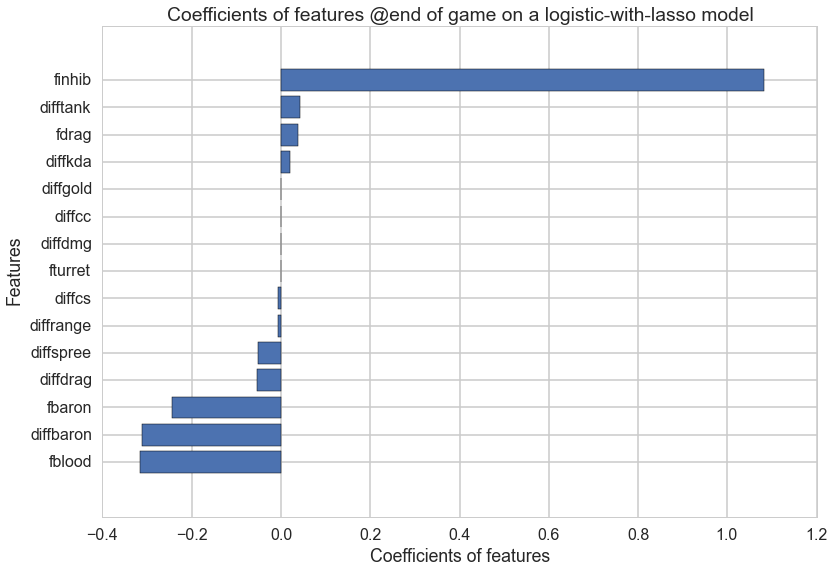

In [468]:
plt.barh(range(len(logcols_sort)), coef_sort,align='center')
plt.yticks(range(len(logcols_sort)),logcols_sort)
plt.xlabel('Coefficients of features')
plt.ylabel('Features')
plt.title('Coefficients of features @end of game on a logistic-with-lasso model')
plt.show()

10 min

In [728]:
df1.head()

diffbaron10  diffcs10  diffdrag10  diffgpm10  diffinhib10  diffkill10  diffturret10  diffwardk10  diffwardp10  fb10l    win
0            0       4.3           0      199.6            0           2             0            0           -4     -1   True
1            0       2.3           1      -75.5            0          -3            -1            2           -4     -1  False
2            0       4.5           0      223.6            0           3             1            0            3      1  False
3            0      -2.9           0     -274.6            0          -6             0            0            0     -1  False
4            0       2.4           0      126.0            0           3             0            0           -6     -1   True

In [729]:
lcols1

['diffbaron10',
 'diffcs10',
 'diffdrag10',
 'diffgpm10',
 'diffinhib10',
 'diffkill10',
 'diffturret10',
 'diffwardk10',
 'diffwardp10',
 'fb10l']

In [730]:
lasso1 = LogisticRegression(penalty = 'l1')
clflog1, Xtrainlog1, ytrainlog1, Xtestlog1, ytestlog1 = do_classify(lasso1, {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df1,lcols1, 'win',1, mask = mask)

using mask
BEST {'C': 1.0} 0.715993465993 [mean: 0.71265, std: 0.00943, params: {'C': 0.001}, mean: 0.71495, std: 0.00838, params: {'C': 0.01}, mean: 0.71533, std: 0.00991, params: {'C': 0.1}, mean: 0.71599, std: 0.00949, params: {'C': 1.0}, mean: 0.71592, std: 0.00967, params: {'C': 10.0}, mean: 0.71592, std: 0.00962, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.72
Accuracy on test data:     0.70
[[1703  545]
 [ 806 1436]]
########################################################


/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:20: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 18819 but corresponding boolean dimension is 17958


In [731]:
#Getting the coefficients of each features
coef1 = list(clflog1.coef_[0])

In [732]:
print lcols1
print coef1

['diffbaron10', 'diffcs10', 'diffdrag10', 'diffgpm10', 'diffinhib10', 'diffkill10', 'diffturret10', 'diffwardk10', 'diffwardp10', 'fb10l']
[0.0, 0.083473208732802479, 0.26537256586019276, 0.0052948712379908922, 0.0, 0.040460378484693277, -0.17536400703232533, 0.0057816166262093984, 0.012088821131807381, -0.028914622775151746]


In [733]:
coef1_sort, logcols1_sort = zip(*sorted(zip(coef1, lcols1)))

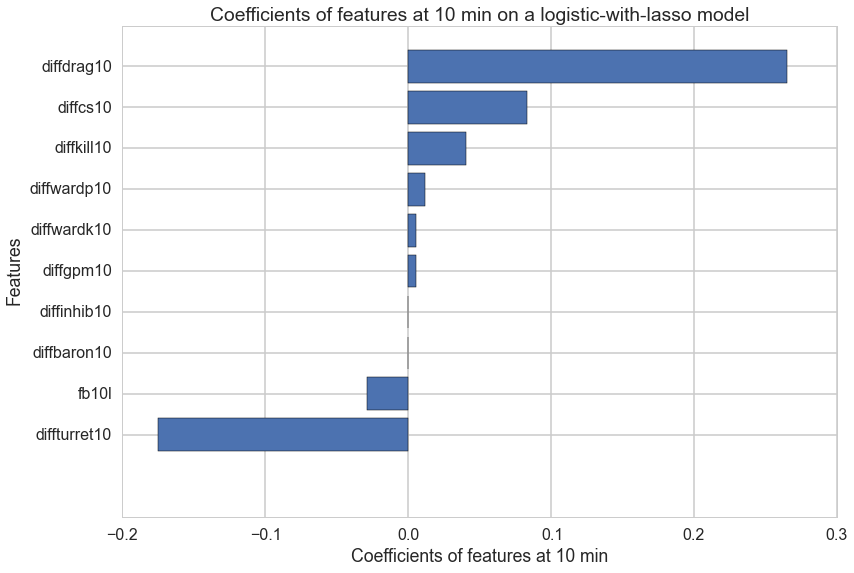

In [734]:
plt.barh(range(len(logcols1_sort)), coef1_sort,align='center')
plt.yticks(range(len(logcols1_sort)),logcols1_sort)
plt.xlabel('Coefficients of features at 10 min')
plt.ylabel('Features')
plt.title('Coefficients of features at 10 min on a logistic-with-lasso model')
plt.show()

20 min

In [735]:
lasso2 = LogisticRegression(penalty = 'l1')
clflog2, Xtrainlog2, ytrainlog2, Xtestlog2, ytestlog2 = do_classify(lasso2, {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df2,lcols2, 'win',1, mask = mask)

using mask
BEST {'C': 1.0} 0.820389070389 [mean: 0.81326, std: 0.00697, params: {'C': 0.001}, mean: 0.81824, std: 0.00651, params: {'C': 0.01}, mean: 0.81950, std: 0.00764, params: {'C': 0.1}, mean: 0.82039, std: 0.00713, params: {'C': 1.0}, mean: 0.82031, std: 0.00707, params: {'C': 10.0}, mean: 0.82024, std: 0.00734, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.82
Accuracy on test data:     0.82
[[1968  392]
 [ 410 1720]]
########################################################


/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:20: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 18800 but corresponding boolean dimension is 17958


In [736]:
#Getting the coefficients of each features
coef2 = list(clflog2.coef_[0])

In [737]:
print lcols2
print coef2

['diffbaron20', 'diffcs20', 'diffdrag20', 'diffgpm20', 'diffinhib20', 'diffkill20', 'diffturret20', 'diffwardk20', 'diffwardp20', 'fb20l']
[0.69137534826199831, 0.084739008034353566, 0.36367708118605335, 0.0022176000396210197, 0.74074043248040999, 0.077474131760737072, 0.11745403565822181, 0.0065257339081199817, 0.0013980373702336571, 0.074987670261662337]


In [738]:
coef2_sort, logcols2_sort = zip(*sorted(zip(coef2, lcols2)))

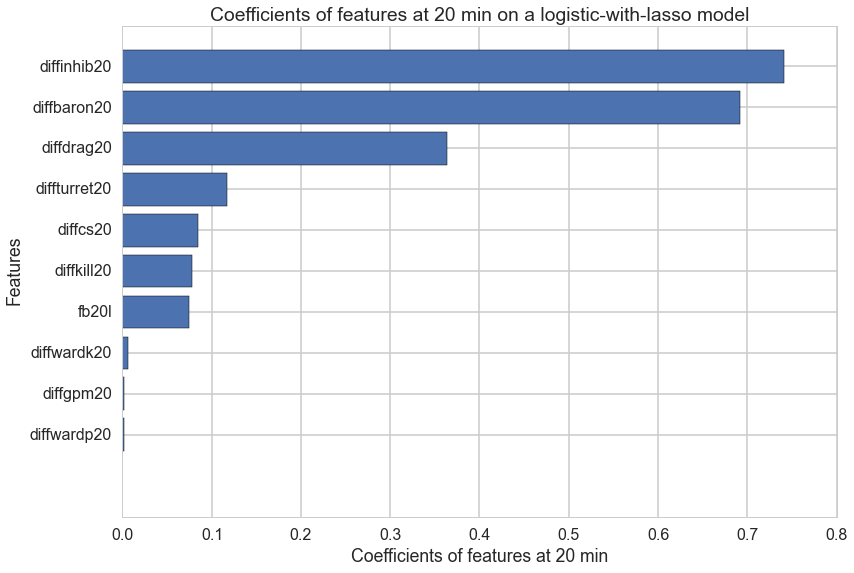

In [739]:
plt.barh(range(len(logcols2_sort)), coef2_sort,align='center')
plt.yticks(range(len(logcols2_sort)),logcols2_sort)
plt.xlabel('Coefficients of features at 20 min')
plt.ylabel('Features')
plt.title('Coefficients of features at 20 min on a logistic-with-lasso model')
plt.show()

30 min

In [740]:
lasso3 = LogisticRegression(penalty = 'l1')
clflog3, Xtrainlog3, ytrainlog3, Xtestlog3, ytestlog3 = do_classify(lasso3, {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df3,lcols3, 'win',1, mask = mask)

using mask
BEST {'C': 100.0} 0.887882387882 [mean: 0.87377, std: 0.00955, params: {'C': 0.001}, mean: 0.88699, std: 0.00649, params: {'C': 0.01}, mean: 0.88729, std: 0.00612, params: {'C': 0.1}, mean: 0.88781, std: 0.00603, params: {'C': 1.0}, mean: 0.88773, std: 0.00600, params: {'C': 10.0}, mean: 0.88788, std: 0.00559, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.89
Accuracy on test data:     0.89
[[2120  243]
 [ 254 1873]]
########################################################


/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [741]:
#Getting the coefficients of each features
coef3 = list(clflog3.coef_[0])

In [742]:
print lcols3
print coef3

['diffbaron30', 'diffcs30', 'diffdrag30', 'diffgpm30', 'diffinhib30', 'diffkill30', 'diffturret30', 'diffwardk30', 'diffwardp30', 'fb30l']
[0.39124383563250903, 0.057741566428222216, 0.36759463813982413, 0.0017121448306078302, 1.0284780013659285, 0.1094177235129722, -0.010309441296365032, 0.0063393649705538284, 0.00086305457301485381, 0.20508602439516074]


In [743]:
coef3_sort, logcols3_sort = zip(*sorted(zip(coef3, lcols3)))

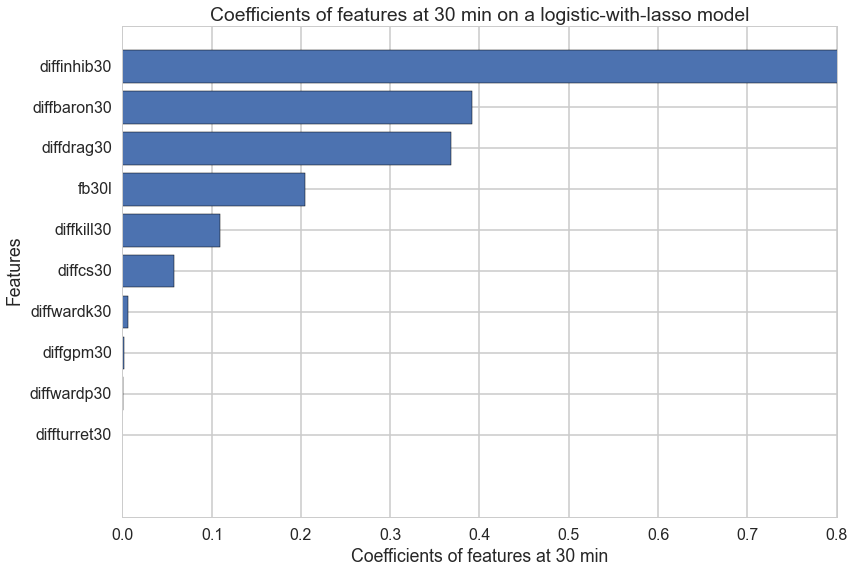

In [744]:
plt.barh(range(len(logcols3_sort)), coef3_sort,align='center')
plt.yticks(range(len(logcols3_sort)),logcols3_sort)
plt.xlabel('Coefficients of features at 30 min')
plt.xlim((0, 0.8))
plt.ylabel('Features')
plt.title('Coefficients of features at 30 min on a logistic-with-lasso model')
plt.show()

Logistic on the whole thing

In [745]:
logcols = list(df.columns.values)
logcols.remove('matchid')
logcols.remove('win')
logcols

['diffbaron10',
 'diffbaron20',
 'diffbaron30',
 'diffcs10',
 'diffcs20',
 'diffcs30',
 'diffdrag10',
 'diffdrag20',
 'diffdrag30',
 'diffgpm10',
 'diffgpm20',
 'diffgpm30',
 'diffinhib10',
 'diffinhib20',
 'diffinhib30',
 'diffkill10',
 'diffkill20',
 'diffkill30',
 'diffturret10',
 'diffturret20',
 'diffturret30',
 'diffwardk10',
 'diffwardk20',
 'diffwardk30',
 'diffwardp10',
 'diffwardp20',
 'diffwardp30',
 'fb10l',
 'fb20l',
 'fb30l',
 'gametimes']

In [746]:
wholelasso = LogisticRegression(penalty = 'l1')
clflogx, Xtrainlogx, ytrainlogx, Xtestlogx, ytestlogx = do_classify(wholelasso, {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df,logcols, 'win',1, mask = mask)

using mask
BEST {'C': 1.0} 0.911196911197 [mean: 0.90526, std: 0.00691, params: {'C': 0.001}, mean: 0.90719, std: 0.00638, params: {'C': 0.01}, mean: 0.91105, std: 0.00444, params: {'C': 0.1}, mean: 0.91120, std: 0.00329, params: {'C': 1.0}, mean: 0.91105, std: 0.00312, params: {'C': 10.0}, mean: 0.91068, std: 0.00335, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.91
Accuracy on test data:     0.91
[[2102  146]
 [ 237 2005]]
########################################################


/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/leosjk/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:20: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 18819 but corresponding boolean dimension is 17958


In [747]:
#Getting the coefficients of each features
coefx = list(clflogx.coef_[0])

In [748]:
print coefx

[0.0, 0.0, 0.34136867062334542, -0.023508069547337272, 0.024777358211862954, 0.046368307794677981, 0.26851493109963487, 0.2825489253957022, 0.20731157915720799, 0.0023168252596643731, 0.00091671790101311085, 0.0014831560516681251, 1.5199836106417137, 1.6419656783877661, 0.26456554318051412, -0.053576734494241829, 0.069134400838556029, 0.1445013992270284, 0.037642209744316611, 0.13853772108026699, 0.08140859799187912, 0.018140485507565154, 0.013023127627539526, 0.014848444307612181, 0.011564529097967641, 0.0024845992013955557, 0.006461104382719773, -0.03103850078802323, 0.0, 0.0, -0.00014558559040493644]


In [749]:
coefx_sort, logcolsx_sort = zip(*sorted(zip(coefx, logcols)))

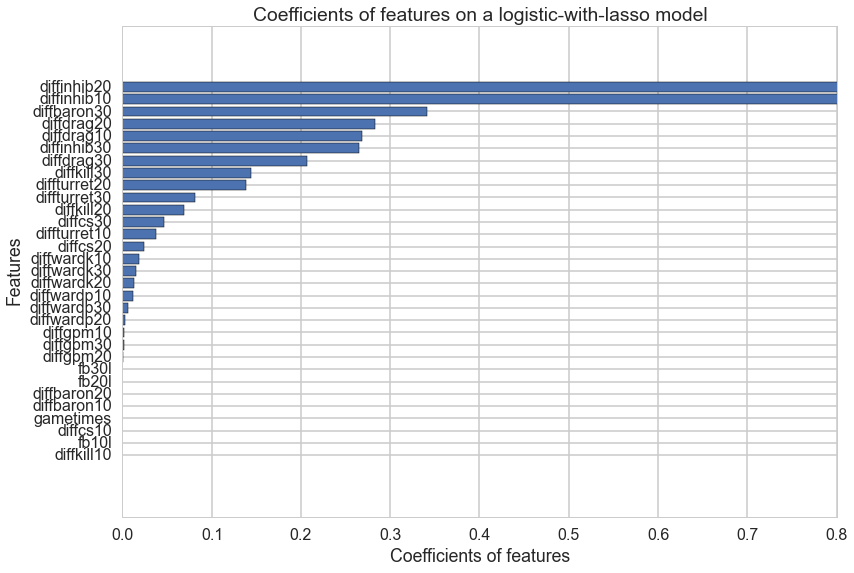

In [750]:
plt.barh(range(len(logcolsx_sort)), coefx_sort,align='center')
plt.yticks(range(len(logcolsx_sort)),logcolsx_sort)
plt.xlabel('Coefficients of features')
plt.xlim((0, 0.8))
plt.ylabel('Features')
plt.title('Coefficients of features on a logistic-with-lasso model')
plt.show()